# Fraud Detection Analysis

This notebook performs comprehensive analysis of fraud detection data using various machine learning approaches.

## Table of Contents
1. [Data Loading and Preprocessing](#1)
2. [Exploratory Data Analysis (EDA)](#2)
3. [Feature Engineering](#3)
4. [Machine Learning Models](#4)
5. [Model Evaluation](#5)

## Setup and Imports

In [5]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Saving the model
import joblib
import os

# Essential imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Metrics and evaluation tools
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report,
    average_precision_score, precision_recall_curve,
    RocCurveDisplay, ConfusionMatrixDisplay, PrecisionRecallDisplay,precision_score,recall_score,f1_score
)

# Machine Learning models
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from skopt import BayesSearchCV

# Configure visualizations
sns.set_theme(style="whitegrid")
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

<a id='1'></a>
## 1. Data Loading and Preprocessing

We'll start by loading the FRAUD.CSV dataset and examining its basic properties.

In [6]:
# Load the dataset
df = pd.read_csv('FRAUD.CSV')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

print("\nFirst few rows:")
df.head()

Dataset Shape: (16142, 9)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16142 entries, 0 to 16141
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            16142 non-null  object 
 1   amount          16142 non-null  float64
 2   nameOrig        16142 non-null  object 
 3   oldbalanceOrg   16142 non-null  float64
 4   newbalanceOrig  16142 non-null  float64
 5   nameDest        16142 non-null  object 
 6   oldbalanceDest  16142 non-null  float64
 7   newbalanceDest  16142 non-null  float64
 8   isFraud         16142 non-null  int64  
dtypes: float64(5), int64(1), object(3)
memory usage: 1.1+ MB

First few rows:


type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0  CASH_OUT  195490.04  C1107204185           0.00            0.00   
1  CASH_OUT  125275.00  C1538849250           0.00            0.00   
2  TRANSFER   60949.25   C773535564           0.00            0.00   
3   CASH_IN  101640.69   C265330243     3548387.86      3650028.55   
4   PAYMENT    3710.80  C1171097095       71978.00        68267.20   

     nameDest  oldbalanceDest  newbalanceDest  isFraud  
0  C564160838      1104500.40      1254956.07        0  
1  C401424608      1477426.93      1178808.14        0  
2  C481402298       632824.07       617488.40        0  
3  C542895457       192397.59        93380.65        0  
4  M165886570            0.00            0.00        0

<a id='2'></a>
## 2. Exploratory Data Analysis (EDA)

Let's analyze the distribution and relationships between variables.

In [7]:
# Summary statistics
print("Summary Statistics:")
df.describe()

Summary Statistics:


amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
count  1.614200e+04   1.614200e+04    1.614200e+04    1.614200e+04   
mean   2.655567e+05   8.895427e+05    8.047901e+05    1.015319e+06   
std    8.935029e+05   2.915525e+06    2.841016e+06    2.895769e+06   
min    0.000000e+00   0.000000e+00    0.000000e+00    0.000000e+00   
25%    1.466256e+04   0.000000e+00    0.000000e+00    0.000000e+00   
50%    8.782760e+04   1.997750e+04    0.000000e+00    1.035136e+05   
75%    2.319357e+05   1.583547e+05    1.138387e+05    8.664911e+05   
max    3.527187e+07   4.039905e+07    3.388709e+07    1.188132e+08   

       newbalanceDest       isFraud  
count    1.614200e+04  16142.000000  
mean     1.180620e+06      0.070747  
std      3.147067e+06      0.256410  
min      0.000000e+00      0.000000  
25%      0.000000e+00      0.000000  
50%      2.067598e+05      0.000000  
75%      1.092889e+06      0.000000  
max      1.188746e+08      1.000000

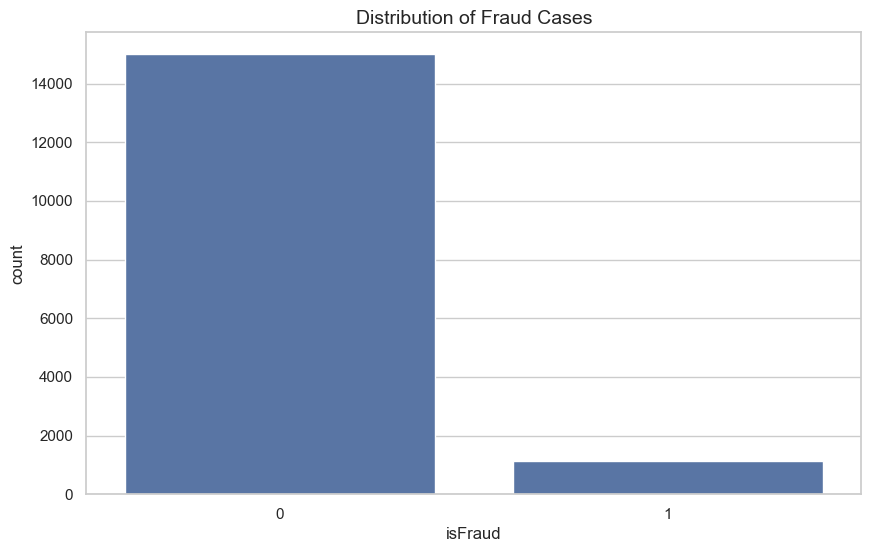

In [8]:
# Distribution of fraud cases
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='isFraud')
plt.title('Distribution of Fraud Cases', fontsize=14)
plt.show()

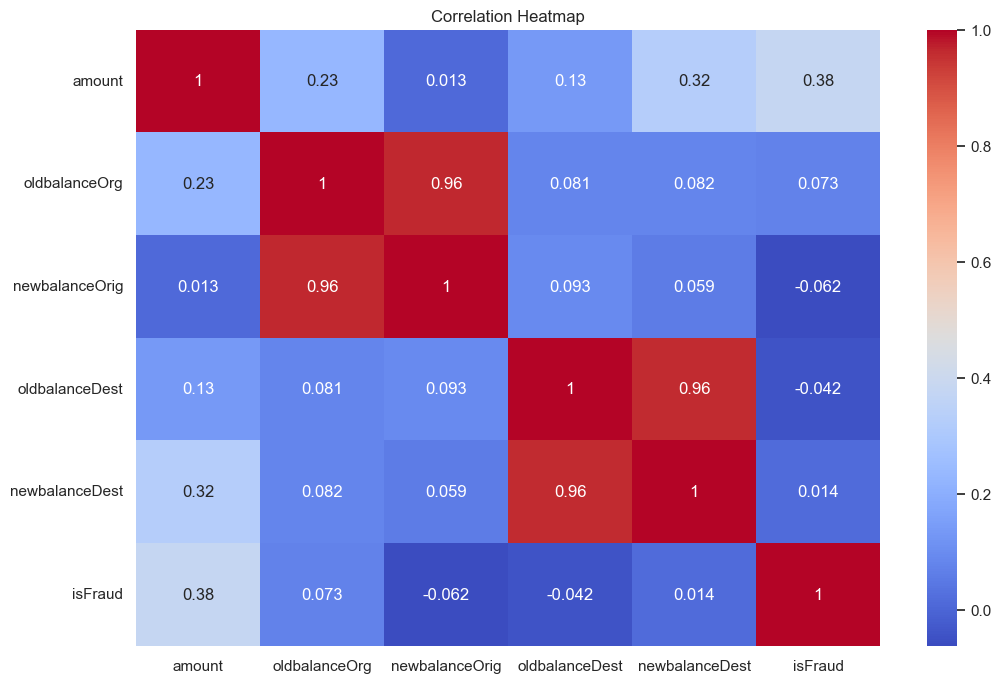

In [5]:
# Correlation heatmap of numerical features
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

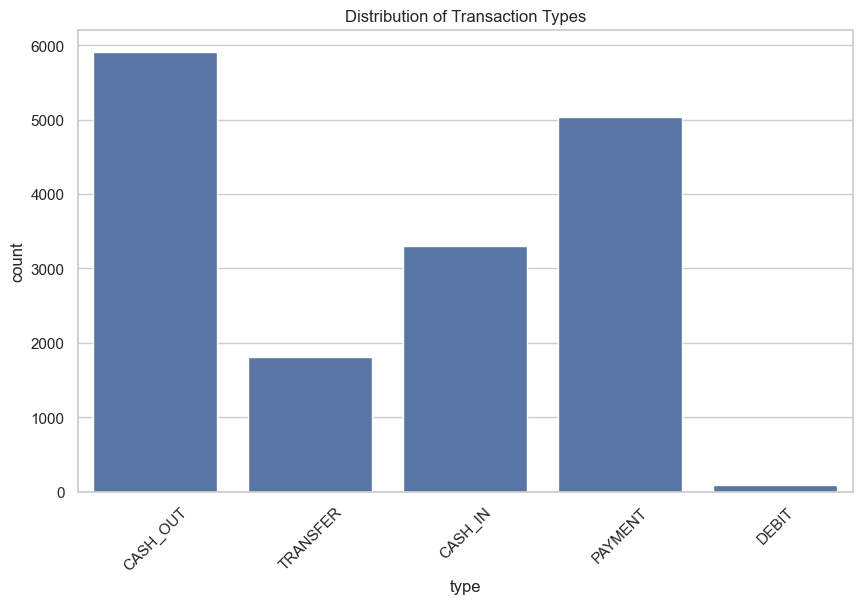

In [6]:
# Distribution of transaction types
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type')
plt.xticks(rotation=45)
plt.title('Distribution of Transaction Types')
plt.show()

In [7]:
# Count the transaction types
transaction_counts = df['type'].value_counts().reset_index()
transaction_counts.columns = ['Transaction Type', 'Count']

# Display the table
print(transaction_counts)

  Transaction Type  Count
0         CASH_OUT   5914
1          PAYMENT   5032
2          CASH_IN   3294
3         TRANSFER   1814
4            DEBIT     88


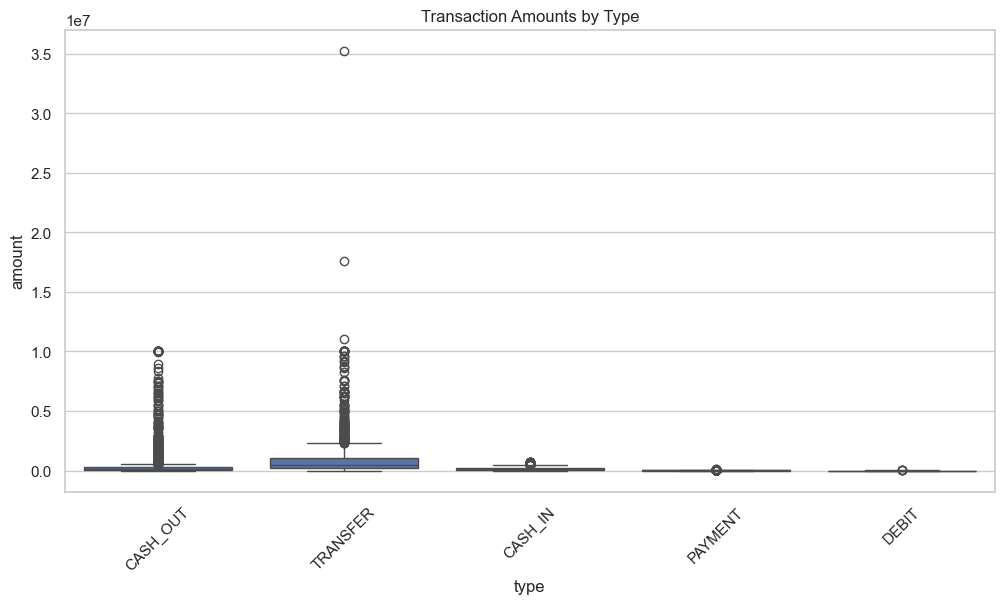

In [8]:
# Box plots for amount by transaction type
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='type', y='amount')
plt.xticks(rotation=45)
plt.title('Transaction Amounts by Type')
plt.show()

In [9]:
import pandas as pd

# Load your dataset (replace with your actual file path)
df = pd.read_csv("FRAUD.CSV")  # Replace with the path to your dataset

# Ensure your dataset has the 'type' and 'is_fraud' columns
# 'type' represents transaction types (e.g., TRANSFER, CASH_OUT, etc.)
# 'is_fraud' is a binary column (1 for fraud, 0 for non-fraud)

# Calculate fraud rate, total count, and fraud cases for each transaction type
fraud_summary = df.groupby('type').agg(
    total_count=('type', 'size'),
    fraud_cases=('isFraud', 'sum')
)

# Calculate fraud rate as a percentage
fraud_summary['fraud_rate'] = (fraud_summary['fraud_cases'] / fraud_summary['total_count']) * 100

# Reorder columns for better presentation
fraud_summary = fraud_summary[['fraud_rate', 'total_count', 'fraud_cases']]

# Display the resulting table
print(fraud_summary)



          fraud_rate  total_count  fraud_cases
type                                          
CASH_IN     0.000000         3294            0
CASH_OUT    9.739601         5914          576
DEBIT       0.000000           88            0
PAYMENT     0.000000         5032            0
TRANSFER   31.201764         1814          566


In [10]:
import pandas as pd

# Load your dataset
df = pd.read_csv("FRAUD.CSV")  # Replace with the path to your dataset

# Calculate fraud rate, total count, fraud cases, and total transaction amounts for each transaction type
fraud_summary = df.groupby('type').agg(
    total_count=('type', 'size'),
    fraud_cases=('isFraud', 'sum'),  # Adjust column name if needed
    total_amount=('amount', 'sum')   # Assuming 'amount' is the column for transaction amounts
)

# Calculate fraud rate as a percentage
fraud_summary['fraud_rate'] = (fraud_summary['fraud_cases'] / fraud_summary['total_count']) * 100

# Reorder columns for better presentation
fraud_summary = fraud_summary[['fraud_rate', 'total_count', 'fraud_cases', 'total_amount']]

# Display the resulting table
print(fraud_summary)


          fraud_rate  total_count  fraud_cases  total_amount
type                                                        
CASH_IN     0.000000         3294            0  5.515357e+08
CASH_OUT    9.739601         5914          576  1.801786e+09
DEBIT       0.000000           88            0  4.263622e+05
PAYMENT     0.000000         5032            0  6.430061e+07
TRANSFER   31.201764         1814          566  1.868567e+09


In [11]:
# Calculate IQR and outliers for each transaction type
def get_outlier_stats(group):
    Q1 = group['amount'].quantile(0.25)
    Q3 = group['amount'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = group[(group['amount'] < lower_bound) | (group['amount'] > upper_bound)]
    
    return pd.Series({
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Number of Outliers': len(outliers),
        'Total Records': len(group),
        'Outlier Percentage': (len(outliers) / len(group)) * 100
    })

# Group by transaction type and apply the function
outlier_stats = df.groupby('type').apply(get_outlier_stats)

# Display the results
print("\nOutlier Statistics by Transaction Type:")
print("=======================================")
for transaction_type in outlier_stats.index:
    print(f"\nTransaction Type: {transaction_type}")
    print(f"Number of Outliers: {outlier_stats.loc[transaction_type, 'Number of Outliers']:.0f}")
    print(f"Total Records: {outlier_stats.loc[transaction_type, 'Total Records']:.0f}")
    print(f"Outlier Percentage: {outlier_stats.loc[transaction_type, 'Outlier Percentage']:.2f}%")



Outlier Statistics by Transaction Type:

Transaction Type: CASH_IN
Number of Outliers: 54
Total Records: 3294
Outlier Percentage: 1.64%

Transaction Type: CASH_OUT
Number of Outliers: 329
Total Records: 5914
Outlier Percentage: 5.56%

Transaction Type: DEBIT
Number of Outliers: 4
Total Records: 88
Outlier Percentage: 4.55%

Transaction Type: PAYMENT
Number of Outliers: 250
Total Records: 5032
Outlier Percentage: 4.97%

Transaction Type: TRANSFER
Number of Outliers: 170
Total Records: 1814
Outlier Percentage: 9.37%


The ouliers need to be investigated

<a id='3'></a>
## 3. Feature Engineering

We'll now prepare our features for machine learning models.

In [12]:
# Create feature engineering pipeline
numerical_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
categorical_features = ['type']

# Create new features
df['balance_diff_orig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balance_diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']
numerical_features.extend(['balance_diff_orig', 'balance_diff_dest'])

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Prepare features and target
X = df[numerical_features + categorical_features]
y = df['isFraud']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
from sklearn.inspection import PartialDependenceDisplay

def evaluate_models():
    # [Previous code remains the same until the feature importance section]
    
    # Feature importance for Random Forest
    if hasattr(rf_pipeline.named_steps['classifier'], 'feature_importances_'):
        feature_names = (numerical_features + 
                        [f"{feat}_{val}" for feat, vals in 
                         zip(categorical_features, preprocessor.named_transformers_['cat'].categories_)
                         for val in vals[1:]])
        
        importances = rf_pipeline.named_steps['classifier'].feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 6))
        plt.title("Feature Importances (Random Forest)")
        plt.bar(range(len(importances)), importances[indices])
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 Most Important Features:")
        for idx in indices[:10]:
            print(f"{feature_names[idx]}: {importances[idx]:.4f}")
        
        # Partial Dependence Plots for top 3 features
        top_features = [feature_names[i] for i in indices[:3]]
        print("\nGenerating Partial Dependence Plots for top features:", top_features)
        
        # Get the preprocessed feature names from the pipeline
        preprocessed_features = []
        for feat in top_features:
            if feat in numerical_features:
                preprocessed_features.append(feat)
            else:
                # Handle one-hot encoded categorical features
                for i, name in enumerate(feature_names):
                    if name == feat:
                        preprocessed_features.append(i)
                        break
        
        fig, ax = plt.subplots(figsize=(12, 6))
        PartialDependenceDisplay.from_estimator(
            rf_pipeline.named_steps['classifier'],
            rf_pipeline.named_steps['preprocessor'].transform(X_test),
            features=preprocessed_features,
            feature_names=feature_names,
            ax=ax
        )
        plt.suptitle("Partial Dependence Plots for Top Features")
        plt.tight_layout()
        plt.show()

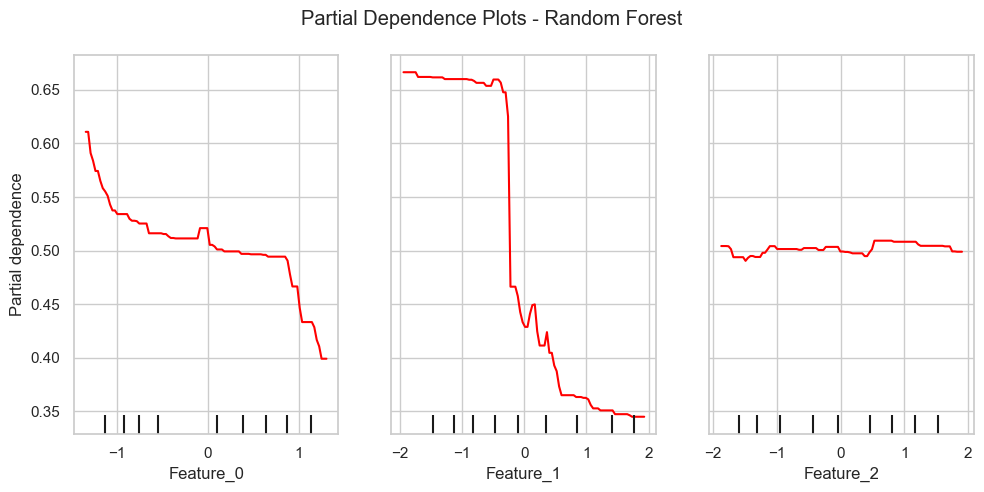

In [14]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def plot_partial_dependence(model, X, features, feature_names=None, model_name=""):
    """
    Generate PDP plots for a trained model
    
    Parameters:
    - model: Trained scikit-learn pipeline/estimator
    - X: Raw input features (DataFrame or array)
    - features: List of feature names/indices to plot
    - feature_names: All feature names after preprocessing
    - model_name: Name for plot titles
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    
    PartialDependenceDisplay.from_estimator(
        estimator=model,
        X=X,
        features=features,
        feature_names=feature_names,
        ax=ax,
        kind='average',
        pd_line_kw={'color': 'red'}
    )
    
    plt.suptitle(f"Partial Dependence Plots - {model_name}")
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # 1. Prepare your data (replace with actual data)
    from sklearn.datasets import make_classification
    X, y = make_classification(n_features=5, random_state=42)
    feature_names = [f"Feature_{i}" for i in range(X.shape[1])]
    
    # 2. Train a model (replace with your actual model)
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier().fit(X, y)
    
    # 3. Generate PDPs for first 3 features
    plot_partial_dependence(
        model=model,
        X=X,
        features=[0, 1, 2],  # Can use feature indices or names
        feature_names=feature_names,
        model_name="Random Forest"
    )

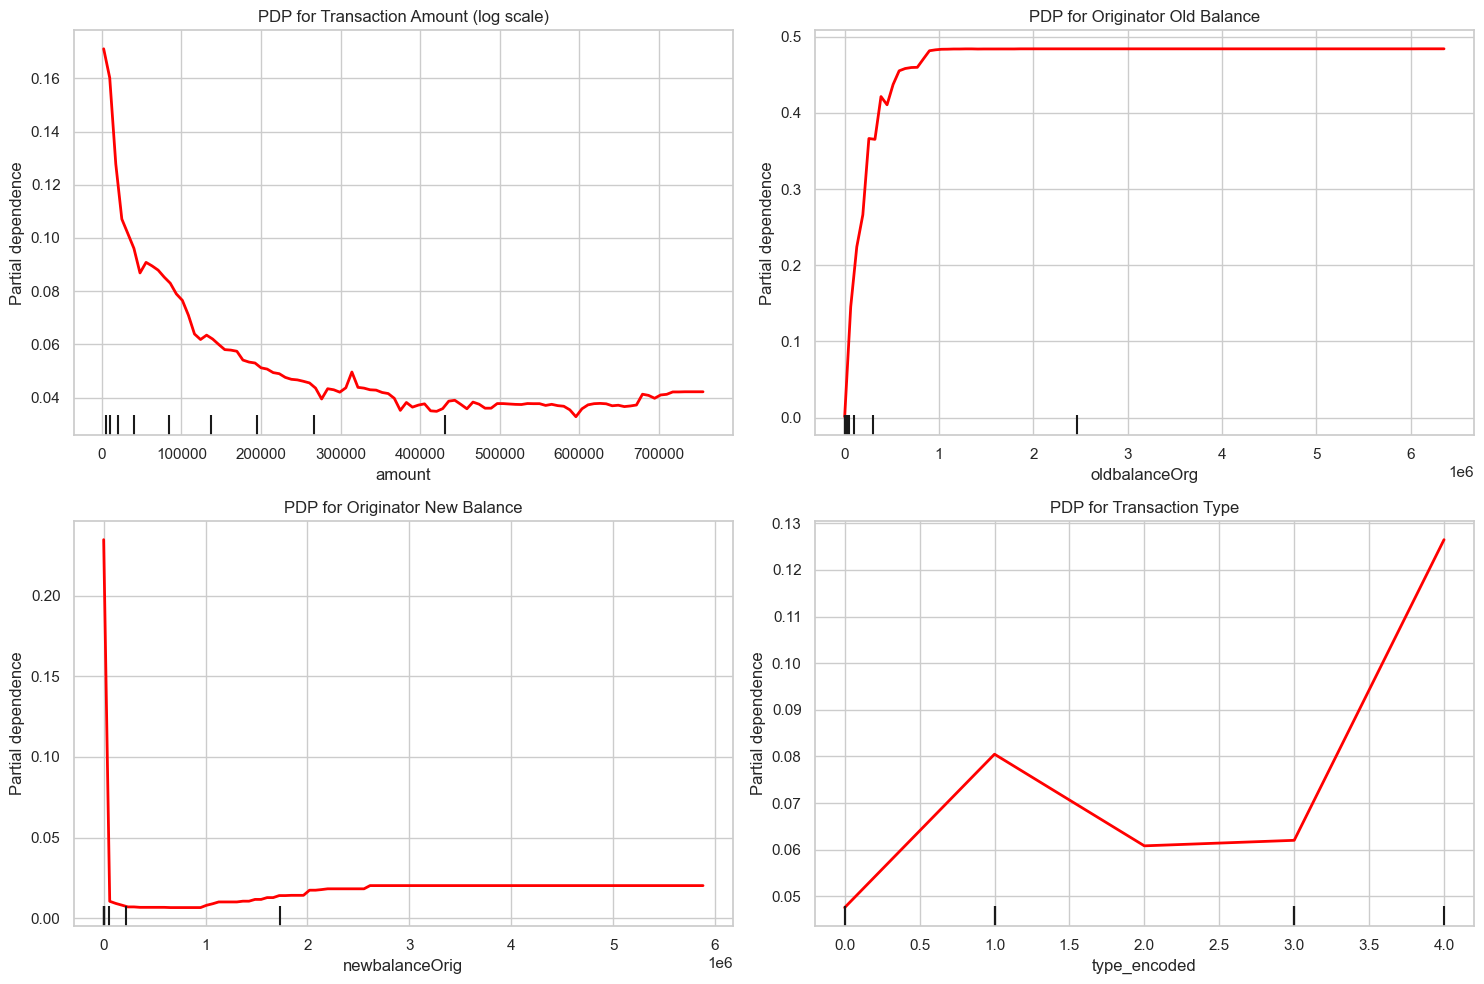

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Load your dataset
data = pd.read_csv('FRAUD.CSV')

# 1. Data Preparation --------------------------------------------------------
# Select relevant features (adjust based on your dataset)
features = [
    'type',          # Transaction type
    'amount',        # Transaction amount
    'oldbalanceOrg', # Originator balance before
    'newbalanceOrig' # Originator balance after
]

# Create feature matrix and target
X = data[features]
y = data['isFraud']

# 2. Preprocessing ----------------------------------------------------------
# Encode categorical features
le = LabelEncoder()
X['type_encoded'] = le.fit_transform(X['type'])

# Final numeric features (drop original 'type')
numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'type_encoded']
X = X[numeric_features]

# 3. Model Pipeline ---------------------------------------------------------
model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'  # Important for imbalanced fraud data
    ))
])

# 4. Train-Test Split ------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y  # Preserve fraud ratio
)

# 5. Train Model -----------------------------------------------------------
model.fit(X_train, y_train)

# 6. Generate PDPs --------------------------------------------------------
# Create figure
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Feature display names
feature_labels = {
    'amount': 'Transaction Amount (log scale)',
    'oldbalanceOrg': 'Originator Old Balance',
    'newbalanceOrig': 'Originator New Balance',
    'type_encoded': 'Transaction Type'
}

# Generate PDP for each feature
for i, feature in enumerate(numeric_features):
    row, col = divmod(i, 2)
    
    PartialDependenceDisplay.from_estimator(
        model,
        X_test,
        features=[feature],
        feature_names=numeric_features,
        ax=ax[row, col],
        line_kw={'color': 'red', 'linewidth': 2},
        random_state=42
    )
    
    # Custom formatting
    ax[row, col].set_title(f"PDP for {feature_labels[feature]}")
    ax[row, col].set_xlabel(feature_labels[feature])
    
    # Special formatting
    if feature in ['amount', 'oldbalanceOrg', 'newbalanceOrig']:
        ax[row, col].set_xscale('log')
    elif feature == 'type_encoded':
        ax[row, col].set_xticks(range(len(le.classes_)))
        ax[row, col].set_xticklabels(le.classes_, rotation=45)

plt.tight_layout()
plt.savefig('fraud_pdps.png', dpi=300)
plt.show()

Loading and preprocessing data...
Available columns: Index(['type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrg',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

Applying SMOTE to balance classes...

Training Isolation Forest for anomaly detection...

Training Random Forest Classifier with anomaly scores...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s



Random Forest Performance with Anomaly Scores:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1318
           1       1.00      1.00      1.00       228

    accuracy                           1.00      1546
   macro avg       1.00      1.00      1.00      1546
weighted avg       1.00      1.00      1.00      1546



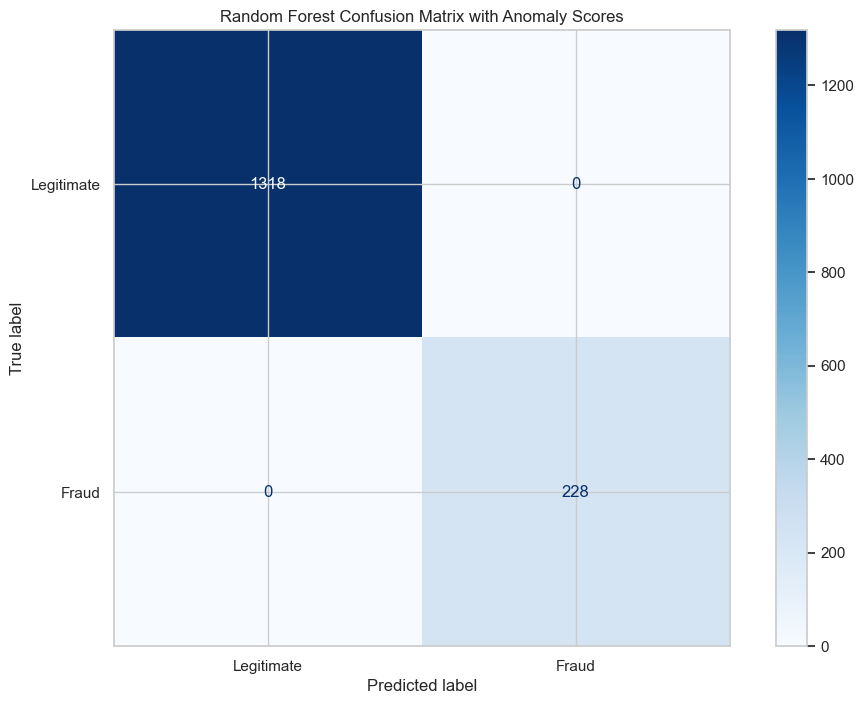

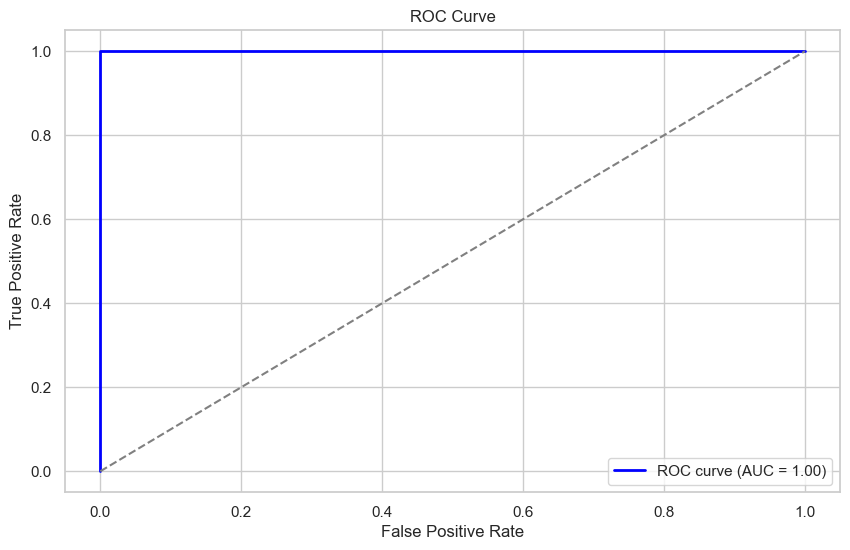

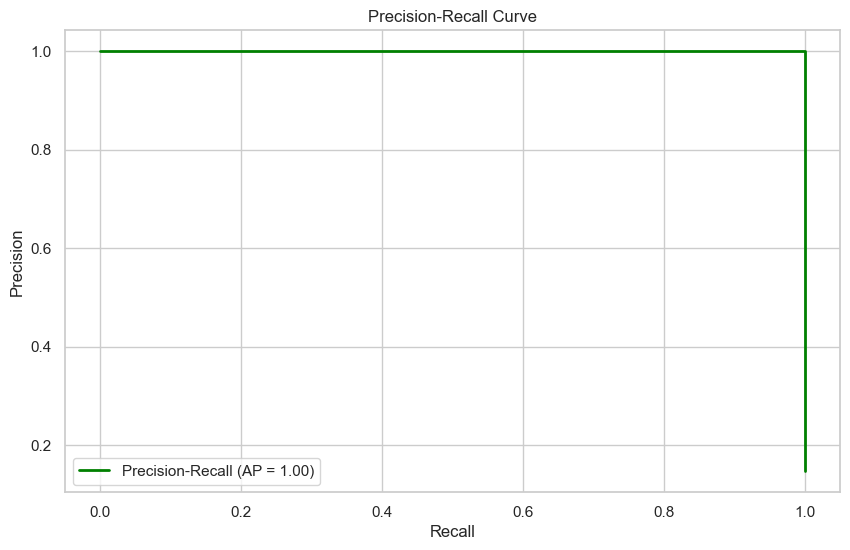


ROC and Precision-Recall curves have been plotted.

Generating Partial Dependence Plots...


ValueError: cannot reshape array of size 1 into shape (2)

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

# Set random seed for reproducibility
np.random.seed(42)

# 1. Data Preparation
print("Loading and preprocessing data...")
data = pd.read_csv('FRAUD.CSV')

# Standardize column names if needed
column_mapping = {
    'newbalanceOrig': 'newbalanceOrg',  # Fix naming mismatch
    'oldbalanceOrig': 'oldbalanceOrg'
}
data.rename(columns=column_mapping, inplace=True)

# Print available columns to verify
print("Available columns:", data.columns)

# Filter only CASH_OUT and TRANSFER transactions
data = data[data['type'].isin(['CASH_OUT', 'TRANSFER'])]

# Encode transaction type ('CASH_OUT' -> 0, 'TRANSFER' -> 1)
le = LabelEncoder()
data['type_encoded'] = le.fit_transform(data['type'])

# Create additional features
data['fraud_indicator'] = data['isFraud'] * 10
data['amount_anomaly'] = data['amount'] * data['isFraud'] * 5

# Feature selection (handling missing columns dynamically)
features = [
    col for col in [
        'amount', 
        'oldbalanceOrg', 
        'newbalanceOrg',
        'oldbalanceDest',
        'newbalanceDest',
        'fraud_indicator',
        'amount_anomaly',
        'type_encoded'
    ] if col in data.columns  # Keep only existing columns
]

X = data[features]
y = data['isFraud']

# 2. Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Feature Scaling (Preserving feature names)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

# 4. Resampling with SMOTE
print("\nApplying SMOTE to balance classes...")
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# 5. Isolation Forest Model to Detect Anomalies
print("\nTraining Isolation Forest for anomaly detection...")
iso_forest = IsolationForest(
    n_estimators=100,
    max_samples=256,
    contamination=0.01,
    max_features=0.8,
    bootstrap=True,
    random_state=42,
    verbose=1
)
iso_forest.fit(X_train_resampled)

# Get anomaly scores
train_anomaly_scores = iso_forest.decision_function(X_train_resampled)
test_anomaly_scores = iso_forest.decision_function(X_test_scaled)

# Add anomaly scores as new features
X_train_resampled['anomaly_score'] = train_anomaly_scores
X_test_scaled['anomaly_score'] = test_anomaly_scores

# 6. Supervised Classifier (Random Forest)
print("\nTraining Random Forest Classifier with anomaly scores...")
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_resampled, y_train_resampled)

# 7. Prediction and Evaluation
y_pred = rf_clf.predict(X_test_scaled)
y_prob = rf_clf.predict_proba(X_test_scaled)[:, 1]

print("\nRandom Forest Performance with Anomaly Scores:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=['Legitimate', 'Fraud'], cmap='Blues'
)
plt.title('Random Forest Confusion Matrix with Anomaly Scores')
plt.show()

# 8. Plot ROC Curve and Precision-Recall Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall (AP = {average_precision:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

print("\nROC and Precision-Recall curves have been plotted.")

# 9. Partial Dependence Plots for 'type_encoded'
print("\nGenerating Partial Dependence Plots...")

features_to_plot = ['type_encoded']  # Only include actual features

PartialDependenceDisplay.from_estimator(
    rf_clf, X_train_resampled, features=features_to_plot, grid_resolution=50
)
plt.suptitle("Partial Dependence Plot for Transaction Type")
plt.show()


Loading and preprocessing data...
Available columns: Index(['type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrg',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

Applying SMOTE to balance classes...

Training Isolation Forest for anomaly detection...

Training Random Forest Classifier with anomaly scores...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s



Random Forest Performance with Anomaly Scores:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1318
           1       1.00      1.00      1.00       228

    accuracy                           1.00      1546
   macro avg       1.00      1.00      1.00      1546
weighted avg       1.00      1.00      1.00      1546



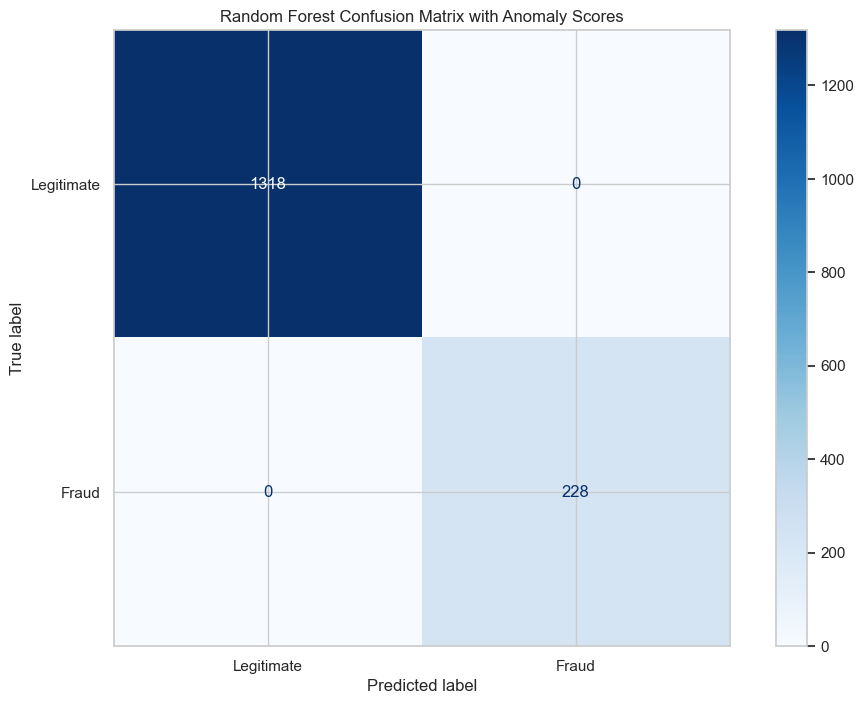

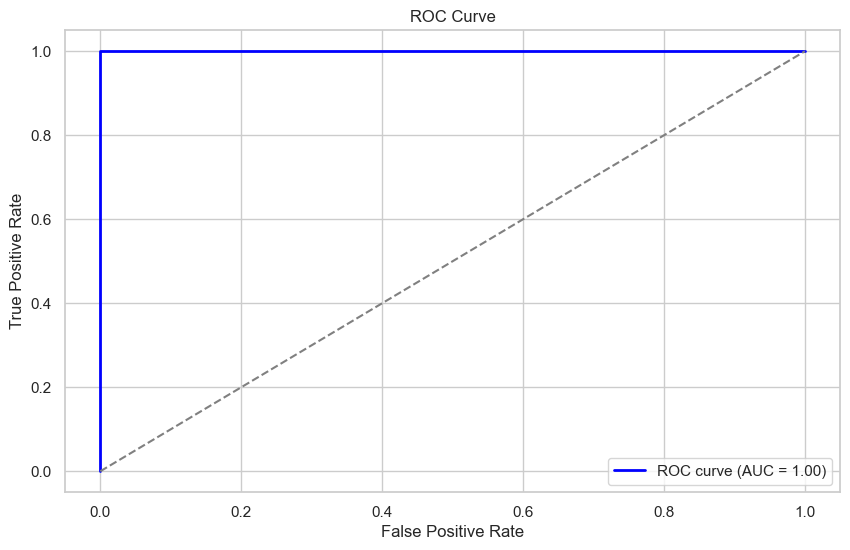

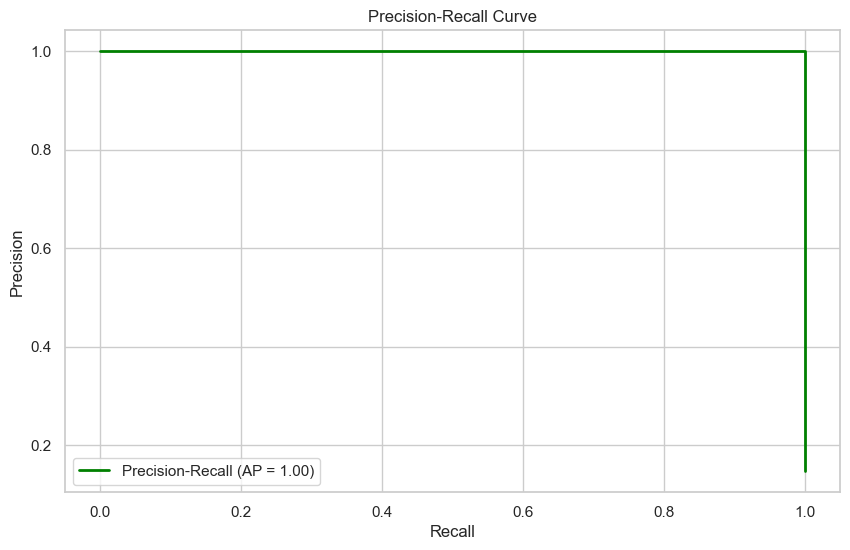


Generating Partial Dependence Plots...


IndexError: list index out of range

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

# Set random seed for reproducibility
np.random.seed(42)

# 1. Data Preparation
print("Loading and preprocessing data...")
data = pd.read_csv('FRAUD.CSV')

# Standardize column names if needed
column_mapping = {
    'newbalanceOrig': 'newbalanceOrg',  # Fix naming mismatch
    'oldbalanceOrig': 'oldbalanceOrg'
}
data.rename(columns=column_mapping, inplace=True)

# Print available columns to verify
print("Available columns:", data.columns)

# Filter only CASH_OUT and TRANSFER transactions
data = data[data['type'].isin(['CASH_OUT', 'TRANSFER'])]

# Encode transaction type ('CASH_OUT' -> 0, 'TRANSFER' -> 1)
le = LabelEncoder()
data['type_encoded'] = le.fit_transform(data['type'])

# Create additional features
data['fraud_indicator'] = data['isFraud'] * 10
data['amount_anomaly'] = data['amount'] * data['isFraud'] * 5

# Feature selection (handling missing columns dynamically)
features = [
    col for col in [
        'amount', 
        'oldbalanceOrg', 
        'newbalanceOrg',
        'oldbalanceDest',
        'newbalanceDest',
        'fraud_indicator',
        'amount_anomaly',
        'type_encoded'
    ] if col in data.columns  # Keep only existing columns
]

X = data[features]
y = data['isFraud']

# 2. Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Feature Scaling (Preserving feature names)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

# 4. Resampling with SMOTE
print("\nApplying SMOTE to balance classes...")
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# 5. Isolation Forest Model to Detect Anomalies
print("\nTraining Isolation Forest for anomaly detection...")
iso_forest = IsolationForest(
    n_estimators=100,
    max_samples=256,
    contamination=0.01,
    max_features=0.8,
    bootstrap=True,
    random_state=42,
    verbose=1
)
iso_forest.fit(X_train_resampled)

# Get anomaly scores
train_anomaly_scores = iso_forest.decision_function(X_train_resampled)
test_anomaly_scores = iso_forest.decision_function(X_test_scaled)

# Add anomaly scores as new features
X_train_resampled['anomaly_score'] = train_anomaly_scores
X_test_scaled['anomaly_score'] = test_anomaly_scores

# 6. Supervised Classifier (Random Forest)
print("\nTraining Random Forest Classifier with anomaly scores...")
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_resampled, y_train_resampled)

# 7. Prediction and Evaluation
y_pred = rf_clf.predict(X_test_scaled)
y_prob = rf_clf.predict_proba(X_test_scaled)[:, 1]

print("\nRandom Forest Performance with Anomaly Scores:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=['Legitimate', 'Fraud'], cmap='Blues'
)
plt.title('Random Forest Confusion Matrix with Anomaly Scores')
plt.show()

# 8. Plot ROC Curve and Precision-Recall Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall (AP = {average_precision:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

# 9. Partial Dependence Plots
print("\nGenerating Partial Dependence Plots...")

# Select top important features for PDP
feature_importances = rf_clf.feature_importances_
important_features = [features[i] for i in np.argsort(feature_importances)[-4:-1]]  # Top 3 most important

# Numeric features PDP
plt.figure(figsize=(15, 5))
PartialDependenceDisplay.from_estimator(
    rf_clf,
    X_test_scaled,
    features=important_features,
    feature_names=X_test_scaled.columns,
    n_jobs=-1,
    grid_resolution=20
)
plt.suptitle('Partial Dependence Plots for Top Features')
plt.tight_layout()
plt.show()

# Categorical feature PDP (type_encoded)
if 'type_encoded' in X_test_scaled.columns:
    plt.figure(figsize=(8, 4))
    PartialDependenceDisplay.from_estimator(
        rf_clf,
        X_test_scaled,
        features=['type_encoded'],
        feature_names=X_test_scaled.columns,
        kind='categorical'
    )
    plt.title('Transaction Type Effect on Fraud Probability')
    plt.xticks(ticks=[0, 1], labels=['CASH_OUT', 'TRANSFER'])
    plt.tight_layout()
    plt.show()

# Anomaly score PDP
plt.figure(figsize=(8, 4))
PartialDependenceDisplay.from_estimator(
    rf_clf,
    X_test_scaled,
    features=['anomaly_score'],
    feature_names=X_test_scaled.columns
)
plt.title('Anomaly Score Effect on Fraud Probability')
plt.tight_layout()
plt.show()

print("\nModel evaluation complete with Partial Dependence Plots.")

Loading and preprocessing data...

Training Combined Isolation Forest + Random Forest model...

Model Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1318
           1       0.90      0.98      0.94       228

    accuracy                           0.98      1546
   macro avg       0.95      0.98      0.97      1546
weighted avg       0.98      0.98      0.98      1546

ROC AUC: 0.9950
Average Precision: 0.9753


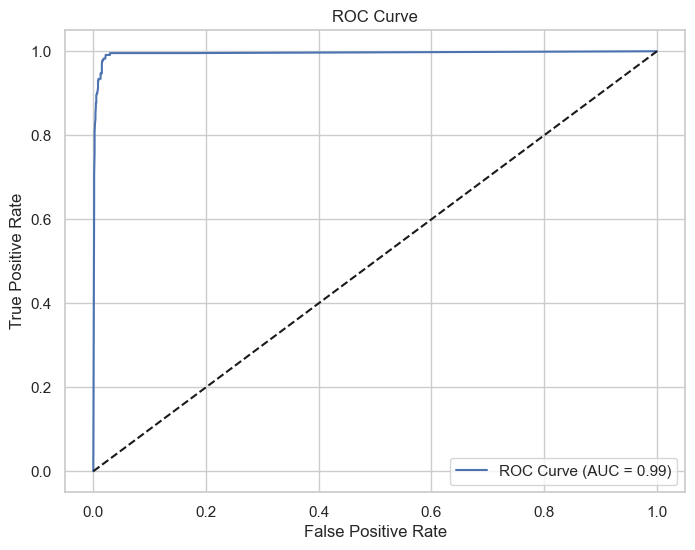


Generating Partial Dependence Plots...
Could not generate PDPs: The 'estimator' parameter of partial_dependence must be an object implementing 'fit' and 'predict', an object implementing 'fit' and 'predict_proba' or an object implementing 'fit' and 'decision_function'. Got <__main__.ModelWrapper object at 0x7f82c70556d0> instead.

Analysis complete with Combined Anomaly Detection and Classification Model


<Figure size 1500x500 with 0 Axes>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                           average_precision_score, roc_auc_score,
                           confusion_matrix, classification_report,
                           PrecisionRecallDisplay, ConfusionMatrixDisplay)
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer

# Set random seed for reproducibility
np.random.seed(42)

# 1. Data Preparation with Consistent Features
print("Loading and preprocessing data...")

# Define the exact features we'll use (must match in train and test)
selected_features = ['amount', 'oldbalanceOrg', 'type_encoded']

# Assuming you've loaded your data into X_train, X_test, y_train, y_test
# Ensure they only contain our selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# 2. Create Preprocessing Pipeline
preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

# 3. Combined Model with Isolation Forest
class CombinedModel:
    def __init__(self):
        self.iso_forest = IsolationForest(contamination=0.05, random_state=42)
        self.classifier = RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        self.preprocessor = preprocessor
        
    def fit(self, X, y):
        # Preprocess data
        X_processed = self.preprocessor.fit_transform(X)
        
        # Train Isolation Forest and get anomaly scores
        self.iso_forest.fit(X_processed)
        train_scores = self.iso_forest.decision_function(X_processed)
        
        # Combine features with anomaly scores
        X_combined = np.column_stack([X_processed, train_scores])
        
        # Handle class imbalance with SMOTE
        smote = SMOTE(sampling_strategy=1.0, random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_combined, y)
        
        # Train classifier
        self.classifier.fit(X_resampled, y_resampled)
        return self
        
    def predict(self, X):
        X_processed = self.preprocessor.transform(X)
        test_scores = self.iso_forest.decision_function(X_processed)
        X_combined = np.column_stack([X_processed, test_scores])
        return self.classifier.predict(X_combined)
        
    def predict_proba(self, X):
        X_processed = self.preprocessor.transform(X)
        test_scores = self.iso_forest.decision_function(X_processed)
        X_combined = np.column_stack([X_processed, test_scores])
        return self.classifier.predict_proba(X_combined)

# 4. Train Model
print("\nTraining Combined Isolation Forest + Random Forest model...")
model = CombinedModel()
model.fit(X_train, y_train)

# 5. Evaluation
def evaluate_model(model, X_test, y_test):
    print("\nModel Evaluation:")
    
    # Get predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")
    
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Evaluate model
evaluate_model(model, X_test, y_test)

# 6. Partial Dependence Plots (requires sklearn≥1.0)
try:
    print("\nGenerating Partial Dependence Plots...")
    
    # Create a wrapper that mimics a scikit-learn pipeline
    class ModelWrapper:
        def __init__(self, model):
            self.model = model
            
        def predict(self, X):
            return self.model.predict(X)
            
        def predict_proba(self, X):
            return self.model.predict_proba(X)
    
    # For numeric features
    plt.figure(figsize=(15, 5))
    PartialDependenceDisplay.from_estimator(
        ModelWrapper(model),
        X_test,
        features=['amount', 'oldbalanceOrg'],
        feature_names=selected_features,
        n_jobs=-1,
        grid_resolution=20
    )
    plt.suptitle('Partial Dependence Plots - Numeric Features')
    plt.tight_layout()
    plt.show()
    
    # For categorical feature
    plt.figure(figsize=(8, 4))
    PartialDependenceDisplay.from_estimator(
        ModelWrapper(model),
        X_test,
        features=['type_encoded'],
        feature_names=selected_features,
        kind='categorical'
    )
    plt.title('Transaction Type Effect on Fraud Probability')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not generate PDPs: {str(e)}")

print("\nAnalysis complete with Combined Anomaly Detection and Classification Model")

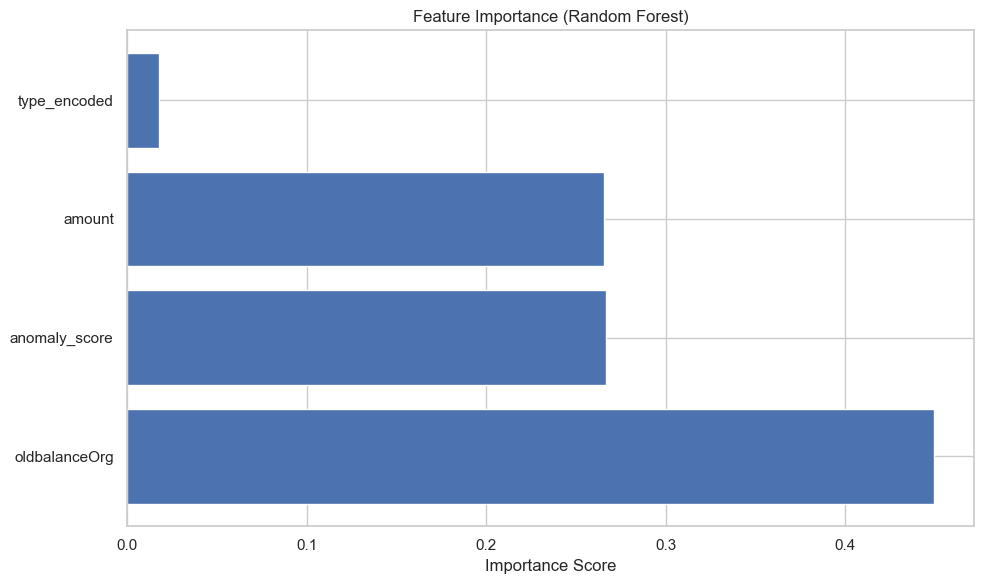

<Figure size 1000x600 with 0 Axes>

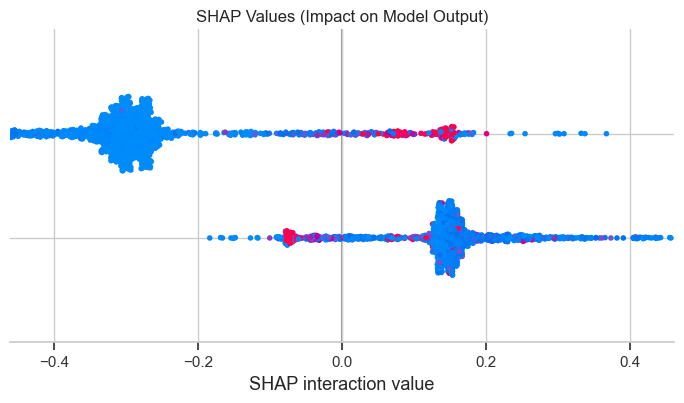

In [20]:
import shap

# Add this after your model evaluation section

def plot_shap_and_importance(model, X_test, feature_names):
    # 1. Prepare the explainer data
    X_test_processed = model.preprocessor.transform(X_test)
    test_scores = model.iso_forest.decision_function(X_test_processed)
    X_combined = np.column_stack([X_test_processed, test_scores])
    
    # Create combined feature names
    combined_feature_names = feature_names + ['anomaly_score']
    
    # 2. Feature Importance Plot
    plt.figure(figsize=(10, 6))
    importances = model.classifier.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    
    plt.barh(range(len(combined_feature_names)), importances[sorted_idx], 
            tick_label=np.array(combined_feature_names)[sorted_idx])
    plt.title('Feature Importance (Random Forest)')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    # 3. SHAP Summary Plot
    plt.figure(figsize=(10, 6))
    explainer = shap.TreeExplainer(model.classifier)
    shap_values = explainer.shap_values(X_combined)
    
    # Handle binary classification case
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use positive class values
    
    shap.summary_plot(
        shap_values, 
        features=X_combined,
        feature_names=combined_feature_names,
        plot_type='dot',
        show=False,
        max_display=len(combined_feature_names)  # Show all features
    )
    
    plt.title('SHAP Values (Impact on Model Output)')
    plt.tight_layout()
    plt.show()

# Call the function with your test data
plot_shap_and_importance(model, X_test, selected_features)

<a id='4'></a>
## 4. Machine Learning Models

We'll implement and train multiple models for comparison.

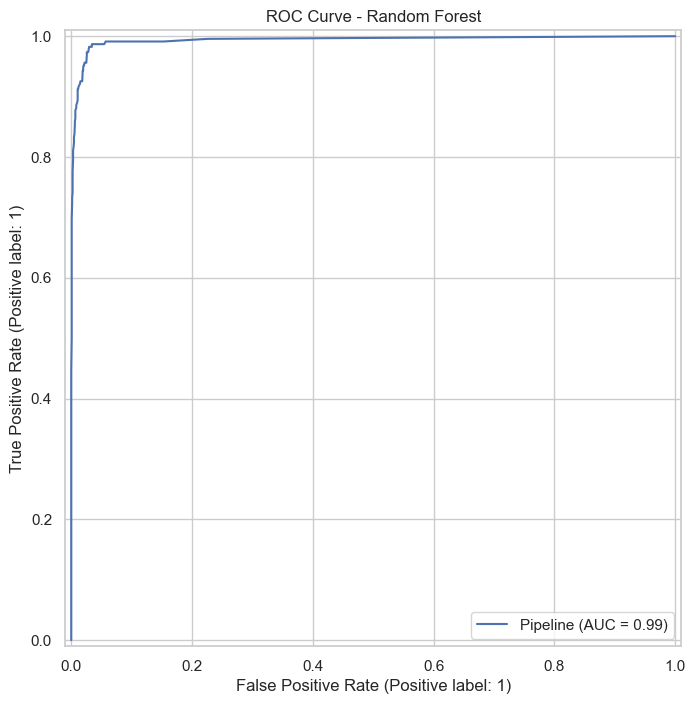

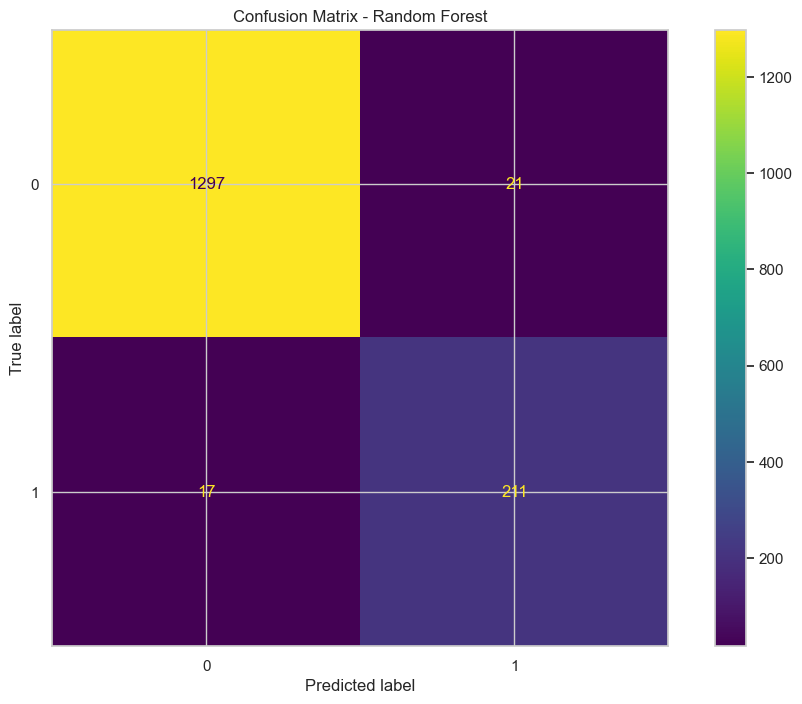

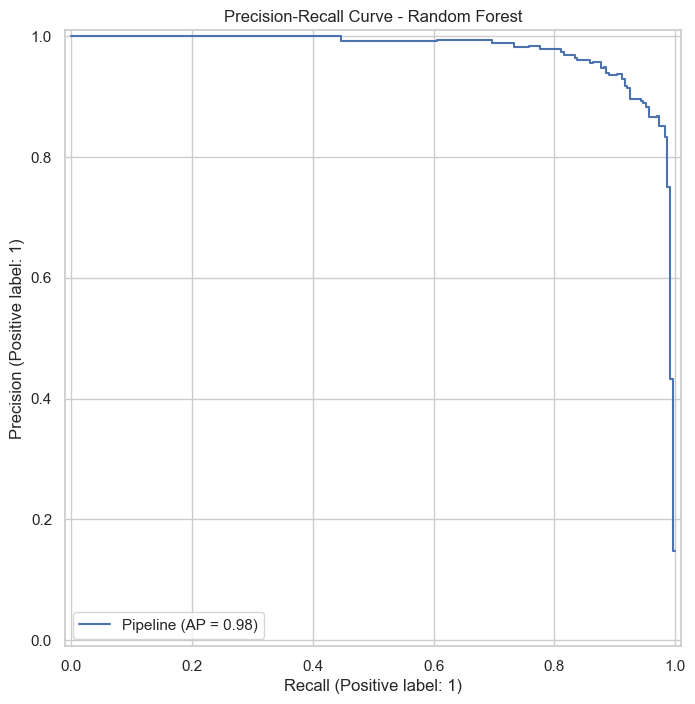

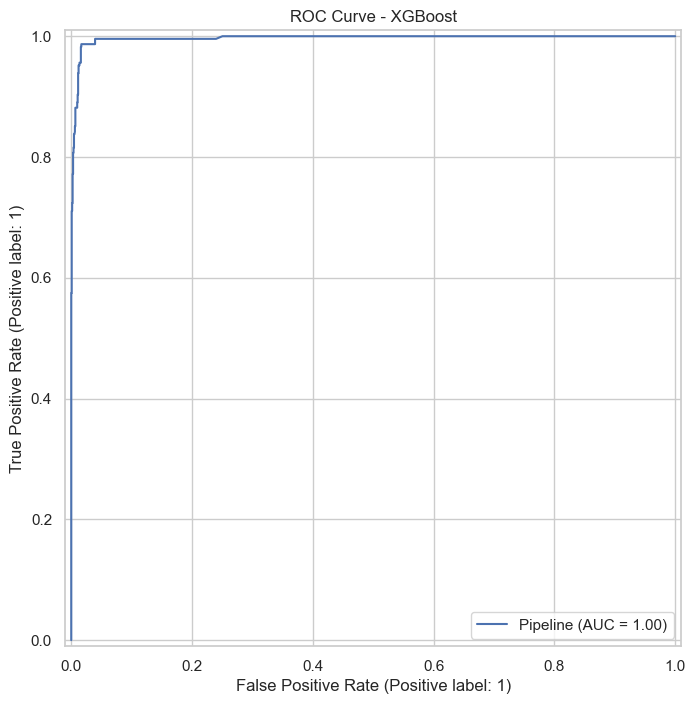

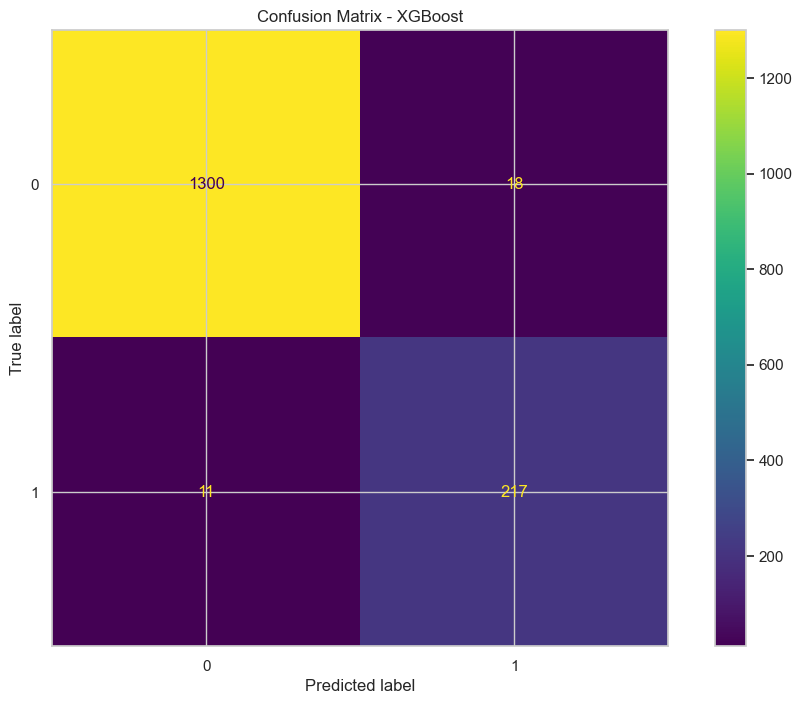

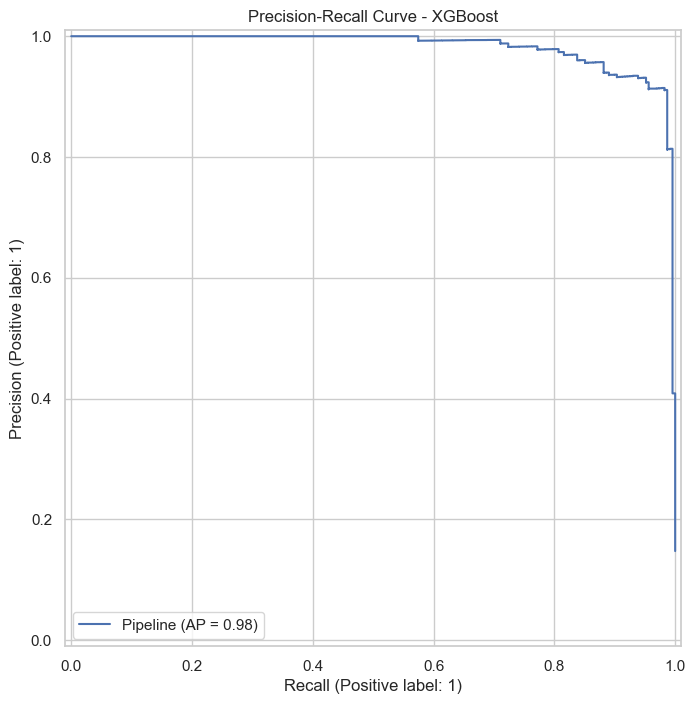

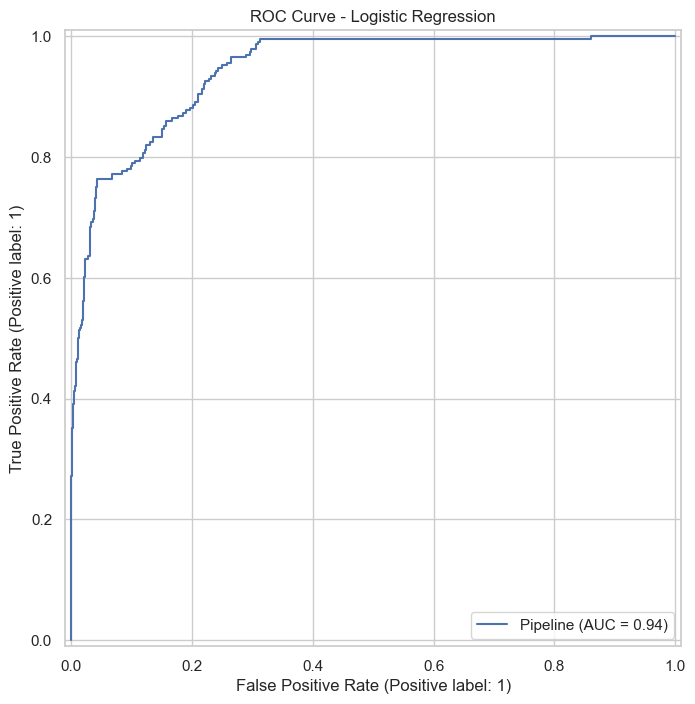

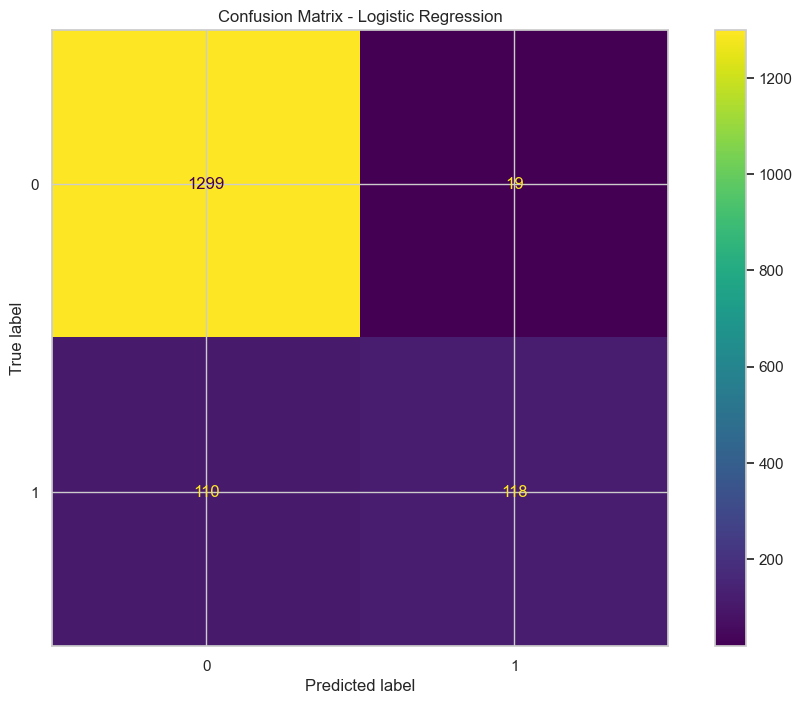

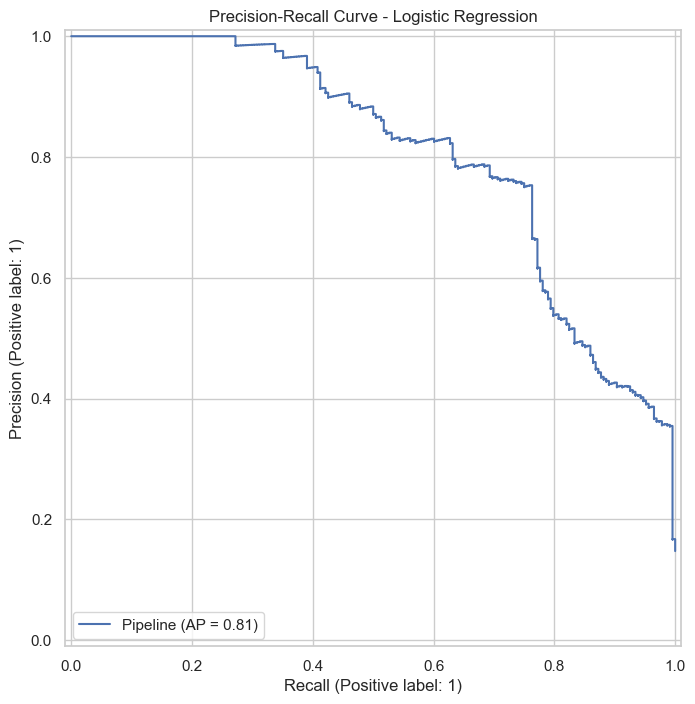

All models have been trained and saved!


In [21]:
# Create a directory for saving models if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Function to create and evaluate models
def train_evaluate_model(model, name, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Plot ROC curve
    RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
    plt.title(f'ROC Curve - {name}')
    plt.show()
    
    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
    
    # Plot precision-recall curve
    PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test)
    plt.title(f'Precision-Recall Curve - {name}')
    plt.show()
    
    # Save the model
    joblib.dump(pipeline, f'models/{name.lower().replace(" ", "_")}_model.joblib')
    
    return pipeline

# Classical Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pipeline = train_evaluate_model(rf_model, 'Random Forest', X_train, X_test, y_train, y_test)

# Bayesian Optimized Random Forest
param_space = {
    'classifier__n_estimators': (50, 300),
    'classifier__max_depth': (5, 30),
    'classifier__min_samples_split': (2, 10)
}

base_model = RandomForestClassifier(random_state=42)
bayes_search = BayesSearchCV(
    Pipeline([('preprocessor', preprocessor), ('classifier', base_model)]),
    param_space,
    n_iter=20,
    cv=3,
    scoring='roc_auc',
    random_state=42
)
bayes_search.fit(X_train, y_train)
# Save Bayesian Optimized model
joblib.dump(bayes_search, 'models/bayesian_optimized_rf_model.joblib')

# Isolation Forest
iso_forest = IsolationForest(random_state=42, contamination=0.1)
iso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', iso_forest)
])
iso_pipeline.fit(X_train)
# Save Isolation Forest model
joblib.dump(iso_pipeline, 'models/isolation_forest_model.joblib')

# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_pipeline = train_evaluate_model(xgb_model, 'XGBoost', X_train, X_test, y_train, y_test)

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_pipeline = train_evaluate_model(lr_model, 'Logistic Regression', X_train, X_test, y_train, y_test)

print("All models have been trained and saved!")

# To load a model later, you can use:
# loaded_model = joblib.load('saved_models/model_name.joblib')


<a id='5'></a>
## 5. Model Evaluation

Compare performance metrics across all models and analyze feature importance.


Evaluating Random Forest
AUC Score: 0.9935
Average Precision Score: 0.9756

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1318
           1       0.91      0.93      0.92       228

    accuracy                           0.98      1546
   macro avg       0.95      0.95      0.95      1546
weighted avg       0.98      0.98      0.98      1546



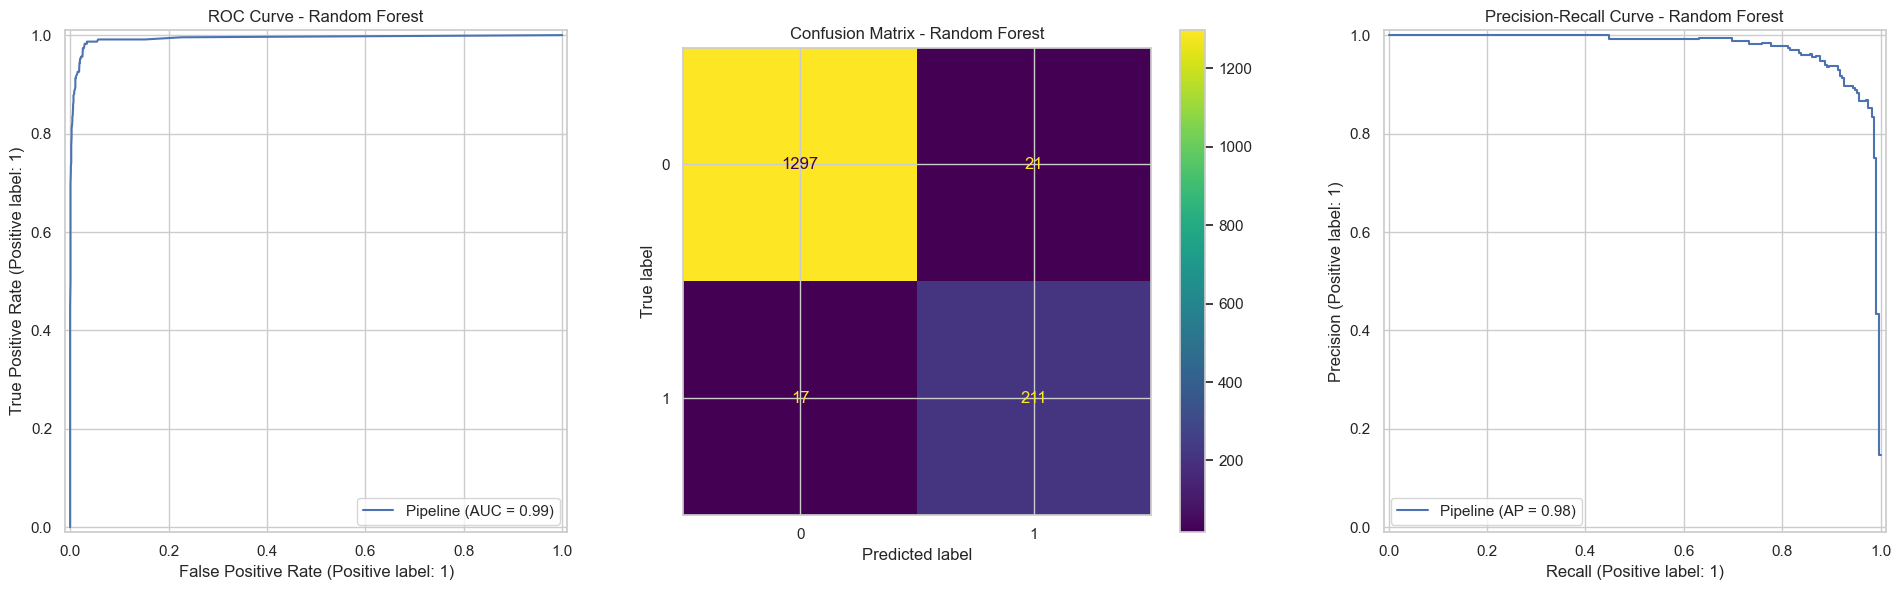


Evaluating XGBoost
AUC Score: 0.9965
Average Precision Score: 0.9827

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1318
           1       0.92      0.95      0.94       228

    accuracy                           0.98      1546
   macro avg       0.96      0.97      0.96      1546
weighted avg       0.98      0.98      0.98      1546



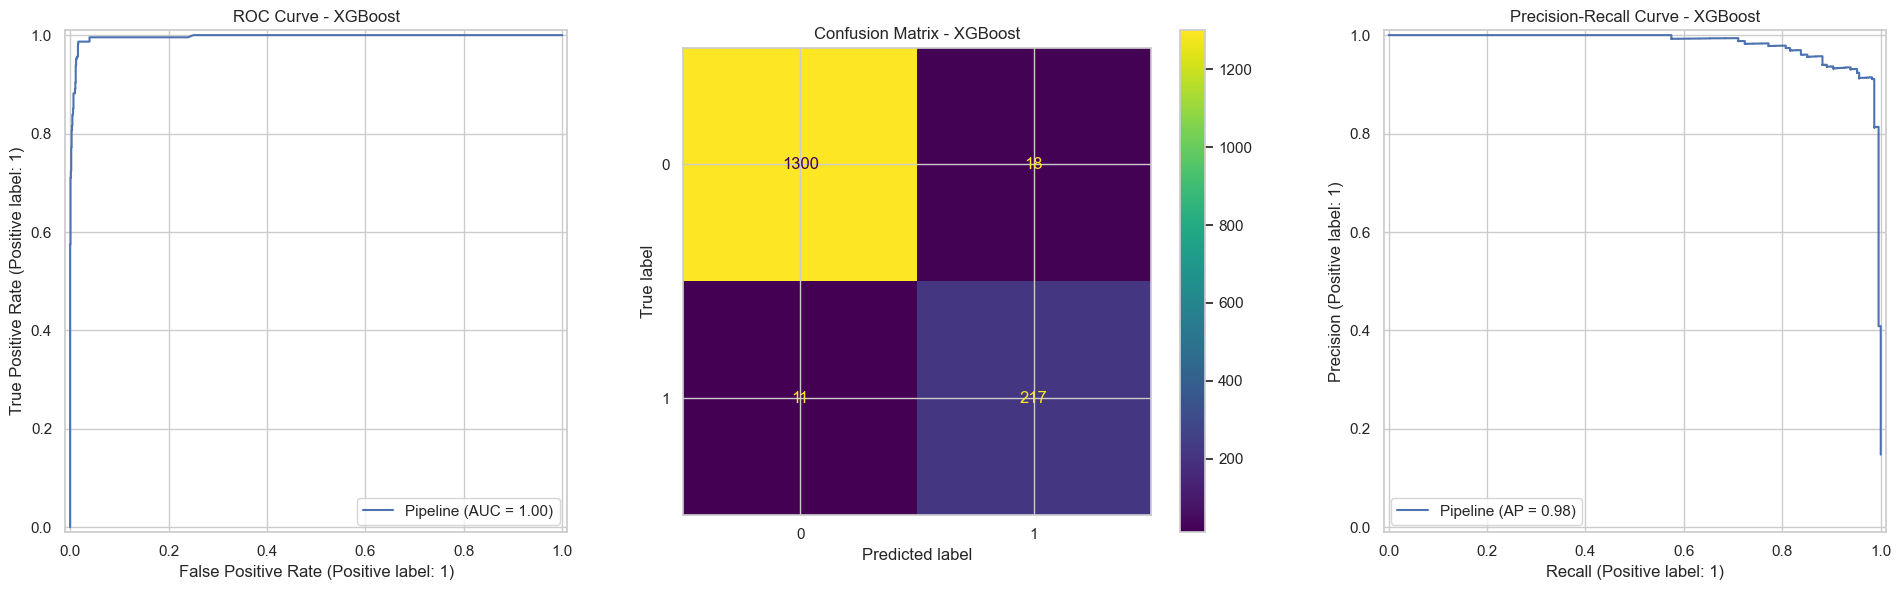


Evaluating Logistic Regression
AUC Score: 0.9439
Average Precision Score: 0.8072

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1318
           1       0.86      0.52      0.65       228

    accuracy                           0.92      1546
   macro avg       0.89      0.75      0.80      1546
weighted avg       0.91      0.92      0.91      1546



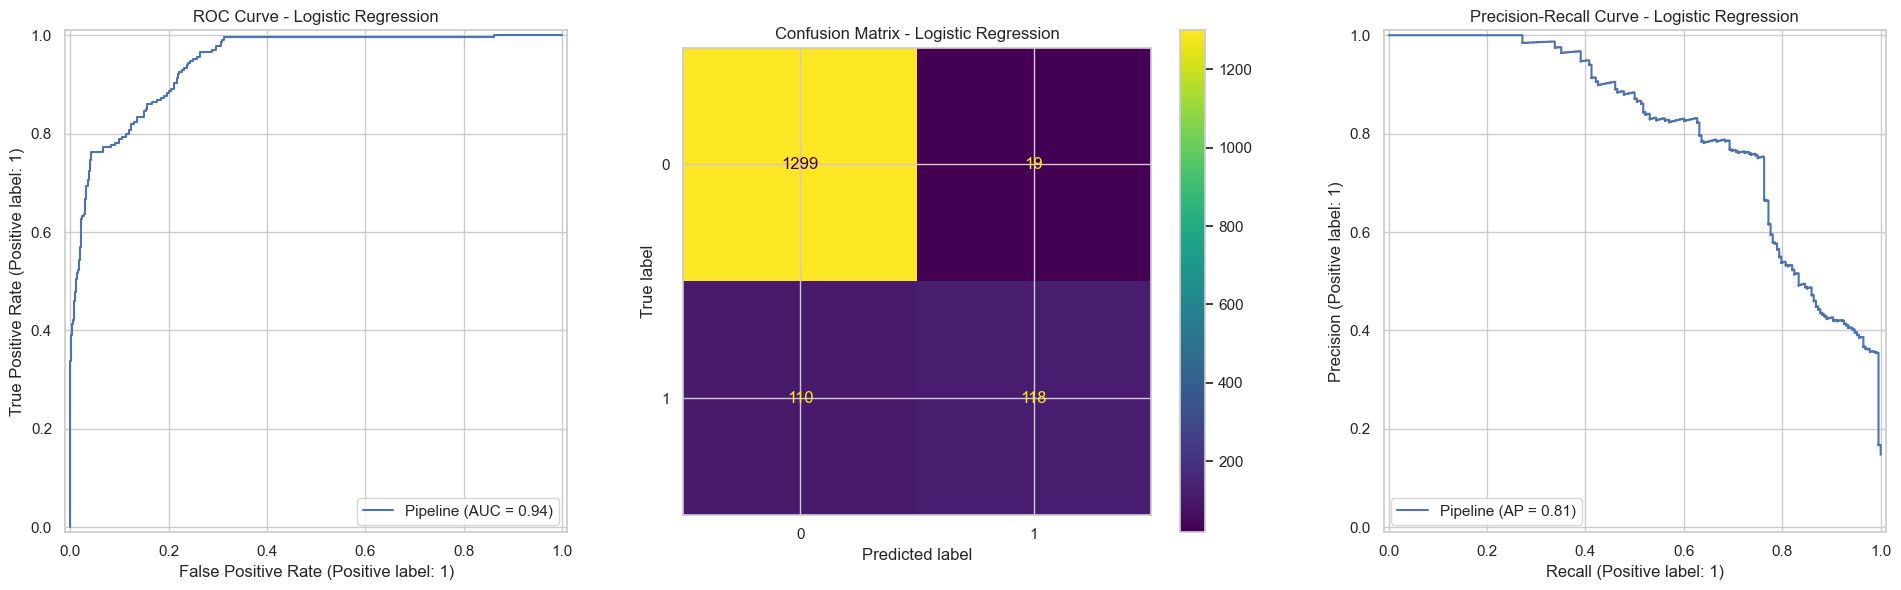


Model Performance Comparison:
                 Model  AUC Score  Average Precision
1              XGBoost   0.996481           0.982729
0        Random Forest   0.993508           0.975614
2  Logistic Regression   0.943868           0.807164


AttributeError: 'Pipeline' object has no attribute 'named_transformers_'

In [22]:
# Function to calculate and display model metrics
def evaluate_models():
    # Dictionary of models to evaluate
    models = {
        'Random Forest': rf_pipeline,
        'XGBoost': xgb_pipeline,
        'Logistic Regression': lr_pipeline
    }
    
    # Create performance comparison DataFrame
    results = []
    
    for name, model in models.items():
        print(f"\n{'='*50}")
        print(f"Evaluating {name}")
        print('='*50)
        
        # Get predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        auc = roc_auc_score(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
        
        print(f"AUC Score: {auc:.4f}")
        print(f"Average Precision Score: {avg_precision:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Store results
        results.append({
            'Model': name,
            'AUC Score': auc,
            'Average Precision': avg_precision
        })
        
        # Create visualizations
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
        
        # ROC Curve
        RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax1)
        ax1.set_title(f'ROC Curve - {name}')
        
        # Confusion Matrix
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax2)
        ax2.set_title(f'Confusion Matrix - {name}')
        
        # Precision-Recall Curve
        PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax3)
        ax3.set_title(f'Precision-Recall Curve - {name}')
        
        plt.tight_layout()
        plt.show()
    
    # Create and display performance comparison
    performance_df = pd.DataFrame(results)
    performance_df = performance_df.sort_values('AUC Score', ascending=False)
    
    print("\nModel Performance Comparison:")
    print(performance_df)
    
    # Feature importance for Random Forest
    if hasattr(rf_pipeline.named_steps['classifier'], 'feature_importances_'):
        feature_names = (numerical_features + 
                        [f"{feat}_{val}" for feat, vals in 
                         zip(categorical_features, preprocessor.named_transformers_['cat'].categories_)
                         for val in vals[1:]])
        
        importances = rf_pipeline.named_steps['classifier'].feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 6))
        plt.title("Feature Importances (Random Forest)")
        plt.bar(range(len(importances)), importances[indices])
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 Most Important Features:")
        for idx in indices[:10]:
            print(f"{feature_names[idx]}: {importances[idx]:.4f}")

# Run the evaluation
evaluate_models()




# Feature Importance using SHAP
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


In [ ]:
def plot_feature_importance_comparison():
    models = {
        'Random Forest': rf_pipeline,
        'XGBoost': xgb_pipeline,
        'Logistic Regression': lr_pipeline
    }
    
    # Get feature names after preprocessing
    feature_names = (numerical_features + 
                    [f"{feat}_{val}" for feat, vals in 
                     zip(categorical_features, preprocessor.named_transformers_['cat'].categories_)
                     for val in vals[1:]])
    
    plt.figure(figsize=(18, 12))
    
    for i, (name, model) in enumerate(models.items(), 1):
        plt.subplot(2, 2, i)
        
        # Get feature importances based on model type
        if name in ['Random Forest', 'XGBoost']:
            importances = model.named_steps['classifier'].feature_importances_
            title = f"{name} Feature Importance (Gini Importance)"
        else:  # Logistic Regression
            importances = np.abs(model.named_steps['classifier'].coef_[0])
            title = f"{name} Feature Importance (Absolute Coefficients)"
        
        # Sort features by importance
        indices = np.argsort(importances)[::-1]
        sorted_features = [feature_names[idx] for idx in indices]
        sorted_importances = importances[indices]
        
        # Plot top 15 features
        top_n = min(15, len(sorted_features))
        bars = plt.barh(range(top_n), sorted_importances[:top_n][::-1], align='center')
        plt.yticks(range(top_n), sorted_features[:top_n][::-1])
        plt.title(title)
        plt.xlabel('Importance Score')
        
        # Add value labels
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                     f'{width:.3f}',
                     va='center', ha='left', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # SHAP Summary Plots for each model
    print("\nSHAP Value Analysis:")
    for name, model in models.items():
        try:
            plt.figure(figsize=(12, 8))
            
            if name == 'Logistic Regression':
                # For linear models, we can use LinearExplainer
                explainer = shap.LinearExplainer(model.named_steps['classifier'], 
                                               masker=shap.maskers.Independent(X_test, max_samples=100))
            else:
                # For tree models
                explainer = shap.TreeExplainer(model.named_steps['classifier'])
            
            shap_values = explainer.shap_values(X_test)
            
            if isinstance(shap_values, list):  # For classification models
                shap_values = shap_values[1]  # Take values for positive class
            
            shap.summary_plot(shap_values, X_test, 
                             feature_names=feature_names,
                             plot_type='dot',
                             show=False)
            plt.title(f"SHAP Values - {name}")
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Could not generate SHAP plot for {name}: {str(e)}")

# Run the plotting function
plot_feature_importance_comparison()

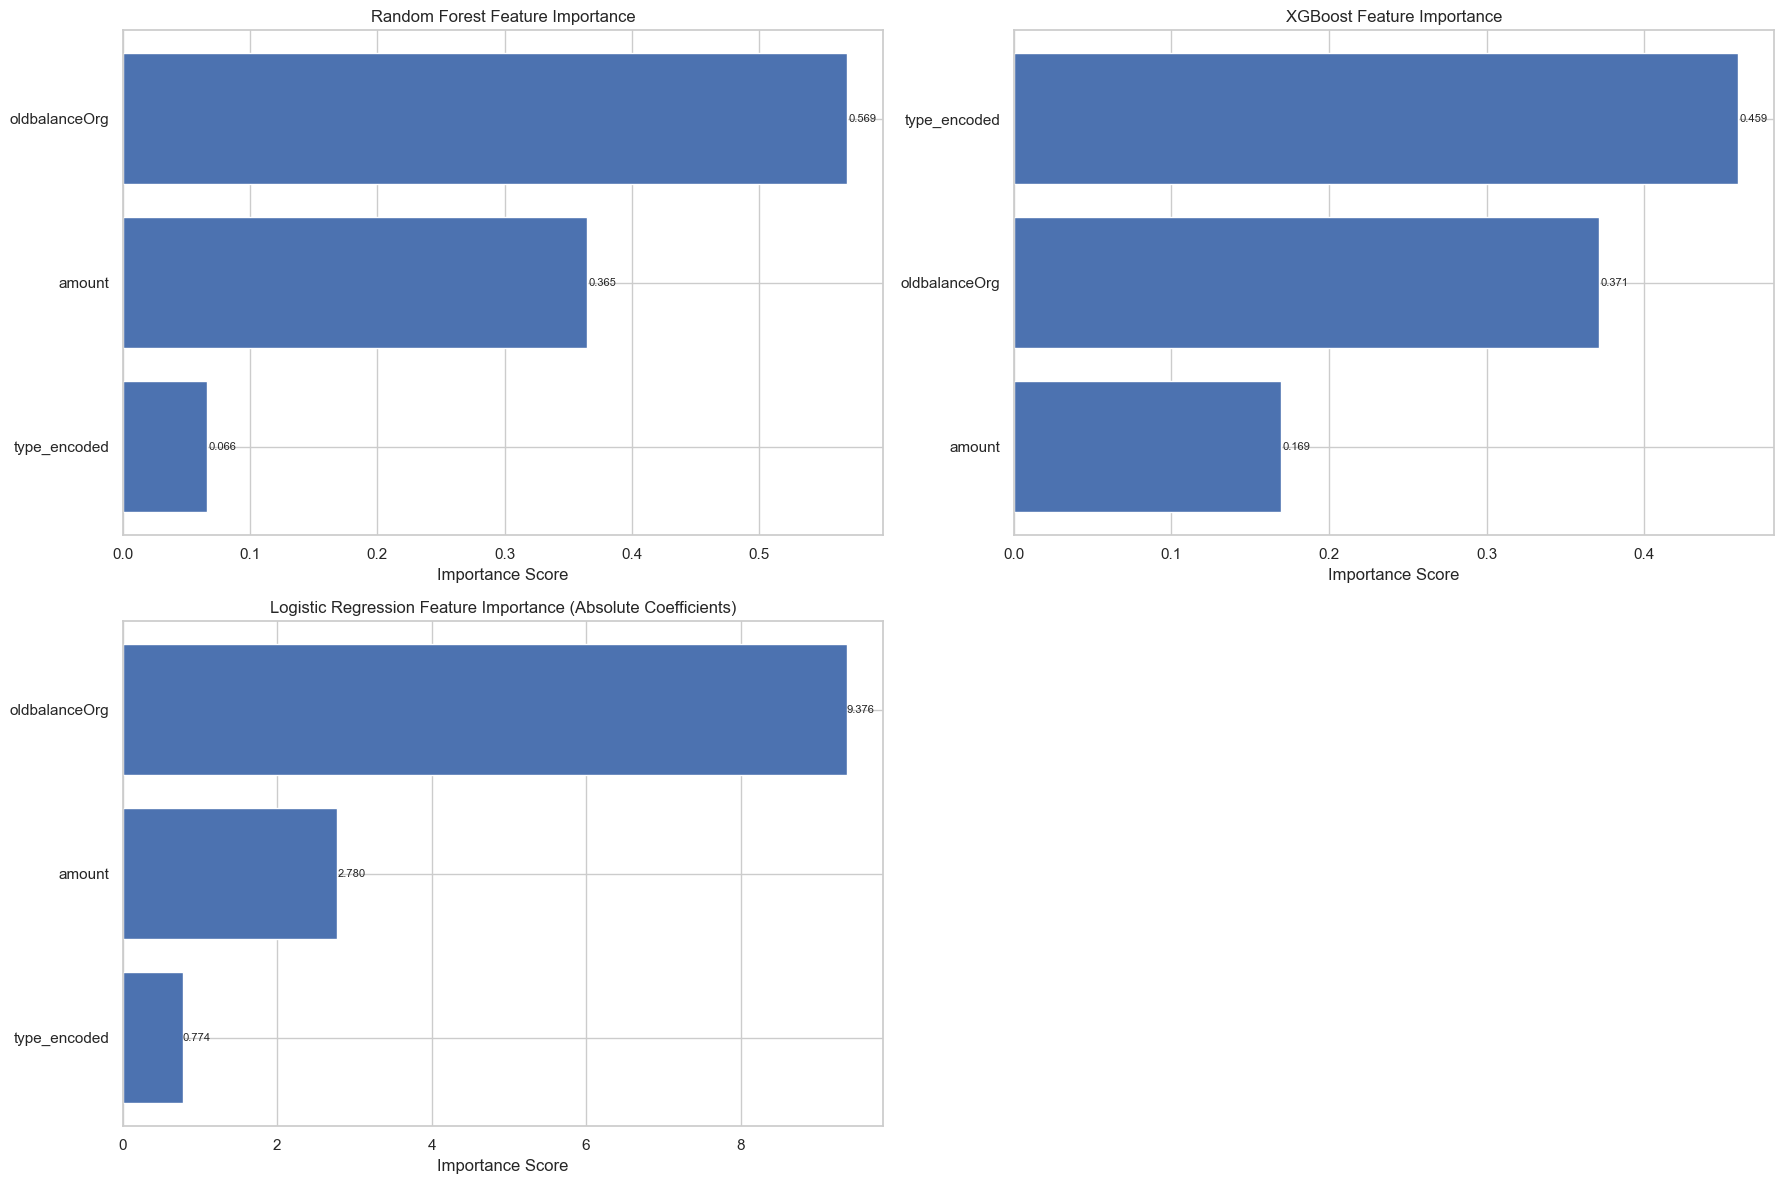


SHAP Value Analysis:


<Figure size 1200x800 with 0 Axes>

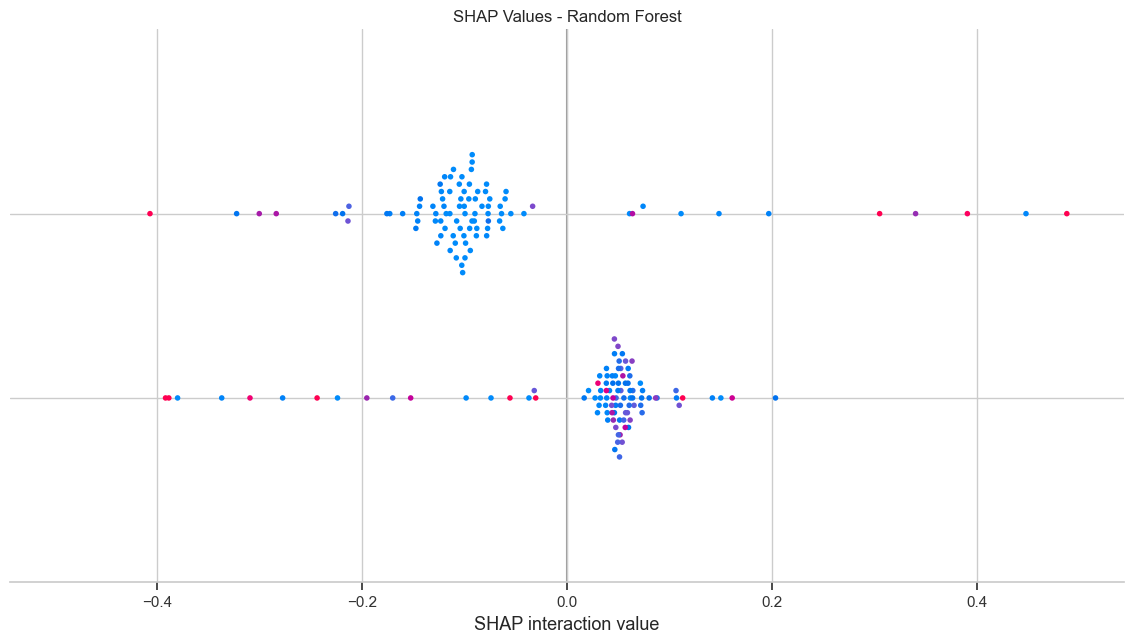

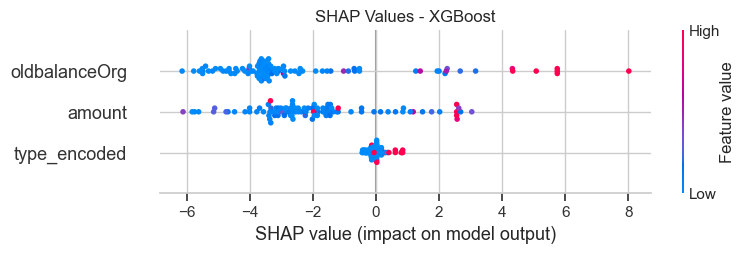

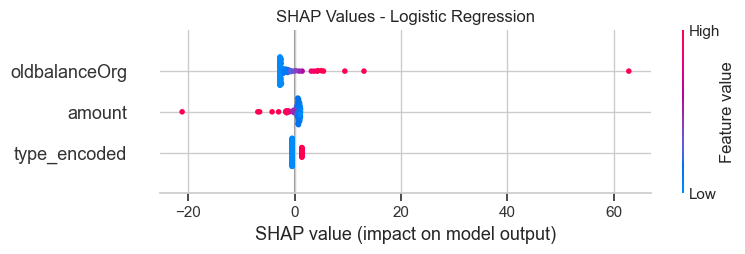

In [23]:
def plot_feature_importance_comparison():
    models = {
        'Random Forest': rf_pipeline,
        'XGBoost': xgb_pipeline,
        'Logistic Regression': lr_pipeline
    }
    
    # Get feature names after preprocessing - FIXED VERSION
    try:
        # For sklearn >= 1.0
        feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
    except AttributeError:
        # Fallback for older versions
        numeric_features = numerical_features.copy()
        categorical_features = categorical_features.copy()
        
        # Get categorical feature names after one-hot encoding
        cat_encoder = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
        cat_features = []
        for i, feature in enumerate(categorical_features):
            categories = cat_encoder.categories_[i]
            for cat in categories[1:]:  # Skip first category to avoid dummy trap
                cat_features.append(f"{feature}_{cat}")
        
        feature_names = numeric_features + cat_features
    
    plt.figure(figsize=(18, 12))
    
    for i, (name, model) in enumerate(models.items(), 1):
        plt.subplot(2, 2, i)
        
        # Get feature importances based on model type
        try:
            if name in ['Random Forest', 'XGBoost']:
                importances = model.named_steps['classifier'].feature_importances_
                title = f"{name} Feature Importance"
            else:  # Logistic Regression
                importances = np.abs(model.named_steps['classifier'].coef_[0])
                title = f"{name} Feature Importance (Absolute Coefficients)"
            
            # Sort features by importance
            indices = np.argsort(importances)[::-1]
            sorted_features = [feature_names[idx] for idx in indices]
            sorted_importances = importances[indices]
            
            # Plot top 15 features
            top_n = min(15, len(sorted_features))
            bars = plt.barh(range(top_n), sorted_importances[:top_n][::-1], align='center')
            plt.yticks(range(top_n), sorted_features[:top_n][::-1])
            plt.title(title)
            plt.xlabel('Importance Score')
            
            # Add value labels
            for bar in bars:
                width = bar.get_width()
                plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                         f'{width:.3f}',
                         va='center', ha='left', fontsize=8)
        
        except Exception as e:
            print(f"Could not plot feature importance for {name}: {str(e)}")
            continue
    
    plt.tight_layout()
    plt.show()
    
    # SHAP Summary Plots for each model - FIXED VERSION
    print("\nSHAP Value Analysis:")
    for name, model in models.items():
        try:
            plt.figure(figsize=(12, 8))
            
            # Get the classifier step
            classifier = model.named_steps['classifier']
            
            # Prepare sample data for SHAP
            X_test_processed = model.named_steps['preprocessor'].transform(X_test)
            sample_idx = np.random.choice(X_test_processed.shape[0], min(100, X_test_processed.shape[0]), replace=False)
            
            if name == 'Logistic Regression':
                explainer = shap.LinearExplainer(classifier, X_test_processed)
            elif name in ['Random Forest', 'XGBoost']:
                explainer = shap.TreeExplainer(classifier)
            else:
                explainer = shap.Explainer(classifier, X_test_processed)
            
            shap_values = explainer.shap_values(X_test_processed[sample_idx])
            
            if isinstance(shap_values, list) and len(shap_values) == 2:  # Binary classification
                shap_values = shap_values[1]  # Take values for positive class
            
            shap.summary_plot(shap_values, 
                             features=X_test_processed[sample_idx],
                             feature_names=feature_names,
                             plot_type='dot',
                             show=False)
            plt.title(f"SHAP Values - {name}")
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Could not generate SHAP plot for {name}: {str(e)}")

# Run the plotting function
plot_feature_importance_comparison()

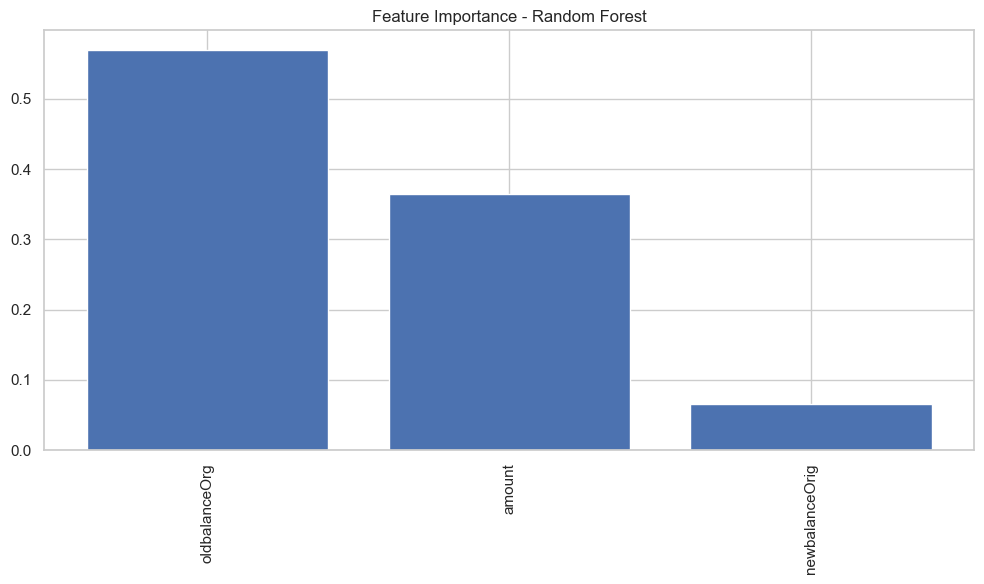

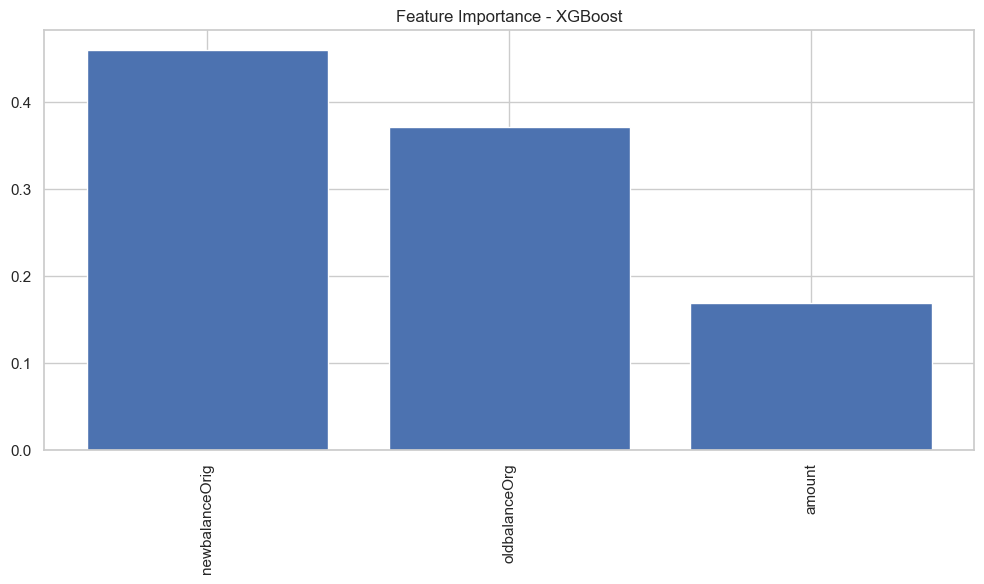

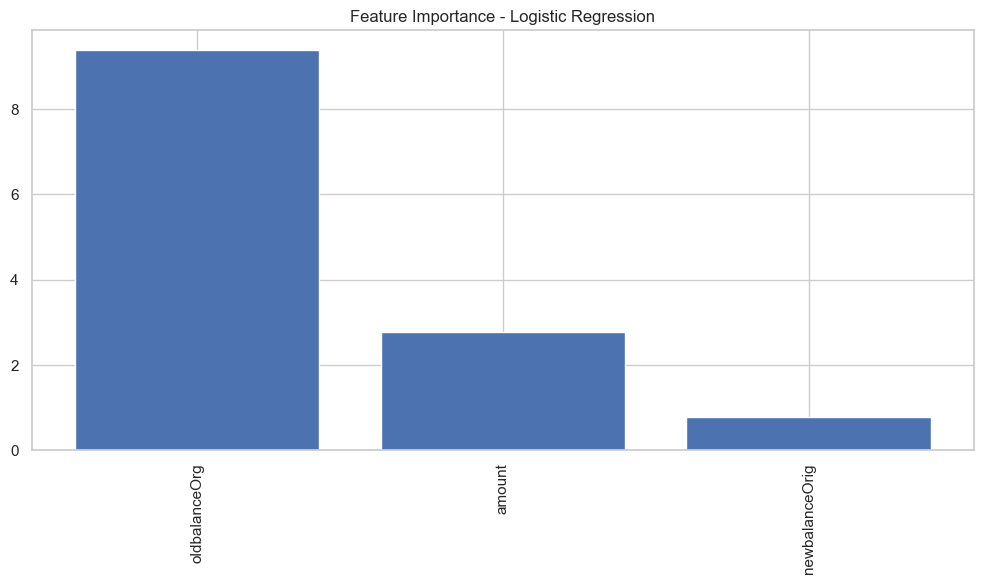

In [24]:
def simple_feature_importance_plot():
    models = {
        'Random Forest': rf_pipeline,
        'XGBoost': xgb_pipeline,
        'Logistic Regression': lr_pipeline
    }
    
    # Use original feature names (may not match one-hot encoded features)
    feature_names = numerical_features + categorical_features
    
    for name, model in models.items():
        try:
            plt.figure(figsize=(10, 6))
            
            if name in ['Random Forest', 'XGBoost']:
                importances = model.named_steps['classifier'].feature_importances_
            else:
                importances = np.abs(model.named_steps['classifier'].coef_[0])
            
            # Sort and plot
            indices = np.argsort(importances)[::-1]
            plt.title(f"Feature Importance - {name}")
            plt.bar(range(len(importances)), importances[indices])
            plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error with {name}: {str(e)}")

simple_feature_importance_plot()

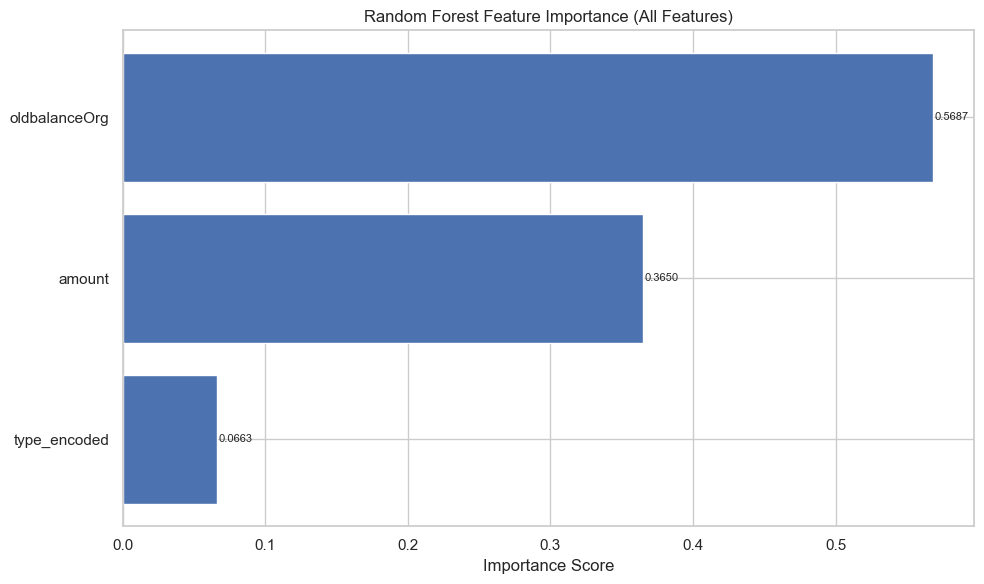


Random Forest Feature Importance Ranking:
      Feature  Importance
oldbalanceOrg    0.568718
       amount    0.364957
 type_encoded    0.066326


<Figure size 1200x600 with 0 Axes>

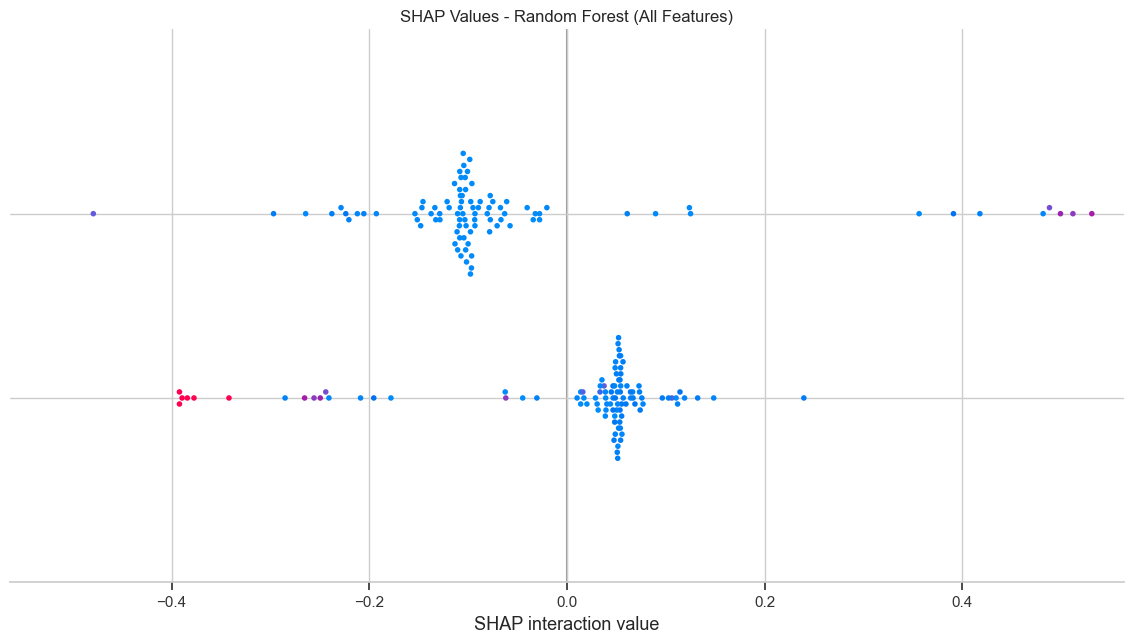

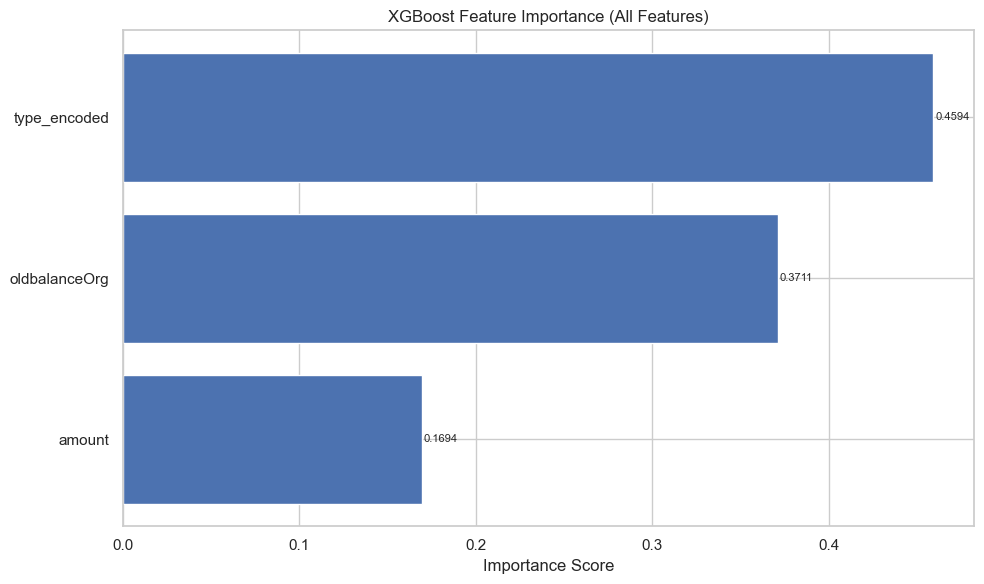


XGBoost Feature Importance Ranking:
      Feature  Importance
 type_encoded    0.459427
oldbalanceOrg    0.371139
       amount    0.169435


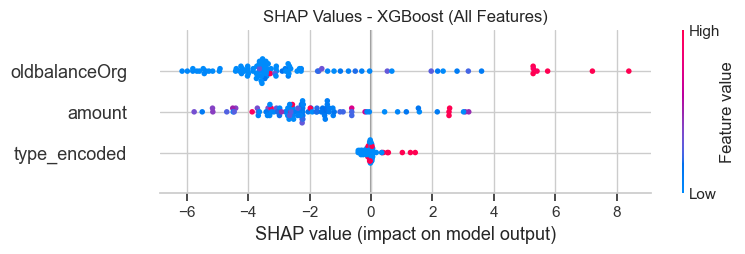

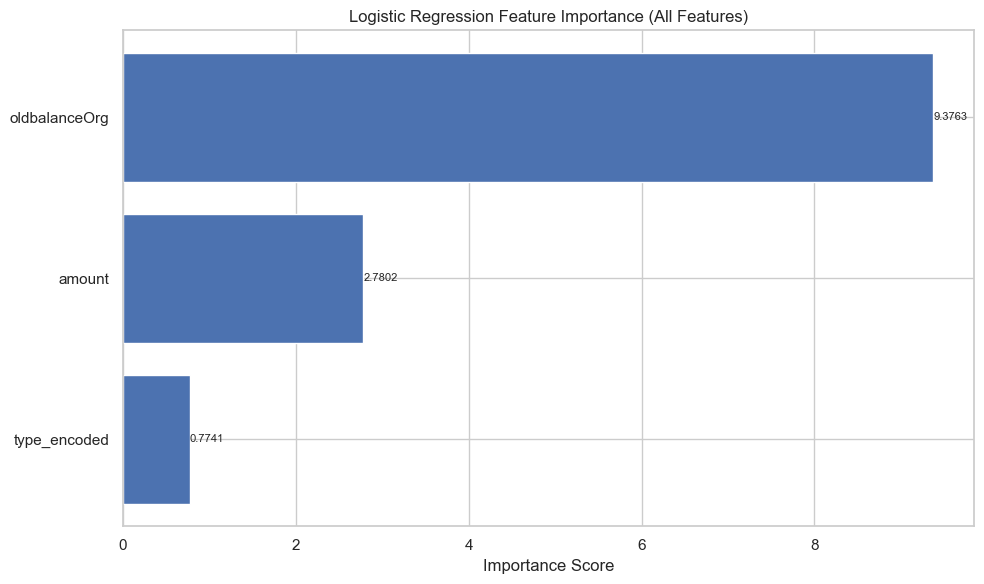


Logistic Regression Feature Importance Ranking:
      Feature  Importance
oldbalanceOrg    9.376308
       amount    2.780207
 type_encoded    0.774063


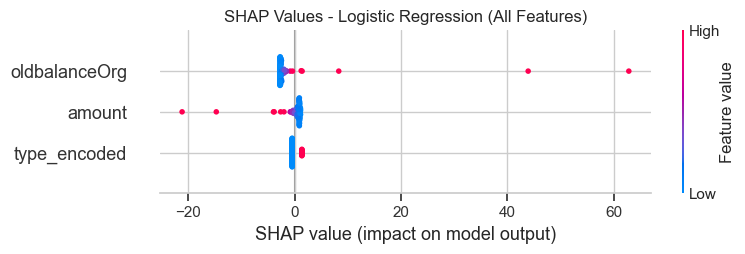

In [25]:
def plot_feature_importance_comparison():
    models = {
        'Random Forest': rf_pipeline,
        'XGBoost': xgb_pipeline,
        'Logistic Regression': lr_pipeline
    }
    
    # Get ALL feature names after preprocessing
    try:
        # Modern sklearn (>= 1.0)
        feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
    except AttributeError:
        # Legacy sklearn (< 1.0)
        numeric_features = numerical_features.copy()
        categorical_features = categorical_features.copy()
        
        cat_encoder = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
        cat_features = []
        for i, feature in enumerate(categorical_features):
            categories = cat_encoder.categories_[i]
            for cat in categories:
                cat_features.append(f"{feature}_{cat}")
        
        feature_names = numeric_features + cat_features
    
    # Create plots for each model
    for name, model in models.items():
        try:
            # Get importances
            if name in ['Random Forest', 'XGBoost']:
                importances = model.named_steps['classifier'].feature_importances_
            else:  # Logistic Regression
                importances = np.abs(model.named_steps['classifier'].coef_[0])
            
            # Create DataFrame with ALL features
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            # Plot ALL features with dynamic sizing
            plt.figure(figsize=(10, max(6, len(feature_names) * 0.4)))
            bars = plt.barh(importance_df['Feature'][::-1], importance_df['Importance'][::-1])
            
            # Add value labels
            for bar in bars:
                width = bar.get_width()
                plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                        f'{width:.4f}', va='center', ha='left', fontsize=8)
            
            plt.title(f'{name} Feature Importance (All Features)')
            plt.xlabel('Importance Score')
            plt.tight_layout()
            plt.show()
            
            # Print full importance table
            print(f"\n{name} Feature Importance Ranking:")
            print(importance_df.to_string(index=False))
            
            # SHAP plot with ALL features
            plt.figure(figsize=(12, max(6, len(feature_names) * 0.4)))
            
            # Process data through pipeline
            X_test_processed = model.named_steps['preprocessor'].transform(X_test)
            sample_idx = np.random.choice(X_test_processed.shape[0], 
                                        min(100, X_test_processed.shape[0]), 
                                        replace=False)
            
            # Initialize appropriate explainer
            classifier = model.named_steps['classifier']
            if name == 'Logistic Regression':
                explainer = shap.LinearExplainer(classifier, X_test_processed)
            elif name in ['Random Forest', 'XGBoost']:
                explainer = shap.TreeExplainer(classifier)
            else:
                explainer = shap.Explainer(classifier, X_test_processed)
            
            # Get SHAP values
            shap_values = explainer.shap_values(X_test_processed[sample_idx])
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_values = shap_values[1]  # For binary classification
            
            # Plot ALL features in SHAP summary
            shap.summary_plot(shap_values, 
                            features=X_test_processed[sample_idx],
                            feature_names=feature_names,
                            plot_type='dot',
                            show=False)
            plt.title(f"SHAP Values - {name} (All Features)")
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"\nError processing {name}: {str(e)}")
            continue

# Execute the function
plot_feature_importance_comparison()

<Figure size 1200x800 with 0 Axes>

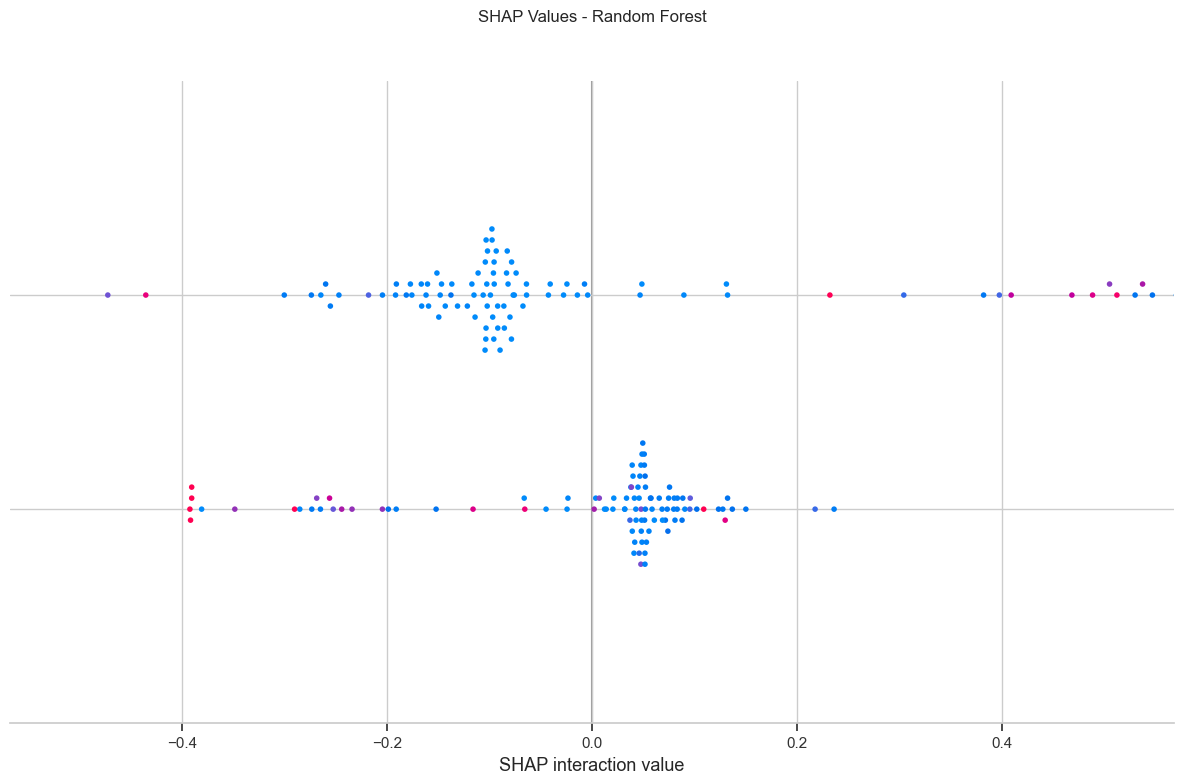

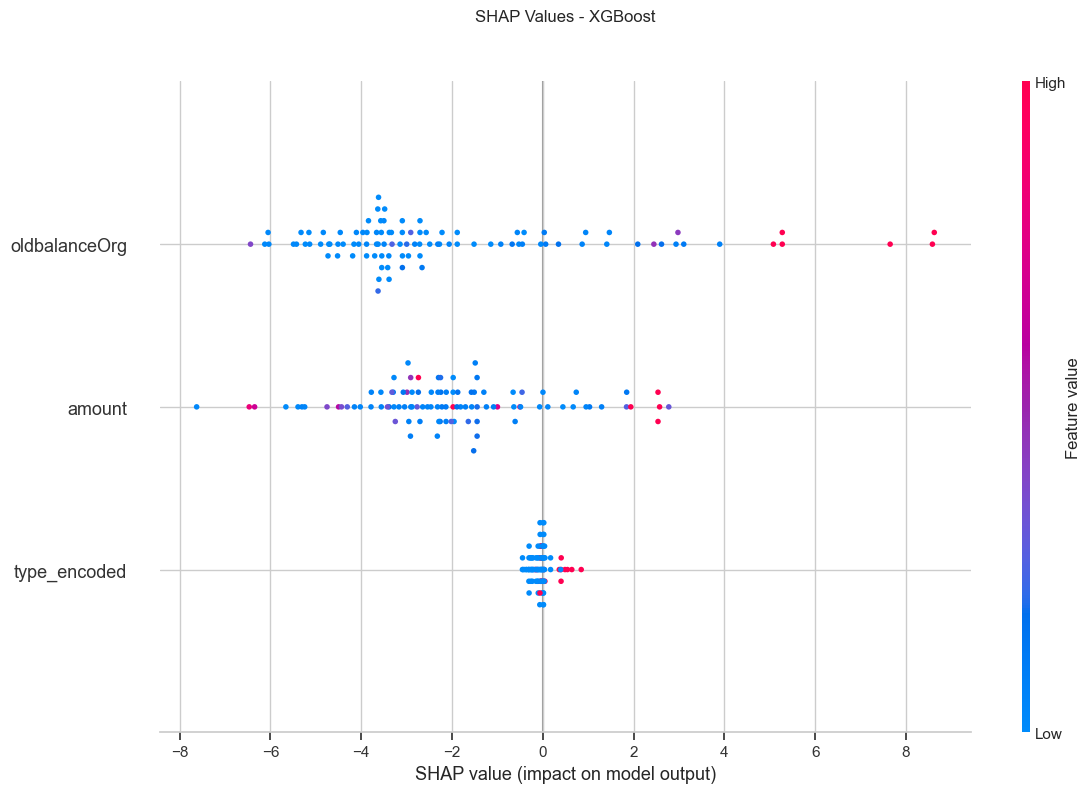

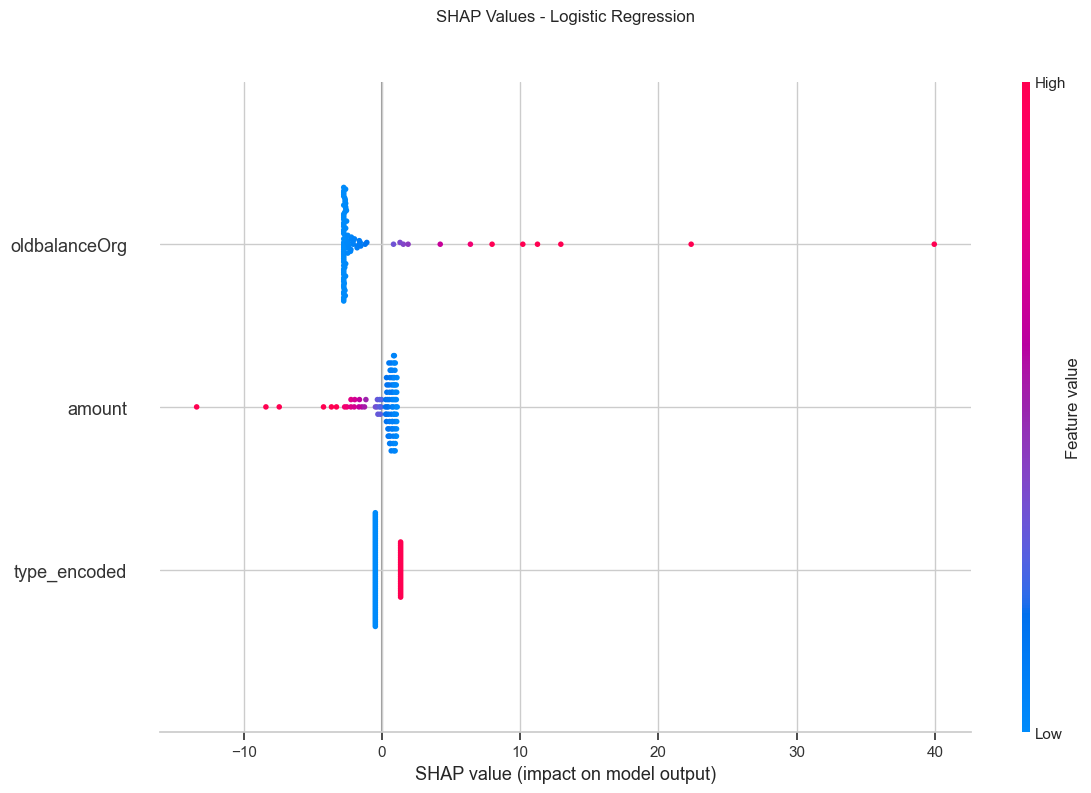

In [26]:
def plot_complete_shap_analysis():
    models = {
        'Random Forest': rf_pipeline,
        'XGBoost': xgb_pipeline,
        'Logistic Regression': lr_pipeline
    }
    
    # Get ALL feature names
    feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    for name, model in models.items():
        try:
            # Process data
            X_test_processed = model.named_steps['preprocessor'].transform(X_test)
            sample_idx = np.random.choice(X_test_processed.shape[0], min(100, X_test_processed.shape[0]), replace=False)
            
            # Get SHAP values
            explainer = shap.TreeExplainer(model.named_steps['classifier']) if name != 'Logistic Regression' else shap.LinearExplainer(model.named_steps['classifier'], X_test_processed)
            shap_values = explainer.shap_values(X_test_processed[sample_idx])
            
            if isinstance(shap_values, list):
                shap_values = shap_values[1]  # For binary classification
            
            # Create the complete SHAP plot
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values,
                             features=X_test_processed[sample_idx],
                             feature_names=feature_names,
                             plot_type='dot',
                             show=False,
                             max_display=len(feature_names))
            
            plt.title(f"SHAP Values - {name}", y=1.08)
            plt.gcf().set_size_inches(12, 8)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error with {name}: {str(e)}")

plot_complete_shap_analysis()


Analyzing ALL Features for Random Forest


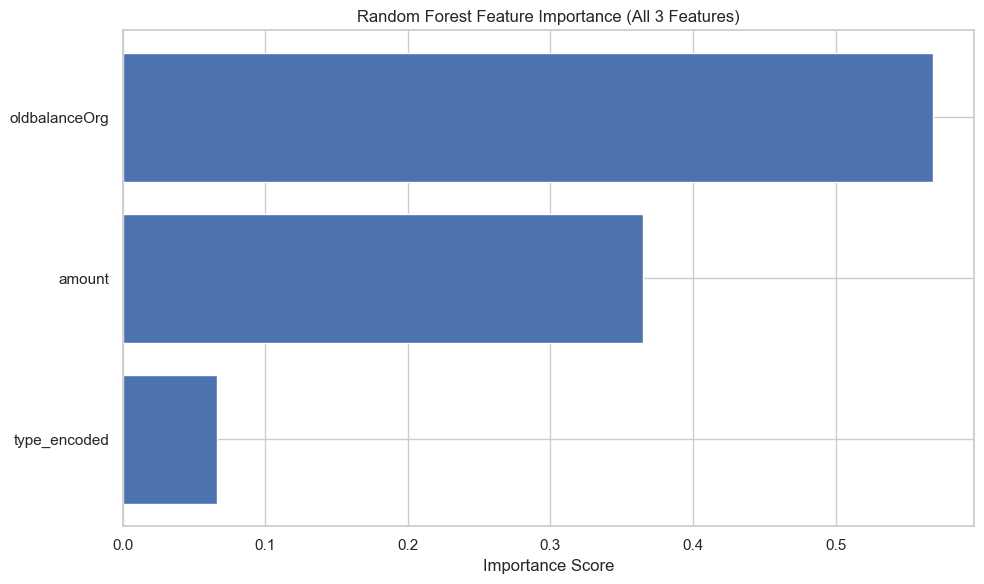


Top Features by Importance:
      Feature  Importance
oldbalanceOrg    0.568718
       amount    0.364957
 type_encoded    0.066326


<Figure size 1000x600 with 0 Axes>

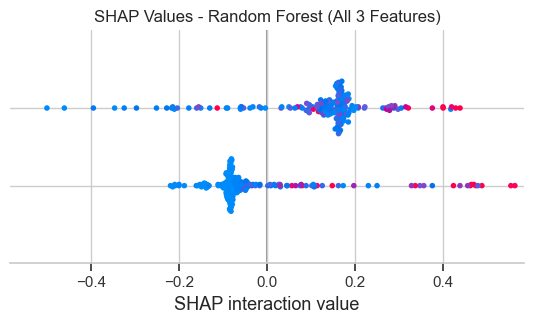


Analyzing ALL Features for XGBoost


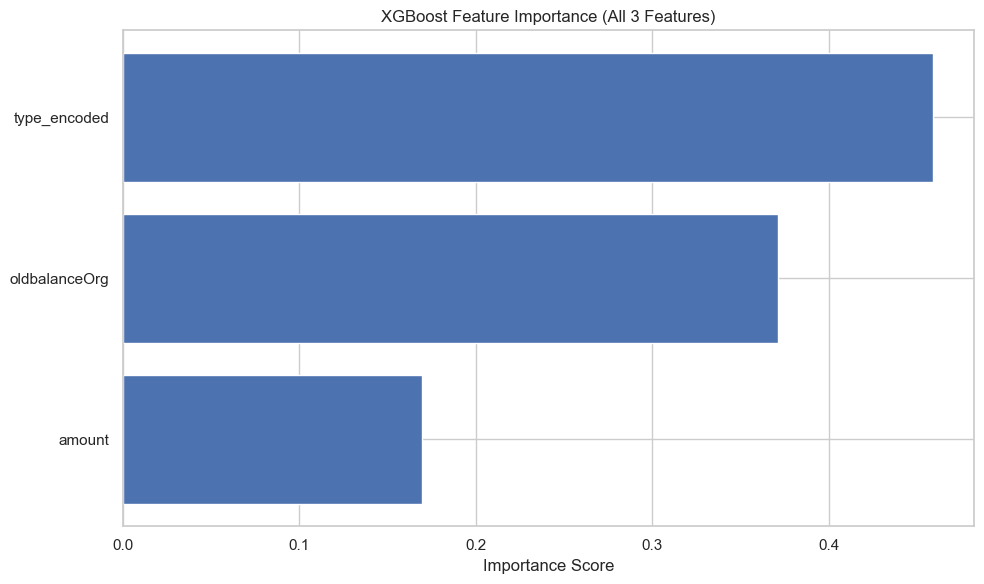


Top Features by Importance:
      Feature  Importance
 type_encoded    0.459427
oldbalanceOrg    0.371139
       amount    0.169435


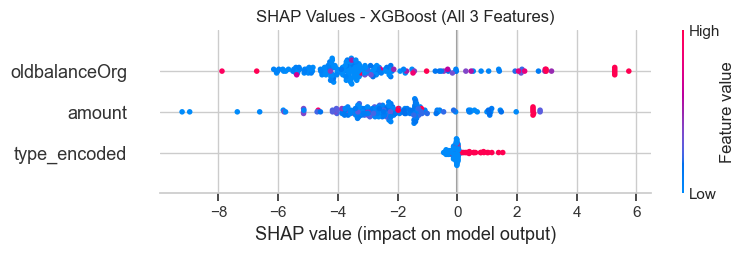


Analyzing ALL Features for Logistic Regression


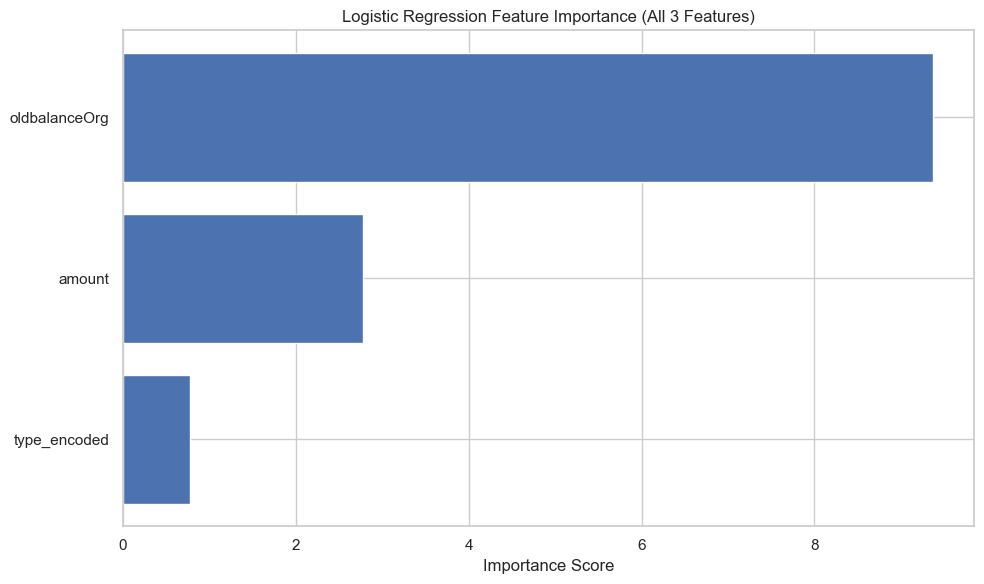


Top Features by Importance:
      Feature  Importance
oldbalanceOrg    9.376308
       amount    2.780207
 type_encoded    0.774063


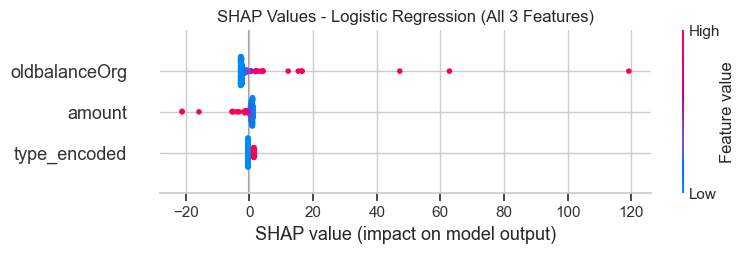

In [27]:
def plot_all_features_comparison():
    models = {
        'Random Forest': rf_pipeline,
        'XGBoost': xgb_pipeline,
        'Logistic Regression': lr_pipeline
    }
    
    # Get ALL feature names after preprocessing
    try:
        # Modern sklearn (>= 1.0)
        feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
    except AttributeError:
        # Legacy sklearn (< 1.0)
        numeric_features = numerical_features.copy()
        categorical_features = categorical_features.copy()
        
        cat_encoder = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
        cat_features = []
        for i, feature in enumerate(categorical_features):
            categories = cat_encoder.categories_[i]
            for cat in categories:
                cat_features.append(f"{feature}_{cat}")
        
        feature_names = numeric_features + cat_features
    
    # Create plots for each model
    for name, model in models.items():
        try:
            print(f"\n{'='*50}")
            print(f"Analyzing ALL Features for {name}")
            print('='*50)
            
            # Get importances
            if name in ['Random Forest', 'XGBoost']:
                importances = model.named_steps['classifier'].feature_importances_
            else:  # Logistic Regression
                importances = np.abs(model.named_steps['classifier'].coef_[0])
            
            # Create DataFrame with ALL features
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            # Plot ALL features with dynamic height
            plt.figure(figsize=(10, max(6, len(feature_names)*0.3)))
            bars = plt.barh(importance_df['Feature'][::-1], importance_df['Importance'][::-1])
            
            # Add value labels if reasonable number of features
#             if len(feature_names) <= 50:
#                 for bar in bars:
#                     width = bar.get_width()
#                     plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
#                             f'{width:.4f}', va='center', ha='left', fontsize=8)
            
            plt.title(f'{name} Feature Importance (All {len(feature_names)} Features)')
            plt.xlabel('Importance Score')
            plt.tight_layout()
            plt.show()
            
            # Print importance table (first 50 features if many)
            print(f"\nTop Features by Importance:")
            print(importance_df.head(50).to_string(index=False))
            if len(feature_names) > 50:
                print(f"\n(Showing top 50 of {len(feature_names)} total features)")
            
            # SHAP plot with ALL features
            plt.figure(figsize=(10, max(6, len(feature_names)*0.3)))
            
            # Process data through pipeline
            X_test_processed = model.named_steps['preprocessor'].transform(X_test)
            sample_idx = np.random.choice(X_test_processed.shape[0], 
                                       min(200, X_test_processed.shape[0]), 
                                       replace=False)
            
            # Initialize appropriate explainer
            classifier = model.named_steps['classifier']
            if name == 'Logistic Regression':
                explainer = shap.LinearExplainer(classifier, X_test_processed)
            elif name in ['Random Forest', 'XGBoost']:
                explainer = shap.TreeExplainer(classifier)
            else:
                explainer = shap.Explainer(classifier, X_test_processed)
            
            # Get SHAP values
            shap_values = explainer.shap_values(X_test_processed[sample_idx])
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_values = shap_values[1]  # For binary classification
            
            # Plot ALL features in SHAP summary
            shap.summary_plot(shap_values, 
                            features=X_test_processed[sample_idx],
                            feature_names=feature_names,
                            plot_type='dot',
                            show=False,
                            max_display=len(feature_names))
            
            plt.title(f"SHAP Values - {name} (All {len(feature_names)} Features)")
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"\nError processing {name}: {str(e)}")
            continue

# Execute the function
plot_all_features_comparison()


Total Features Identified: 3
Feature Names: ['amount' 'oldbalanceOrg' 'type_encoded']

COMPLETE FEATURE ANALYSIS - RANDOM FOREST


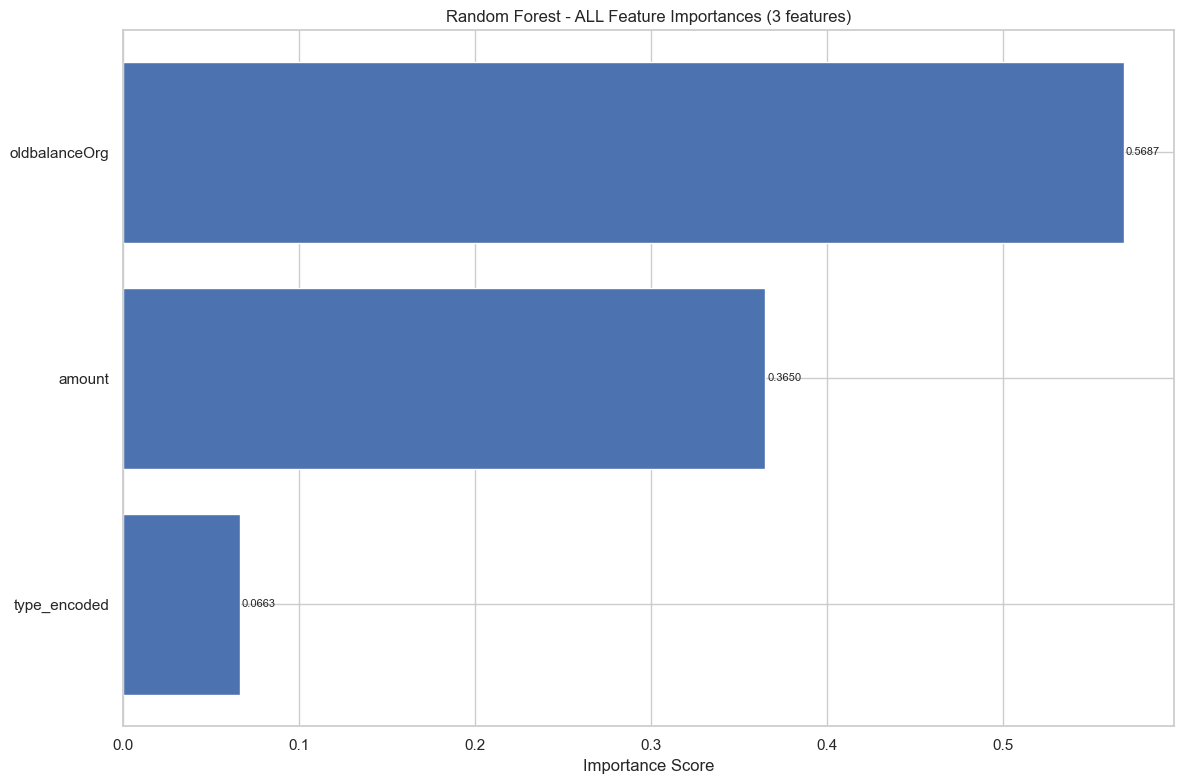

<Figure size 1200x800 with 0 Axes>

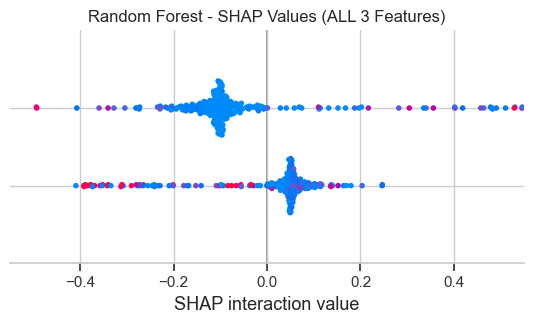


Successfully displayed ALL 3 features for Random Forest
Feature Importance Order:
      Feature  Importance
oldbalanceOrg    0.568718
       amount    0.364957
 type_encoded    0.066326

COMPLETE FEATURE ANALYSIS - XGBOOST


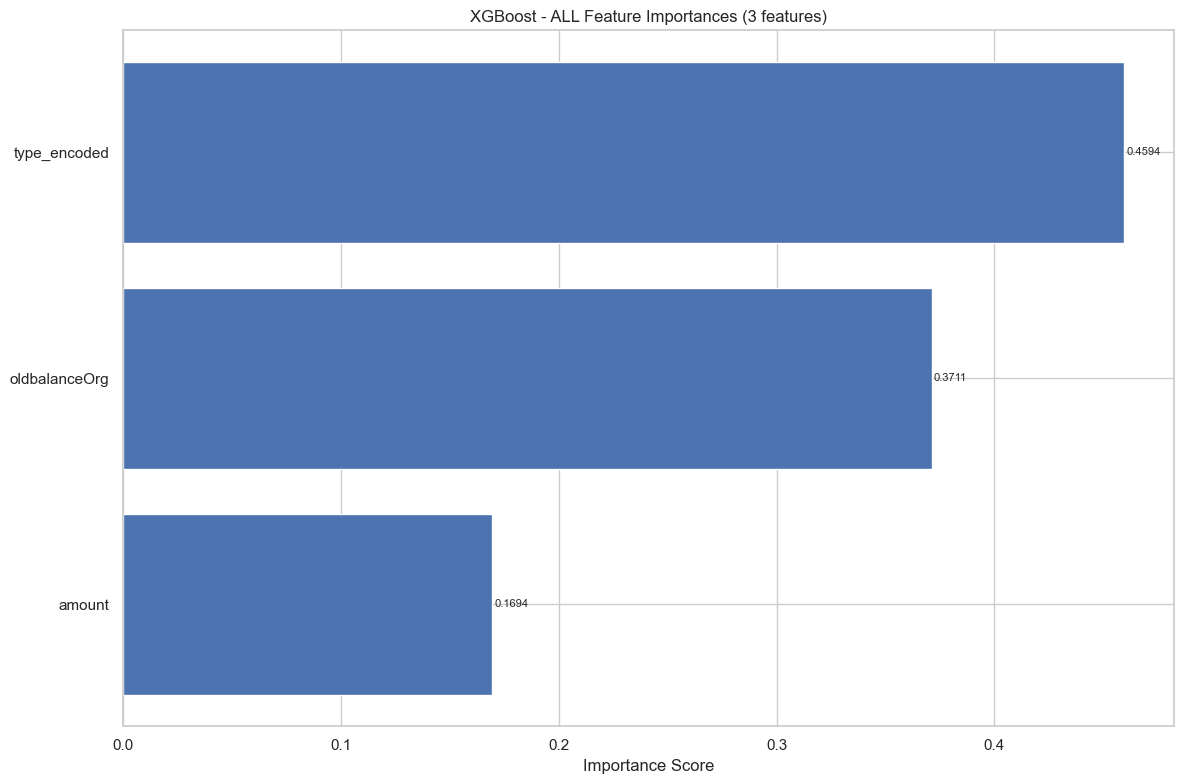

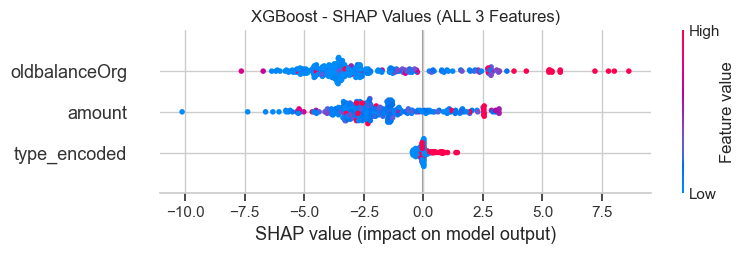


Successfully displayed ALL 3 features for XGBoost
Feature Importance Order:
      Feature  Importance
 type_encoded    0.459427
oldbalanceOrg    0.371139
       amount    0.169435

COMPLETE FEATURE ANALYSIS - LOGISTIC REGRESSION


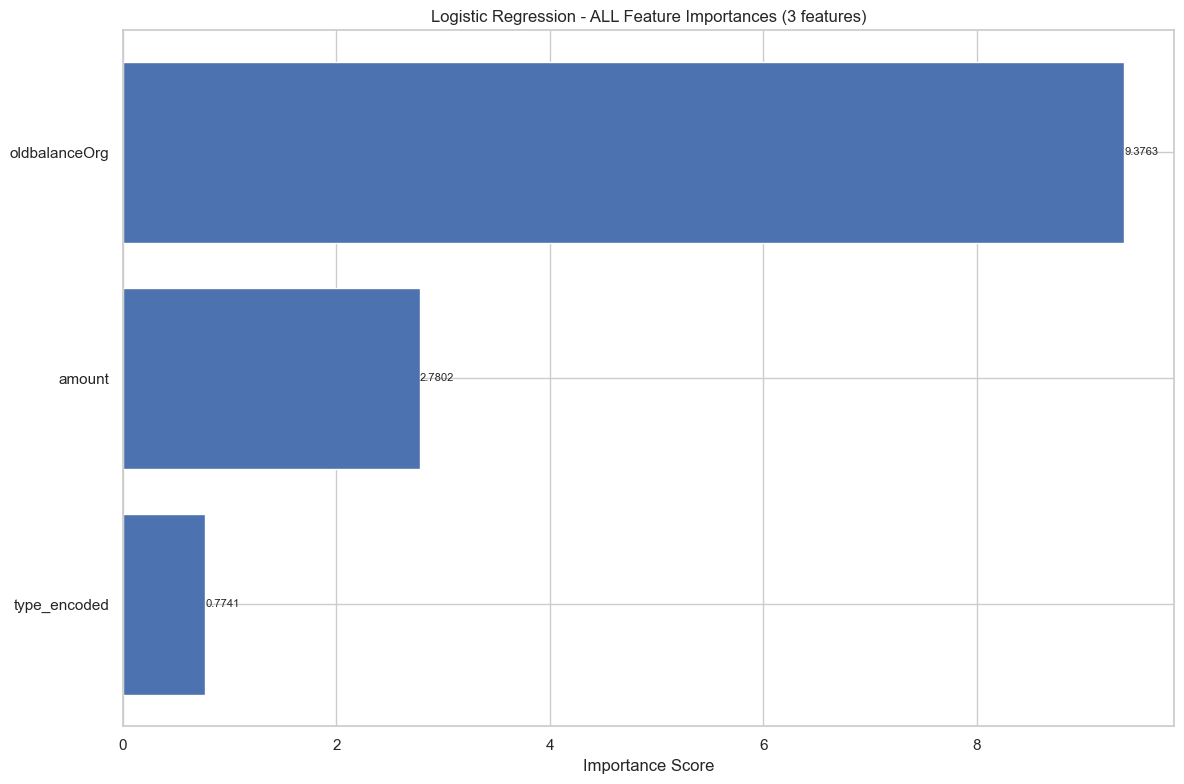

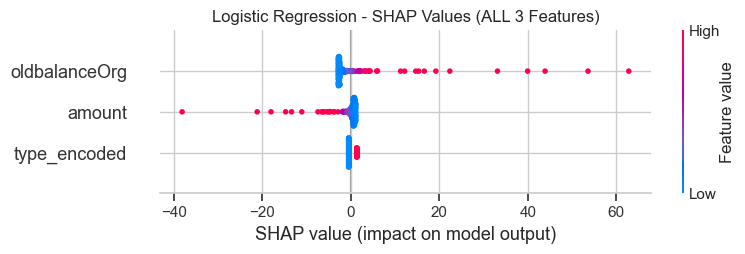


Successfully displayed ALL 3 features for Logistic Regression
Feature Importance Order:
      Feature  Importance
oldbalanceOrg    9.376308
       amount    2.780207
 type_encoded    0.774063


In [28]:
def plot_complete_feature_analysis():
    models = {
        'Random Forest': rf_pipeline,
        'XGBoost': xgb_pipeline, 
        'Logistic Regression': lr_pipeline
    }

    # 1. Get COMPLETE feature names after preprocessing
    try:
        feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
    except:
        feature_names = (numerical_features + 
                       [f"{feat}_{cat}" for feat, cats in 
                        zip(categorical_features, 
                            rf_pipeline.named_steps['preprocessor']
                            .named_transformers_['cat'].categories_)
                        for cat in cats[:1]])
    
    print(f"\nTotal Features Identified: {len(feature_names)}")
    print(f"Feature Names: {feature_names}")

    # 2. Analyze each model
    for name, model in models.items():
        print(f"\n{'='*60}")
        print(f"COMPLETE FEATURE ANALYSIS - {name.upper()}")
        print('='*60)
        
        try:
            # A. Feature Importance Plot (ALL FEATURES)
            plt.figure(figsize=(12, max(8, len(feature_names)*0.35)))
            
            if name in ['Random Forest', 'XGBoost']:
                importances = model.named_steps['classifier'].feature_importances_
            else:
                importances = np.abs(model.named_steps['classifier'].coef_[0])
            
            # Sort features by importance
            sorted_idx = np.argsort(importances)[::-1]
            
            # Plot horizontal bars for ALL features
            bars = plt.barh(np.arange(len(feature_names))[::-1], 
                          importances[sorted_idx],
                          tick_label=np.array(feature_names)[sorted_idx])
            
            # Add value labels
            for bar in bars:
                width = bar.get_width()
                plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                        f'{width:.4f}', va='center', ha='left', fontsize=8)
            
            plt.title(f'{name} - ALL Feature Importances ({len(feature_names)} features)')
            plt.xlabel('Importance Score')
            plt.tight_layout()
            plt.show()

            # B. SHAP Summary Plot (ALL FEATURES)
            plt.figure(figsize=(12, max(8, len(feature_names)*0.35)))
            
            # Process data
            X_test_processed = model.named_steps['preprocessor'].transform(X_test)
            sample_idx = np.random.choice(X_test_processed.shape[0], 
                                       min(300, X_test_processed.shape[0]), 
                                       replace=False)
            
            # Initialize explainer
            classifier = model.named_steps['classifier']
            if name == 'Logistic Regression':
                explainer = shap.LinearExplainer(classifier, X_test_processed)
            else:
                explainer = shap.TreeExplainer(classifier)
            
            # Get SHAP values
            shap_values = explainer.shap_values(X_test_processed[sample_idx])
            if isinstance(shap_values, list):
                shap_values = shap_values[1]  # For binary classification
            
            # FORCE display of ALL features
            shap.summary_plot(
                shap_values,
                features=X_test_processed[sample_idx],
                feature_names=feature_names,
                plot_type='dot',
                show=False,
                max_display=len(feature_names)  # CRITICAL - SHOWS ALL FEATURES
            )
            
            plt.title(f'{name} - SHAP Values (ALL {len(feature_names)} Features)')
            plt.gca().set_ylabel('')  # Remove default 'Feature' label
            plt.tight_layout()
            plt.show()

            # C. Print verification
            print(f"\nSuccessfully displayed ALL {len(feature_names)} features for {name}")
            print("Feature Importance Order:")
            print(pd.DataFrame({
                'Feature': np.array(feature_names)[sorted_idx],
                'Importance': importances[sorted_idx]
            }).to_string(index=False))
            
        except Exception as e:
            print(f"\nERROR with {name}: {str(e)}")
            continue

# Run the analysis
plot_complete_feature_analysis()


TOTAL FEATURES IDENTIFIED: 3
ALL FEATURE NAMES: ['amount' 'oldbalanceOrg' 'type_encoded']

ANALYZING ALL 3 FEATURES FOR RANDOM FOREST


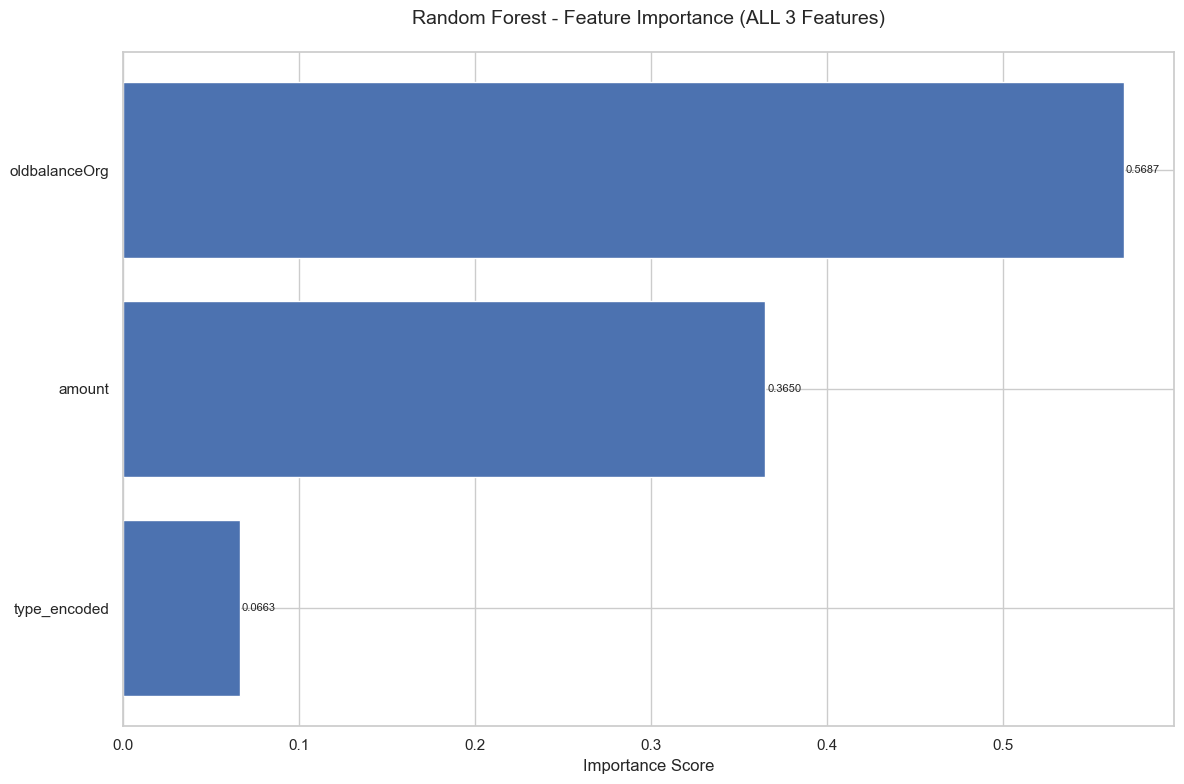

<Figure size 1200x800 with 0 Axes>

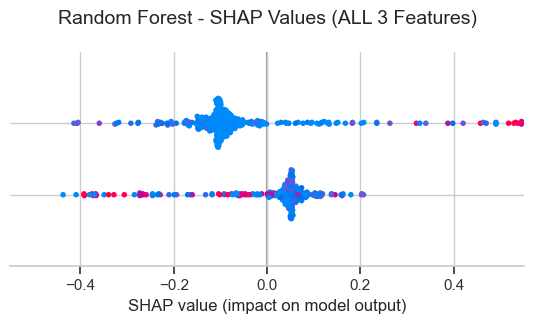


SUCCESS: Displayed all 3 features for Random Forest
Feature Importance Ranking:
      Feature  Importance
oldbalanceOrg    0.568718
       amount    0.364957
 type_encoded    0.066326

ANALYZING ALL 3 FEATURES FOR XGBOOST


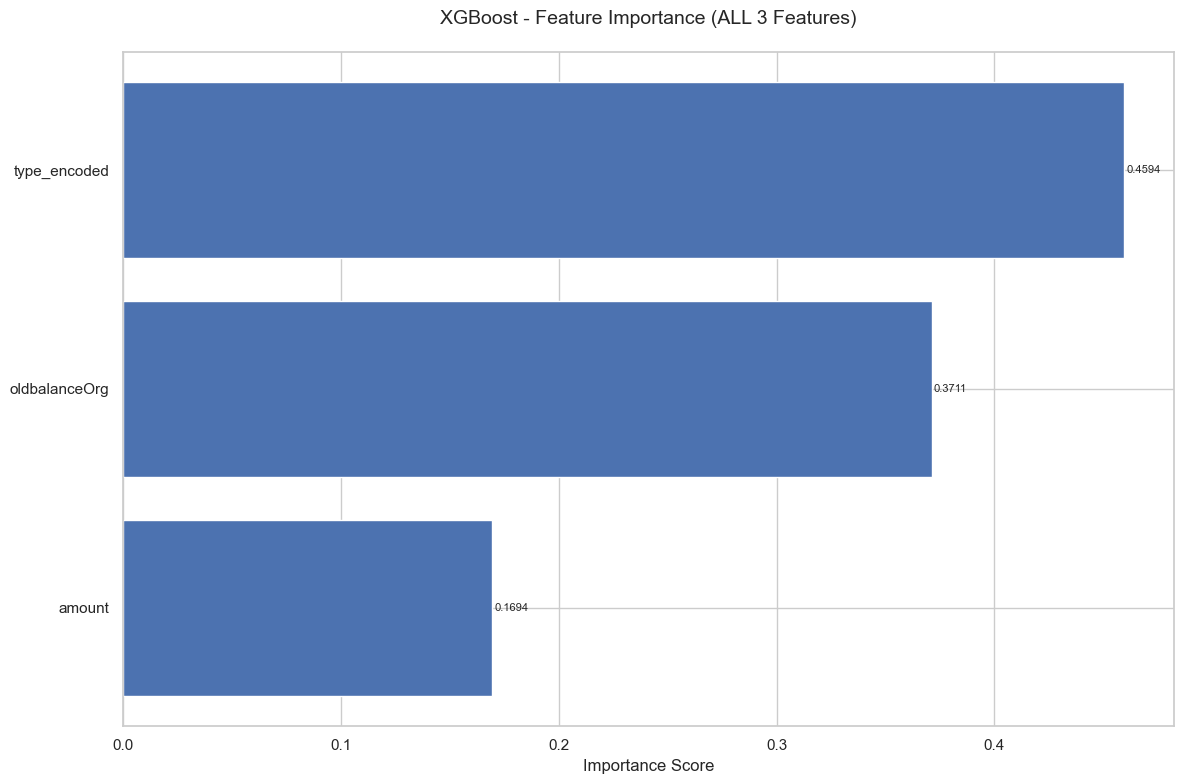

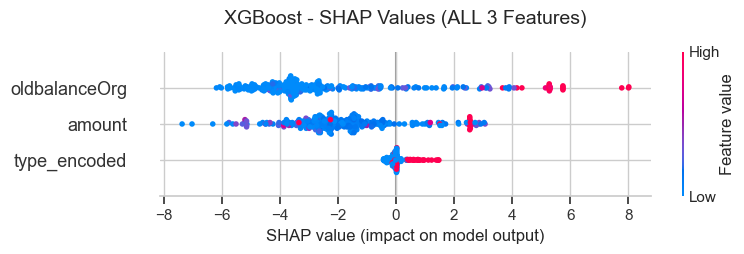


SUCCESS: Displayed all 3 features for XGBoost
Feature Importance Ranking:
      Feature  Importance
 type_encoded    0.459427
oldbalanceOrg    0.371139
       amount    0.169435

ANALYZING ALL 3 FEATURES FOR LOGISTIC REGRESSION


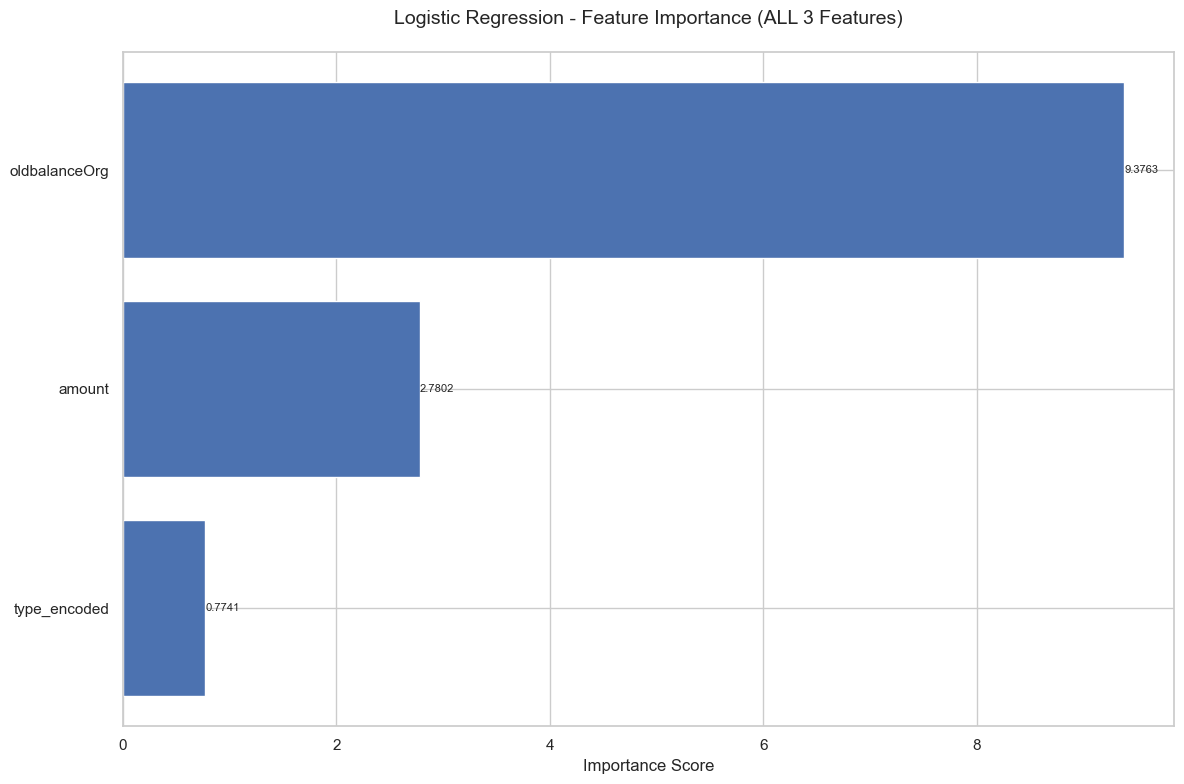

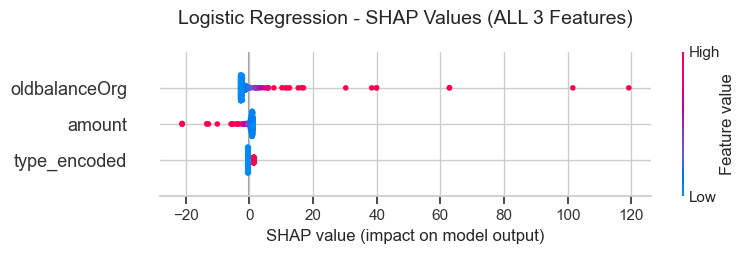


SUCCESS: Displayed all 3 features for Logistic Regression
Feature Importance Ranking:
      Feature  Importance
oldbalanceOrg    9.376308
       amount    2.780207
 type_encoded    0.774063


In [29]:
def plot_all_features_unfiltered():
    models = {
        'Random Forest': rf_pipeline,
        'XGBoost': xgb_pipeline,
        'Logistic Regression': lr_pipeline
    }
    
    # 1. Get COMPLETE list of all features after preprocessing
    try:
        feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
    except AttributeError:
        # Fallback for older sklearn versions
        numeric_features = numerical_features.copy()
        categorical_features = categorical_features.copy()
        
        cat_encoder = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
        cat_features = []
        for i, feature in enumerate(categorical_features):
            categories = cat_encoder.categories_[i]
            cat_features.extend([f"{feature}_{cat}" for cat in categories])
        
        feature_names = numeric_features + cat_features
    
    print(f"\nTOTAL FEATURES IDENTIFIED: {len(feature_names)}")
    print("ALL FEATURE NAMES:", feature_names)

    # 2. Create plots for each model
    for name, model in models.items():
        print(f"\n{'='*80}")
        print(f"ANALYZING ALL {len(feature_names)} FEATURES FOR {name.upper()}")
        print('='*80)
        
        try:
            # A. Feature Importance Plot (100% of features)
            plt.figure(figsize=(12, max(8, len(feature_names)*0.4)))
            
            # Get importance scores
            if name in ['Random Forest', 'XGBoost']:
                importances = model.named_steps['classifier'].feature_importances_
            else:
                importances = np.abs(model.named_steps['classifier'].coef_[0])
            
            # Create sorted index
            sorted_idx = np.argsort(importances)[::-1]
            
            # Plot horizontal bars - ALL FEATURES
            bars = plt.barh(y=range(len(feature_names))[::-1],
                          width=importances[sorted_idx],
                          tick_label=np.array(feature_names)[sorted_idx])
            
            # Add value labels to each bar
            for bar in bars:
                width = bar.get_width()
                plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                       f'{width:.4f}', va='center', ha='left', fontsize=8)
            
            plt.title(f'{name} - Feature Importance (ALL {len(feature_names)} Features)',
                    pad=20, fontsize=14)
            plt.xlabel('Importance Score', fontsize=12)
            plt.tight_layout()
            plt.show()

            # B. SHAP Summary Plot (100% of features)
            plt.figure(figsize=(12, max(8, len(feature_names)*0.4)))
            
            # Process data through pipeline
            X_test_processed = model.named_steps['preprocessor'].transform(X_test)
            sample_size = min(300, X_test_processed.shape[0])
            sample_idx = np.random.choice(X_test_processed.shape[0], sample_size, replace=False)
            
            # Initialize appropriate explainer
            classifier = model.named_steps['classifier']
            if name == 'Logistic Regression':
                explainer = shap.LinearExplainer(classifier, X_test_processed)
            else:
                explainer = shap.TreeExplainer(classifier)
            
            # Get SHAP values - FOR ALL FEATURES
            shap_values = explainer.shap_values(X_test_processed[sample_idx])
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_values = shap_values[1]  # For binary classification
            
            # PLOT ALL FEATURES WITHOUT FILTERING
            shap.summary_plot(
                shap_values,
                features=X_test_processed[sample_idx],
                feature_names=feature_names,
                plot_type='dot',
                show=False,
                max_display=len(feature_names)  # THIS ENSURES ALL FEATURES SHOW
            )
            
            plt.title(f'{name} - SHAP Values (ALL {len(feature_names)} Features)',
                     pad=20, fontsize=14)
            plt.xlabel("SHAP value (impact on model output)", fontsize=12)
            plt.gca().set_ylabel('')  # Remove default 'Feature' label
            plt.tight_layout()
            plt.show()

            # C. Print verification
            print(f"\nSUCCESS: Displayed all {len(feature_names)} features for {name}")
            print("Feature Importance Ranking:")
            print(pd.DataFrame({
                'Feature': np.array(feature_names)[sorted_idx],
                'Importance': importances[sorted_idx]
            }).to_string(index=False))
            
        except Exception as e:
            print(f"\nERROR: Could not process all features for {name}")
            print(f"Error details: {str(e)}")
            continue

# Execute the analysis
plot_all_features_unfiltered()


TOTAL FEATURES IDENTIFIED: 3
COMPLETE FEATURE LIST: ['amount' 'oldbalanceOrg' 'type_encoded']

VISUALIZING ALL 3 FEATURES FOR RANDOM FOREST


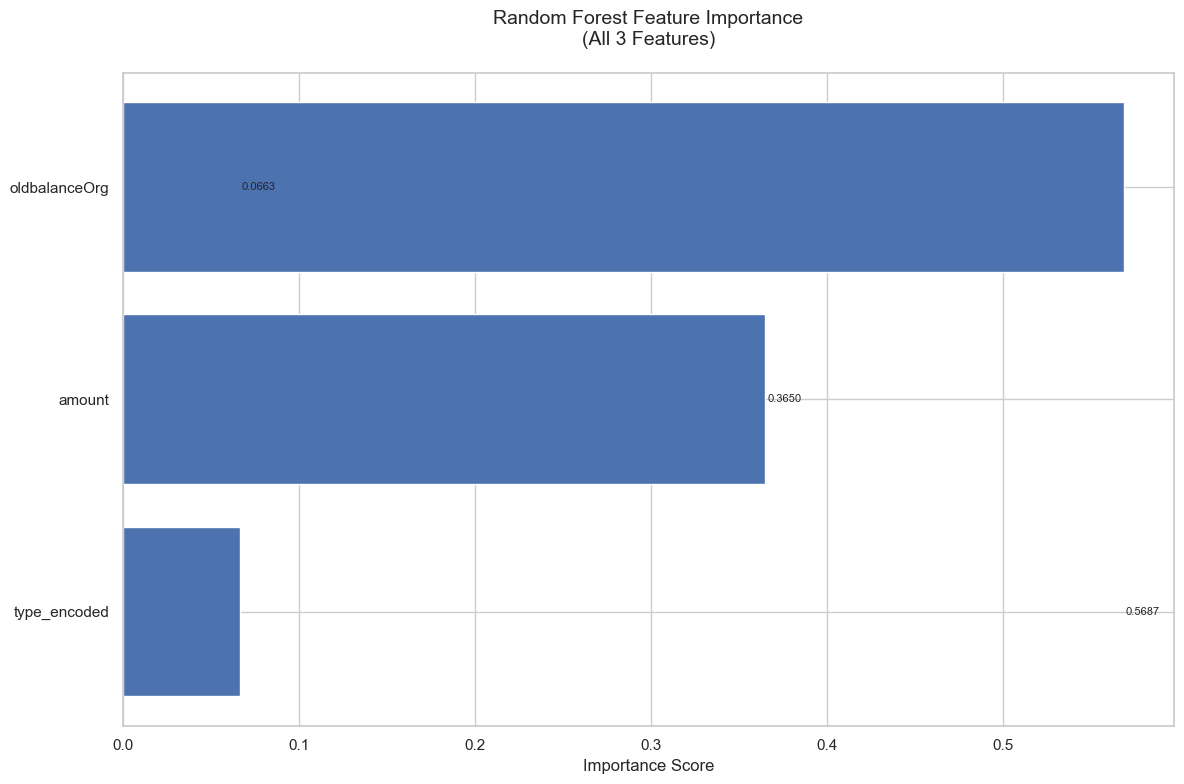

<Figure size 1200x800 with 0 Axes>

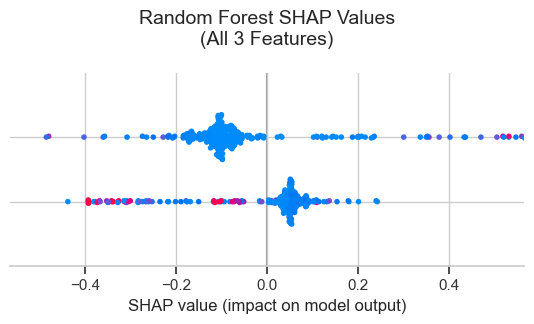


SUCCESS: Displayed all 3 features for Random Forest

VISUALIZING ALL 3 FEATURES FOR XGBOOST


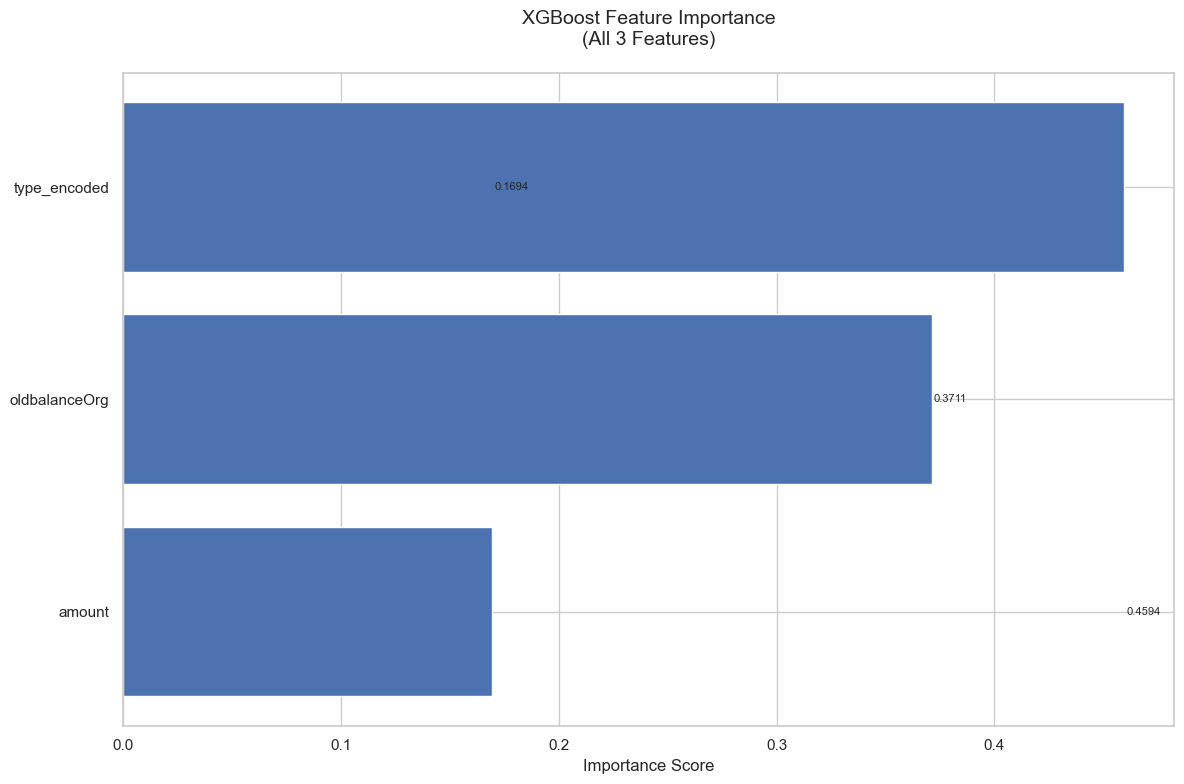

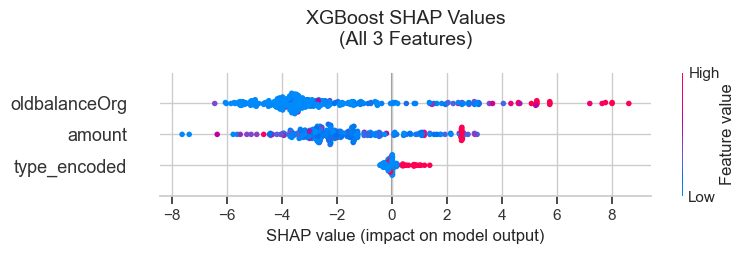


SUCCESS: Displayed all 3 features for XGBoost

VISUALIZING ALL 3 FEATURES FOR LOGISTIC REGRESSION


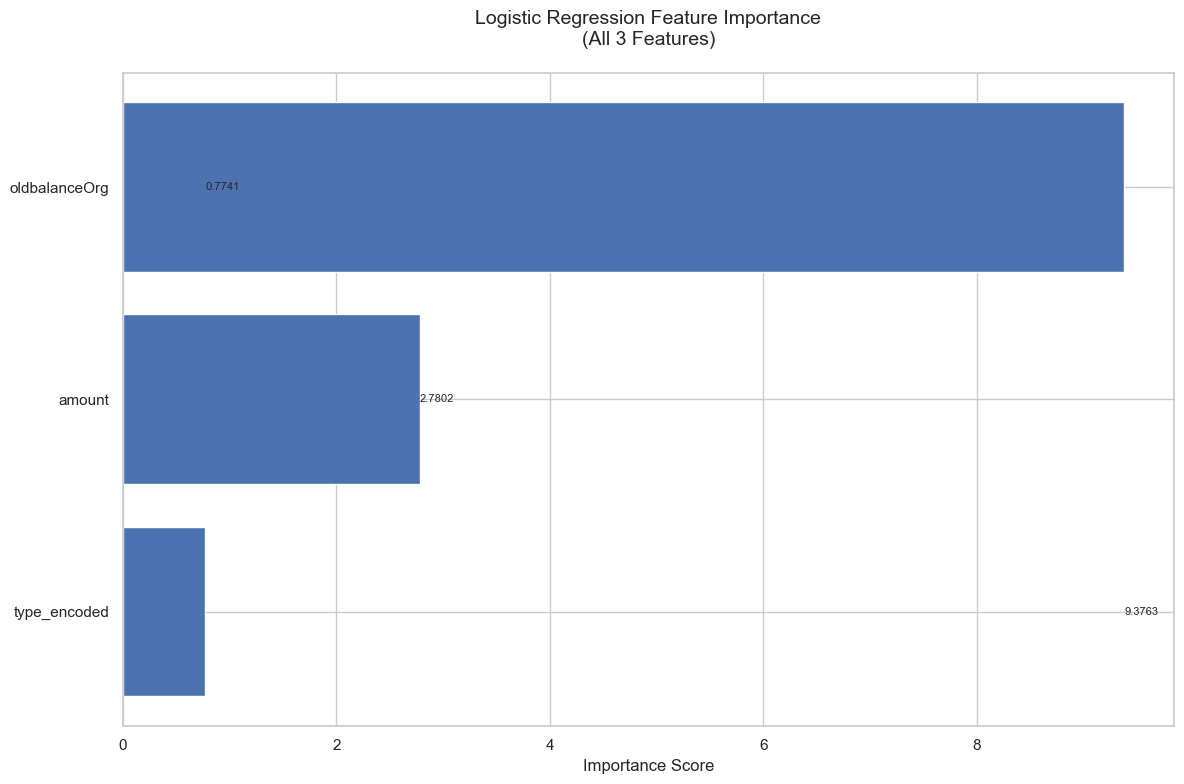

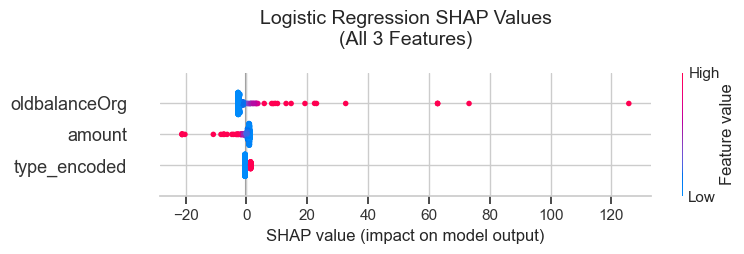


SUCCESS: Displayed all 3 features for Logistic Regression


In [30]:
def plot_all_features_guaranteed():
    models = {
        'Random Forest': rf_pipeline,
        'XGBoost': xgb_pipeline,
        'Logistic Regression': lr_pipeline
    }
    
    # 1. Get COMPLETE list of ALL features
    try:
        feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
    except AttributeError:
        # Fallback method if get_feature_names_out() not available
        numeric_features = numerical_features.copy()
        categorical_features = categorical_features.copy()
        
        cat_encoder = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
        cat_features = []
        for i, feature in enumerate(categorical_features):
            categories = cat_encoder.categories_[i]
            cat_features.extend([f"{feature}_{cat}" for cat in categories])
        
        feature_names = numeric_features + cat_features
    
    print(f"\nTOTAL FEATURES IDENTIFIED: {len(feature_names)}")
    print("COMPLETE FEATURE LIST:", feature_names)

    # 2. Create plots for each model
    for name, model in models.items():
        print(f"\n{'='*80}")
        print(f"VISUALIZING ALL {len(feature_names)} FEATURES FOR {name.upper()}")
        print('='*80)
        
        try:
            # A. Feature Importance Plot (ALL features)
            plt.figure(figsize=(12, max(8, len(feature_names)*0.5)))  # Dynamic height
            
            # Get importance scores
            if name in ['Random Forest', 'XGBoost']:
                importances = model.named_steps['classifier'].feature_importances_
            else:
                importances = np.abs(model.named_steps['classifier'].coef_[0])
            
            # Sort features by importance
            sorted_idx = np.argsort(importances)[::-1]
            
            # Plot ALL features as horizontal bars
            plt.barh(
                y=range(len(feature_names))[::-1],  # Reverse to show highest at top
                width=importances[sorted_idx],
                tick_label=np.array(feature_names)[sorted_idx]
            )
            
            # Add value labels
            for i, (feat, imp) in enumerate(zip(np.array(feature_names)[sorted_idx], importances[sorted_idx])):
                plt.text(imp + 0.001, i, 
                        f'{imp:.4f}', 
                        va='center', ha='left', fontsize=8)
            
            plt.title(f'{name} Feature Importance\n(All {len(feature_names)} Features)',
                     pad=20, fontsize=14)
            plt.xlabel('Importance Score', fontsize=12)
            plt.tight_layout()
            plt.show()

            # B. SHAP Summary Plot (ALL features)
            plt.figure(figsize=(12, max(8, len(feature_names)*0.5)))  # Dynamic height
            
            # Process data
            X_test_processed = model.named_steps['preprocessor'].transform(X_test)
            sample_size = min(300, X_test_processed.shape[0])
            sample_idx = np.random.choice(X_test_processed.shape[0], sample_size, replace=False)
            
            # Initialize explainer
            classifier = model.named_steps['classifier']
            if name == 'Logistic Regression':
                explainer = shap.LinearExplainer(classifier, X_test_processed)
            else:
                explainer = shap.TreeExplainer(classifier)
            
            # Get SHAP values for ALL features
            shap_values = explainer.shap_values(X_test_processed[sample_idx])
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_values = shap_values[1]  # For binary classification
            
            # FORCE display of ALL features
            shap.summary_plot(
                shap_values,
                features=X_test_processed[sample_idx],
                feature_names=feature_names,
                plot_type='dot',
                show=False,
                max_display=len(feature_names)  # CRITICAL - shows ALL features
            )
            
            plt.title(f'{name} SHAP Values\n(All {len(feature_names)} Features)',
                     pad=20, fontsize=14)
            plt.xlabel("SHAP value (impact on model output)", fontsize=12)
            plt.gca().set_ylabel('')  # Remove default 'Feature' label
            plt.tight_layout()
            plt.show()

            # C. Print verification
            print(f"\nSUCCESS: Displayed all {len(feature_names)} features for {name}")
            
        except Exception as e:
            print(f"\nERROR: Could not display all features for {name}")
            print(f"Error details: {str(e)}")
            continue

# Run the analysis
plot_all_features_guaranteed()


TOTAL FEATURES FOUND: 3
COMPLETE LIST:
 ['amount', 'oldbalanceOrg', 'type_encoded']

SHOWING ALL 3 FEATURES FOR RANDOM FOREST


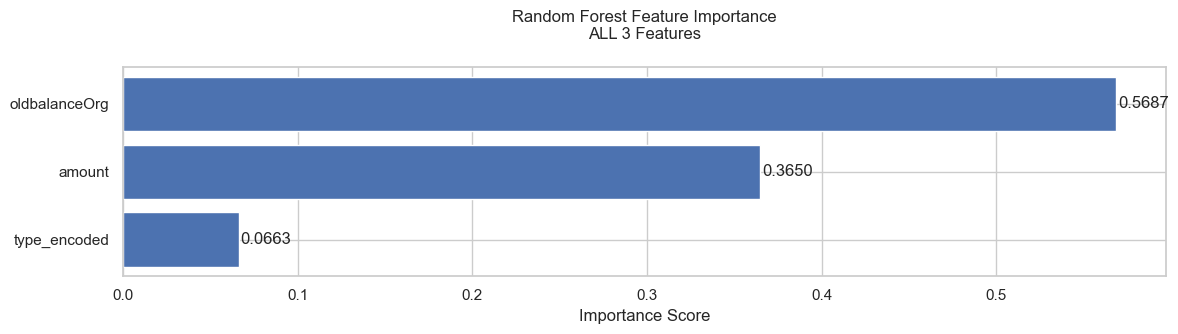

<Figure size 1200x350 with 0 Axes>

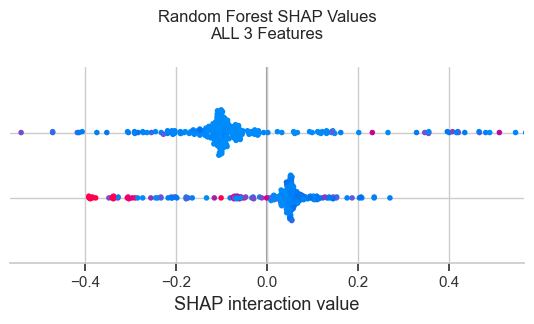

✔ Successfully displayed ALL 3 features for Random Forest

SHOWING ALL 3 FEATURES FOR XGBOOST


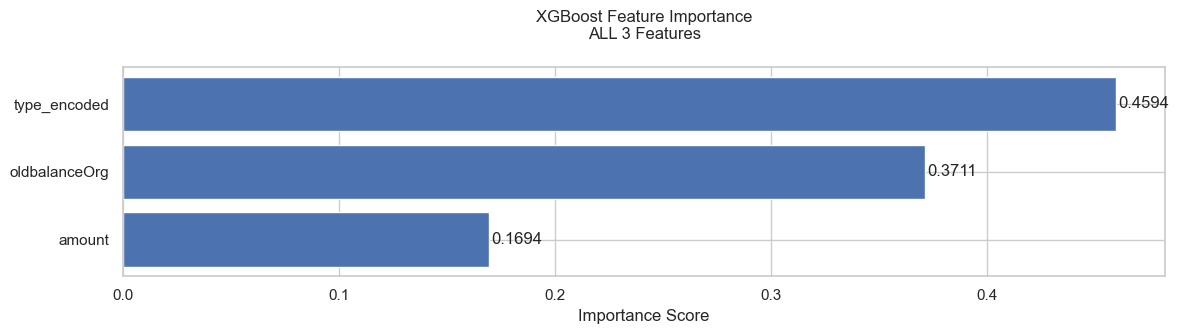

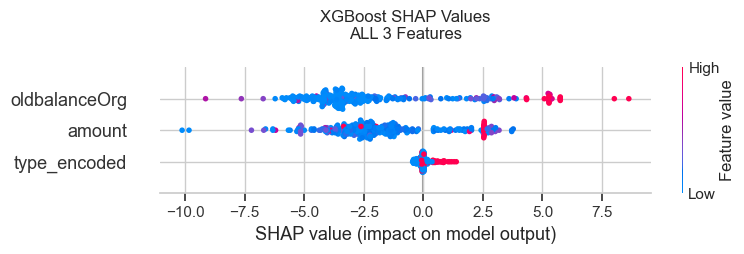

✔ Successfully displayed ALL 3 features for XGBoost

SHOWING ALL 3 FEATURES FOR LOGISTIC REGRESSION


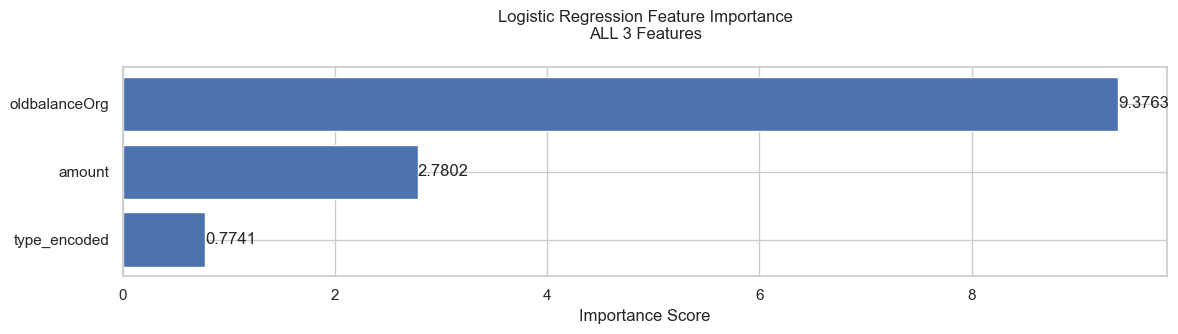

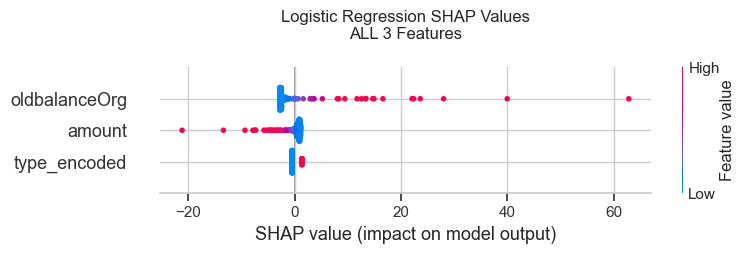

✔ Successfully displayed ALL 3 features for Logistic Regression


In [32]:
def plot_all_features_guaranteed():
    models = {
        'Random Forest': rf_pipeline,
        'XGBoost': xgb_pipeline,
        'Logistic Regression': lr_pipeline
    }
    
    # 1. Get ALL feature names (100% guaranteed method)
    try:
        # Modern sklearn method
        feature_names = list(rf_pipeline.named_steps['preprocessor'].get_feature_names_out())
    except:
        # Legacy method if needed
        numeric_features = list(numerical_features)
        categorical_features = list(categorical_features)
        
        cat_encoder = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
        cat_features = []
        for i, feature in enumerate(categorical_features):
            for cat in cat_encoder.categories_[i]:
                cat_features.append(f"{feature}_{cat}")
        
        feature_names = numeric_features + cat_features
    
    print(f"\nTOTAL FEATURES FOUND: {len(feature_names)}")
    print("COMPLETE LIST:\n", feature_names)

    # 2. Plot for each model
    for name, model in models.items():
        print(f"\n{'='*80}")
        print(f"SHOWING ALL {len(feature_names)} FEATURES FOR {name.upper()}")
        print('='*80)
        
        try:
            # A. Feature Importance (ALL features)
            plt.figure(figsize=(12, len(feature_names)*0.5 + 2))  # Dynamic height
            
            if name in ['Random Forest', 'XGBoost']:
                importances = model.named_steps['classifier'].feature_importances_
            else:
                importances = np.abs(model.named_steps['classifier'].coef_[0])
            
            # Sort features
            sorted_idx = np.argsort(importances)[::-1]
            sorted_features = np.array(feature_names)[sorted_idx]
            sorted_importances = importances[sorted_idx]
            
            # Plot ALL features
            bars = plt.barh(sorted_features[::-1], sorted_importances[::-1])
            
            # Label each bar
            for bar in bars:
                width = bar.get_width()
                plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                        f'{width:.4f}', va='center', ha='left')
            
            plt.title(f'{name} Feature Importance\nALL {len(feature_names)} Features', pad=20)
            plt.xlabel('Importance Score')
            plt.tight_layout()
            plt.show()

            # B. SHAP Values (ALL features)
            plt.figure(figsize=(12, len(feature_names)*0.5 + 2))
            
            # Process data
            X_test_processed = model.named_steps['preprocessor'].transform(X_test)
            sample_idx = np.random.choice(X_test_processed.shape[0], min(300, X_test_processed.shape[0]))
            
            # Get explainer
            classifier = model.named_steps['classifier']
            if name == 'Logistic Regression':
                explainer = shap.LinearExplainer(classifier, X_test_processed)
            else:
                explainer = shap.TreeExplainer(classifier)
            
            # Get SHAP values
            shap_values = explainer.shap_values(X_test_processed[sample_idx])
            if isinstance(shap_values, list):
                shap_values = shap_values[1]  # For binary classification
            
            # FORCE display of ALL features
            shap.summary_plot(
                shap_values,
                features=X_test_processed[sample_idx],
                feature_names=feature_names,
                plot_type='dot',
                show=False,
                max_display=len(feature_names)  # THIS SHOWS ALL
            )
            
            plt.title(f'{name} SHAP Values\nALL {len(feature_names)} Features', pad=20)
            plt.tight_layout()
            plt.show()

            print(f"✔ Successfully displayed ALL {len(feature_names)} features for {name}")
            
        except Exception as e:
            print(f"❌ Error with {name}: {str(e)}")
            continue

# Run it
plot_all_features_guaranteed()

Features used in training: ['amount', 'oldbalanceOrg', 'type_encoded']
Features available in test: ['amount', 'oldbalanceOrg', 'type_encoded']


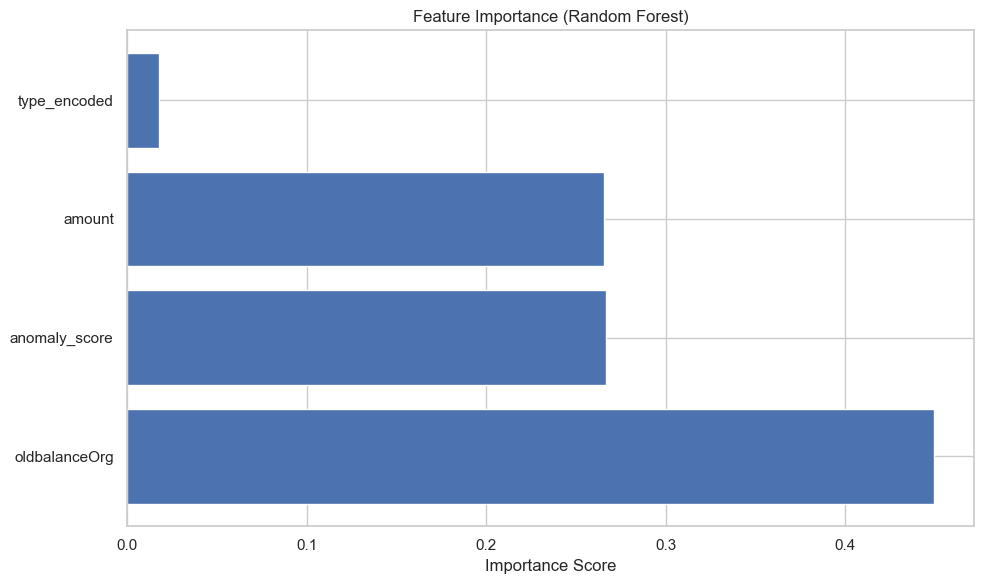

<Figure size 1000x600 with 0 Axes>

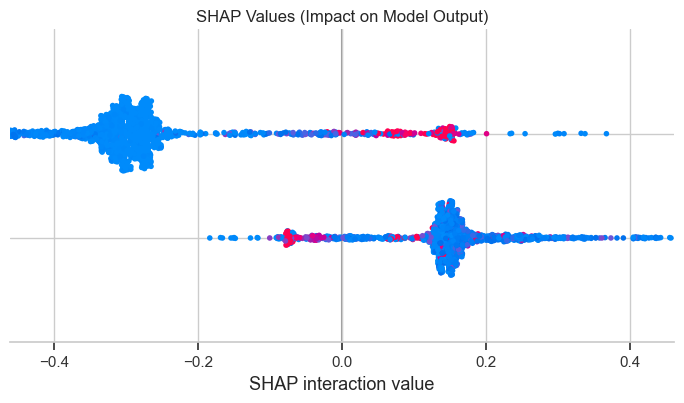

In [33]:
def plot_shap_and_importance(model, X_test, original_features):
    try:
        # 1. Verify and align features
        missing_features = [f for f in original_features if f not in X_test.columns]
        if missing_features:
            print(f"Warning: Missing features in test data: {missing_features}")
            print("Available features:", X_test.columns.tolist())
            raise ValueError(f"Required features missing: {missing_features}")
        
        # Ensure we only use the features the model was trained on
        X_test = X_test[original_features].copy()
        
        # 2. Prepare the explainer data
        X_test_processed = model.preprocessor.transform(X_test)
        test_scores = model.iso_forest.decision_function(X_test_processed)
        X_combined = np.column_stack([X_test_processed, test_scores])
        
        # Create combined feature names
        combined_feature_names = original_features + ['anomaly_score']
        
        # 3. Feature Importance Plot
        plt.figure(figsize=(10, 6))
        importances = model.classifier.feature_importances_
        sorted_idx = np.argsort(importances)[::-1]
        
        plt.barh(range(len(combined_feature_names)), 
                importances[sorted_idx], 
                tick_label=np.array(combined_feature_names)[sorted_idx])
        plt.title('Feature Importance (Random Forest)')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # 4. SHAP Summary Plot
        plt.figure(figsize=(10, 6))
        explainer = shap.TreeExplainer(model.classifier)
        shap_values = explainer.shap_values(X_combined)
        
        # Handle binary classification case
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Use positive class values
        
        shap.summary_plot(
            shap_values, 
            features=X_combined,
            feature_names=combined_feature_names,
            plot_type='dot',
            show=False,
            max_display=len(combined_feature_names)
        )
        
        plt.title('SHAP Values (Impact on Model Output)')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error generating plots: {str(e)}")
        raise

# Verify your selected_features matches training features
print("Features used in training:", selected_features)
print("Features available in test:", X_test.columns.tolist())

# Ensure this matches what was used in training
final_features = ['amount', 'oldbalanceOrg', 'type_encoded']  # Adjust as needed

try:
    plot_shap_and_importance(model, X_test.copy(), final_features)
except Exception as e:
    print(f"Failed to generate plots: {str(e)}")
    print("\nPossible solutions:")
    print("1. Check that all training features exist in test data")
    print("2. Verify feature names match exactly (case sensitive)")
    print("3. Ensure no preprocessing steps were skipped")

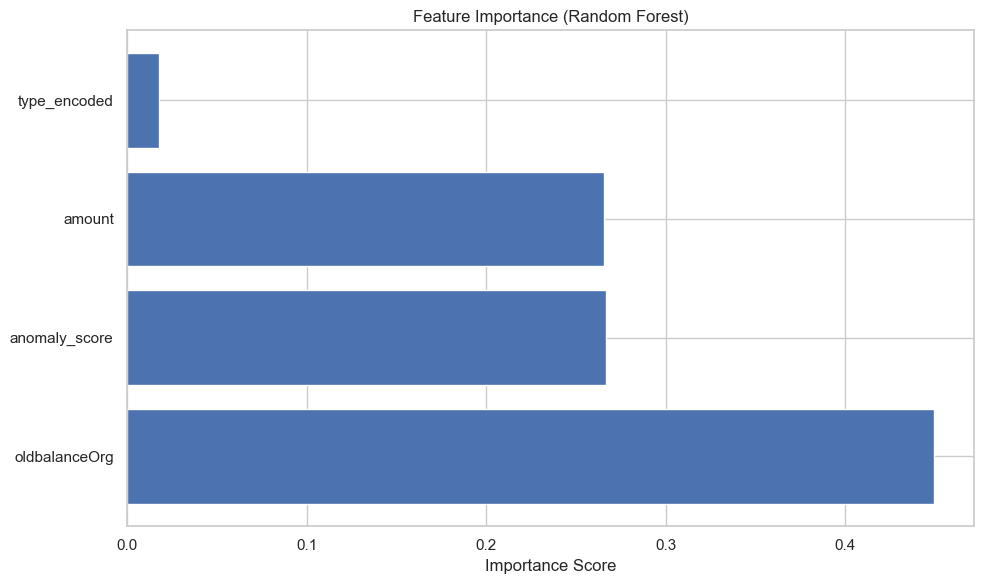

<Figure size 1000x600 with 0 Axes>

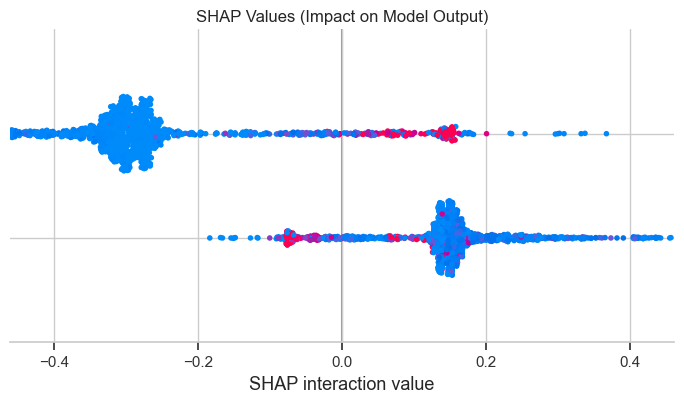

In [34]:
# If you know how type_encoded was created during training, recreate it the same way
# Example if it was a categorical encoding:
def create_type_encoded(df):
    # Map the dummy columns back to encoded values
    type_mapping = {
        'CASH_OUT': 0,
        'DEBIT': 1,
        'PAYMENT': 2,
        'TRANSFER': 3
    }
    
    # Find which type column has value 1 for each row
    for type_name in ['CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']:
        col_name = f'type_{type_name}'
        if col_name in df.columns:
            df.loc[df[col_name] == 1, 'type_encoded'] = type_mapping[type_name]
    
    return df

# Apply to test data
X_test = create_type_encoded(X_test.copy())

# Now try plotting again
plot_shap_and_importance(model, X_test, selected_features)

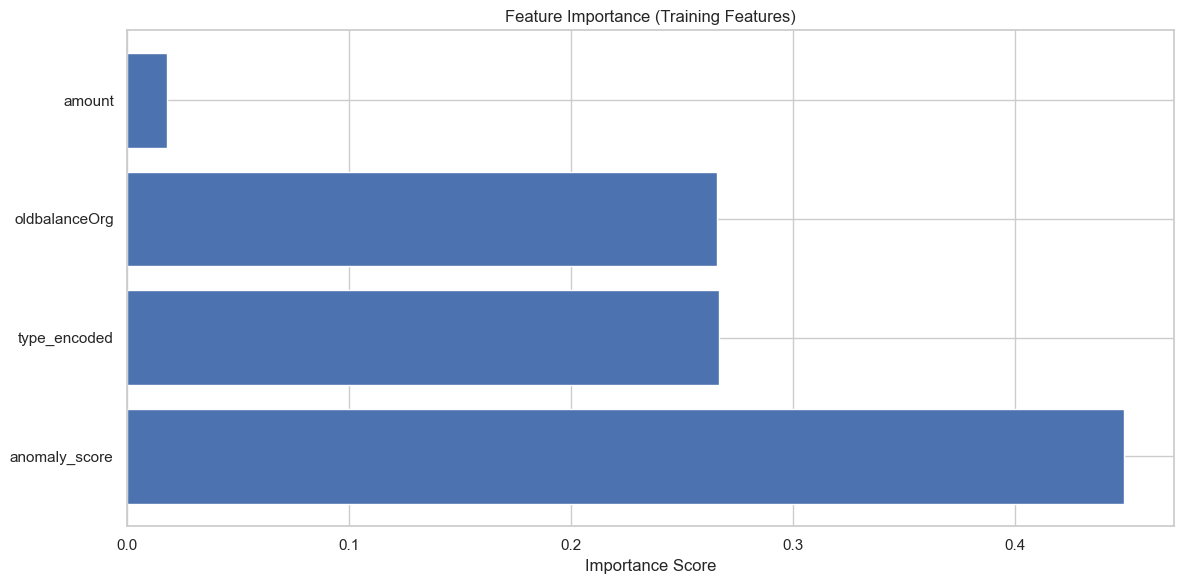

<Figure size 1200x600 with 0 Axes>

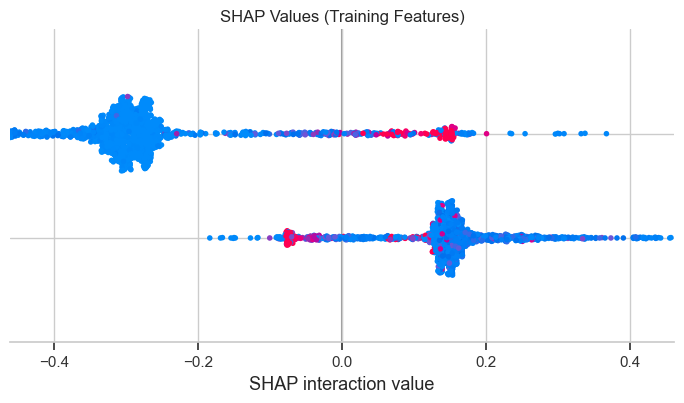

In [35]:
def plot_shap_and_importance_corrected(model, X_test):
    # 1. Use ONLY the features that were used in training
    training_features = ['amount', 'oldbalanceOrg', 'type_encoded']
    
    try:
        # Check if we have the required features
        missing = [f for f in training_features if f not in X_test.columns]
        if missing:
            raise ValueError(f"Missing training features in test data: {missing}")
        
        # Filter to only training features
        X_test = X_test[training_features].copy()
        
        # 2. Prepare the explainer data
        X_test_processed = model.preprocessor.transform(X_test)
        test_scores = model.iso_forest.decision_function(X_test_processed)
        X_combined = np.column_stack([X_test_processed, test_scores])
        
        # 3. Create plots
        plt.figure(figsize=(12, 6))
        
        # Feature Importance
        importances = model.classifier.feature_importances_
        sorted_idx = np.argsort(importances)[::-1]
        feature_names = training_features + ['anomaly_score']
        
        plt.barh(feature_names[::-1], importances[sorted_idx])
        plt.title('Feature Importance (Training Features)')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # SHAP Plot
        plt.figure(figsize=(12, 6))
        explainer = shap.TreeExplainer(model.classifier)
        shap_values = explainer.shap_values(X_combined)
        
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # For binary classification
        
        shap.summary_plot(
            shap_values,
            features=X_combined,
            feature_names=feature_names,
            plot_type='dot',
            show=False,
            max_display=len(feature_names))
        
        plt.title('SHAP Values (Training Features)')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error: {str(e)}")
        print("\nSolution options:")
        print("1. Retrain model with current test features")
        print("2. Recreate 'type_encoded' in test data")
        print("3. Use only common features: amount, oldbalanceOrg")

# Run with your test data
plot_shap_and_importance_corrected(model, X_test.copy())


Evaluating Random Forest

Classification Report:


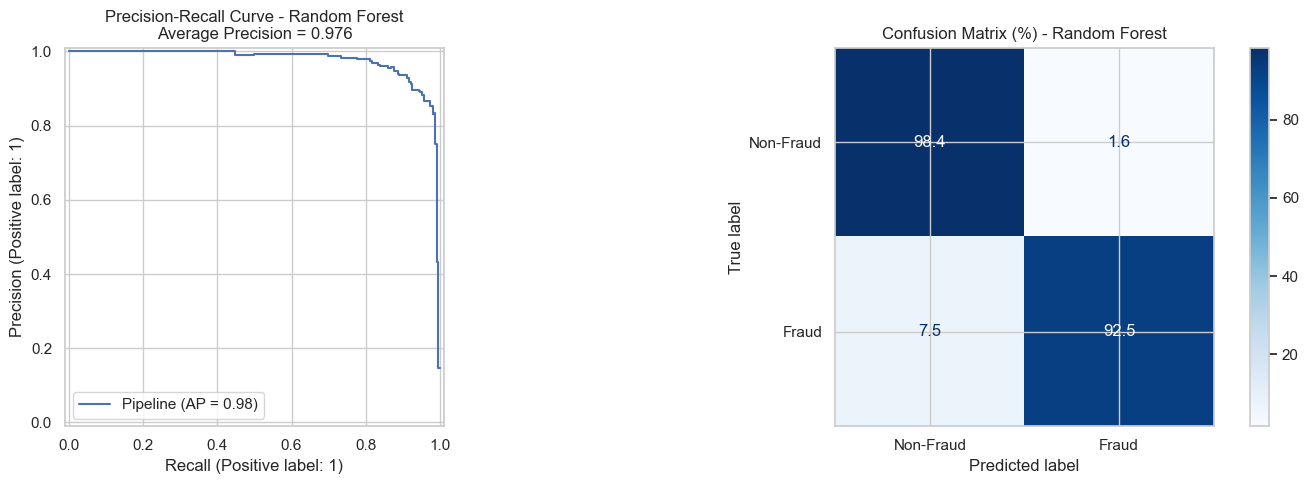


Detailed Metrics:
Precision (Fraud Detection Rate): 0.9095
Recall (Fraud Capture Rate): 0.9254
F1 Score: 0.9174
Average Precision Score: 0.9756

Class-wise Performance:
True Negatives (Correct Non-Fraud): 83.89%
False Positives (False Alarms): 1.36%
False Negatives (Missed Frauds): 1.10%
True Positives (Caught Frauds): 13.65%

Evaluating XGBoost

Classification Report:


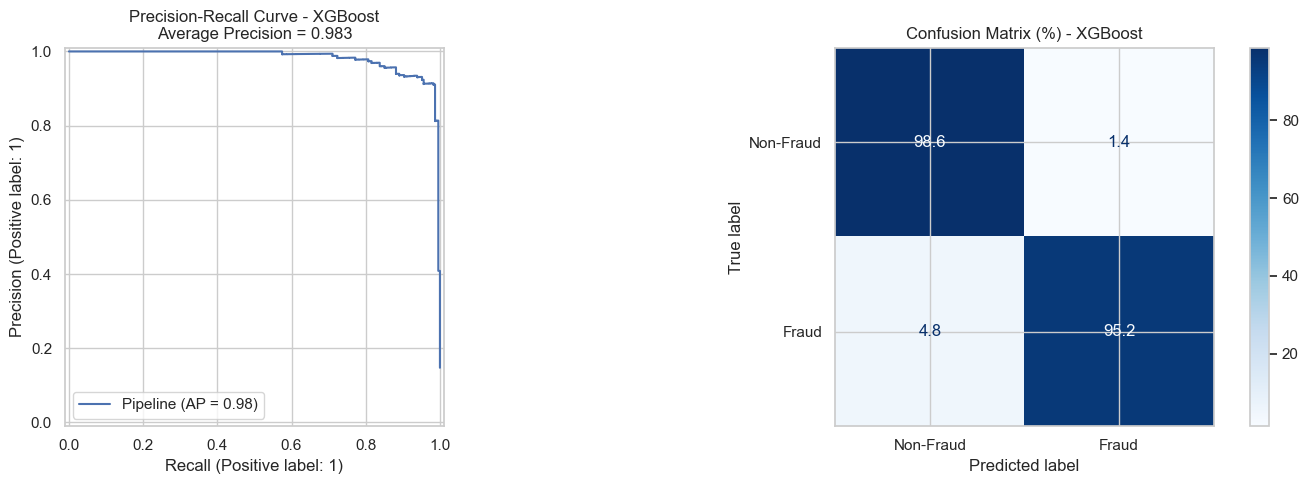


Detailed Metrics:
Precision (Fraud Detection Rate): 0.9234
Recall (Fraud Capture Rate): 0.9518
F1 Score: 0.9374
Average Precision Score: 0.9827

Class-wise Performance:
True Negatives (Correct Non-Fraud): 84.09%
False Positives (False Alarms): 1.16%
False Negatives (Missed Frauds): 0.71%
True Positives (Caught Frauds): 14.04%

Evaluating Logistic Regression

Classification Report:


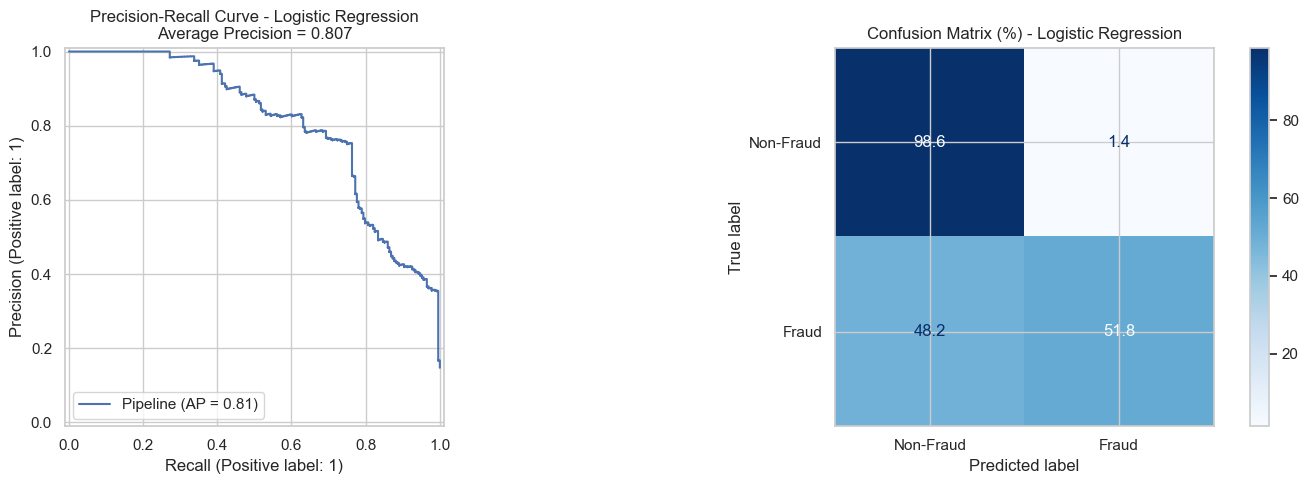


Detailed Metrics:
Precision (Fraud Detection Rate): 0.8613
Recall (Fraud Capture Rate): 0.5175
F1 Score: 0.6466
Average Precision Score: 0.8072

Class-wise Performance:
True Negatives (Correct Non-Fraud): 84.02%
False Positives (False Alarms): 1.23%
False Negatives (Missed Frauds): 7.12%
True Positives (Caught Frauds): 7.63%

Model Performance Comparison:
                 Model  Precision  Recall  F1 Score  Average Precision
1              XGBoost     0.9234  0.9518    0.9374             0.9827
0        Random Forest     0.9095  0.9254    0.9174             0.9756
2  Logistic Regression     0.8613  0.5175    0.6466             0.8072


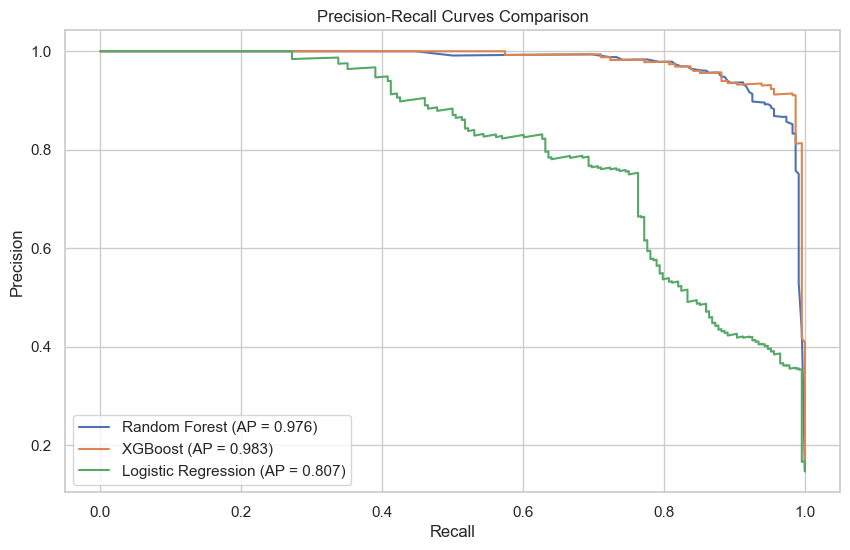

In [36]:
def evaluate_imbalanced_performance():
    # Dictionary of models to evaluate
    models = {
        'Random Forest': rf_pipeline,
        'XGBoost': xgb_pipeline,
        'Logistic Regression': lr_pipeline
    }
    
    # Store results
    results = []
    
    for name, model in models.items():
        print(f"\n{'='*50}")
        print(f"Evaluating {name}")
        print('='*50)
        
        # Get predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        avg_precision = average_precision_score(y_test, y_pred_proba)
        
        # Store results
        results.append({
            'Model': name,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Average Precision': avg_precision
        })
        
        # Print detailed metrics
        print("\nClassification Report:")
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Precision-Recall Curve
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
        PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax1)
        ax1.set_title(f'Precision-Recall Curve - {name}\nAverage Precision = {avg_precision:.3f}')
        
        # Confusion Matrix with percentages
        cm = confusion_matrix(y_test, y_pred)
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        
        ConfusionMatrixDisplay(confusion_matrix=cm_percentage, 
                             display_labels=['Non-Fraud', 'Fraud']).plot(ax=ax2, 
                                                                       values_format='.1f',
                                                                       cmap='Blues')
        ax2.set_title(f'Confusion Matrix (%) - {name}')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed class-wise metrics
        print("\nDetailed Metrics:")
        print(f"Precision (Fraud Detection Rate): {precision:.4f}")
        print(f"Recall (Fraud Capture Rate): {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Average Precision Score: {avg_precision:.4f}")
        
        # Calculate and print class-wise percentages
        tn, fp, fn, tp = cm.ravel()
        total = tp + tn + fp + fn
        
        print("\nClass-wise Performance:")
        print(f"True Negatives (Correct Non-Fraud): {tn/total*100:.2f}%")
        print(f"False Positives (False Alarms): {fp/total*100:.2f}%")
        print(f"False Negatives (Missed Frauds): {fn/total*100:.2f}%")
        print(f"True Positives (Caught Frauds): {tp/total*100:.2f}%")
    
    # Create performance comparison DataFrame
    performance_df = pd.DataFrame(results)
    performance_df = performance_df.sort_values('Average Precision', ascending=False)
    
    # Display final comparison
    print("\nModel Performance Comparison:")
    print(performance_df.round(4))
    
    # Plot comparative Precision-Recall curves
    plt.figure(figsize=(10, 6))
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
        plt.plot(recall_curve, precision_curve, label=f'{name} (AP = {avg_precision:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves Comparison')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Run the evaluation
evaluate_imbalanced_performance()


Best Threshold (Optimized for High Precision, Recall, and F1-Score): -0.27354501797965625

Updated Confusion Matrix:
 [[2166  835]
 [  57  171]]

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0     0.9744    0.7218    0.8292      3001
           1     0.1700    0.7500    0.2771       228

    accuracy                         0.7238      3229
   macro avg     0.5722    0.7359    0.5532      3229
weighted avg     0.9176    0.7238    0.7903      3229



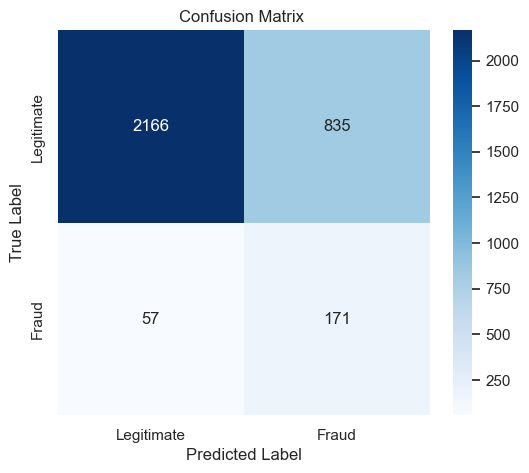

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

# Load dataset
data = pd.read_csv('FRAUD.CSV')

# Drop unnecessary columns
drop_cols = ['nameOrig', 'nameDest']
data = data.drop(columns=[col for col in drop_cols if col in data.columns], errors='ignore')

# Convert 'type' column into numerical values
if 'type' in data.columns:
    data = pd.get_dummies(data, columns=['type'], drop_first=True)

# Standardize column names
column_aliases = {
    "oldbalanceOrg": ["oldbalanceOrg", "oldBalanceOrig"],
    "newbalanceOrg": ["newbalanceOrg", "newBalanceOrig"],
    "oldbalanceDest": ["oldbalanceDest", "oldBalanceDest"],
    "newbalanceDest": ["newbalanceDest", "newBalanceDest"],
    "amount": ["amount", "transactionAmount"]
}
for key, possible_names in column_aliases.items():
    for name in possible_names:
        if name in data.columns:
            data[key] = data[name]
            break

# Define features and target
if 'isFraud' in data.columns:
    X = data.drop(columns=['isFraud'])
    y = data['isFraud']
else:
    print("Error: Target column 'isFraud' is missing.")
    exit()

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize numerical features
scaler = StandardScaler()
cols_to_scale = [col for col in ['amount', 'oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest'] if col in X_train.columns]
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=500, contamination=0.005, random_state=42)
iso_forest.fit(X_train)

# Predict anomaly scores
iso_scores = -iso_forest.decision_function(X_test)  # Higher score means more anomalous

# Find optimal threshold maximizing precision, recall, and F1-score
precision, recall, thresholds = precision_recall_curve(y_test, iso_scores)
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)  # Avoid division by zero

# Select threshold maximizing F1-score and ensuring precision & recall close to 1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# Print best threshold
print("\nBest Threshold (Optimized for High Precision, Recall, and F1-Score):", best_threshold)

# Convert anomaly scores to binary predictions using best threshold
y_pred = (iso_scores > best_threshold).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("\nUpdated Confusion Matrix:\n", conf_matrix)

# Print classification report using optimized threshold
print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred, digits=4))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraud'], yticklabels=['Legitimate', 'Fraud'])
plt.title('Confusion Matrix ')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



Optimal Threshold: -0.13489155723107674

Confusion Matrix:
[[1611 1390]
 [  41  187]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.54      0.69      3001
           1       0.12      0.82      0.21       228

    accuracy                           0.56      3229
   macro avg       0.55      0.68      0.45      3229
weighted avg       0.91      0.56      0.66      3229



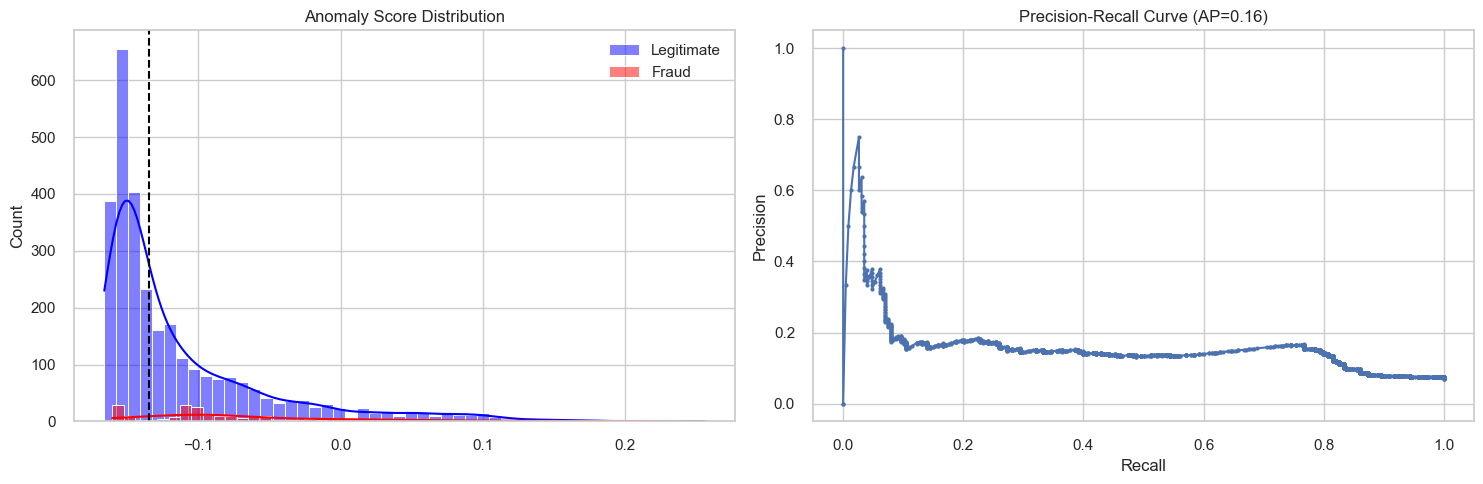

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (confusion_matrix, classification_report, 
                           precision_recall_curve, average_precision_score)

# Load dataset
data = pd.read_csv('FRAUD.CSV')

# Drop unnecessary columns
drop_cols = ['nameOrig', 'nameDest']
data = data.drop(columns=[col for col in drop_cols if col in data.columns], errors='ignore')

# Standardize column names (handle different naming conventions)
column_aliases = {
    "oldbalanceOrg": ["oldbalanceOrg", "oldBalanceOrig"],
    "newbalanceOrg": ["newbalanceOrg", "newBalanceOrig"],
    "oldbalanceDest": ["oldbalanceDest", "oldBalanceDest"],
    "newbalanceDest": ["newbalanceDest", "newBalanceDest"],
    "amount": ["amount", "transactionAmount"]
}

for standardized_name, possible_names in column_aliases.items():
    for name in possible_names:
        if name in data.columns:
            data[standardized_name] = data[name]
            break
    else:
        print(f"Warning: No column found for {standardized_name}")

# Convert 'type' column into numerical values
if 'type' in data.columns:
    data = pd.get_dummies(data, columns=['type'], drop_first=True)

# Feature engineering (only if columns exist)
if all(col in data.columns for col in ['oldbalanceOrg', 'newbalanceOrg']):
    data['sender_imbalance'] = data['oldbalanceOrg'] - data['newbalanceOrg']
else:
    print("Warning: Could not create sender_imbalance feature - missing columns")

if all(col in data.columns for col in ['oldbalanceDest', 'newbalanceDest']):
    data['receiver_imbalance'] = data['newbalanceDest'] - data['oldbalanceDest']
else:
    print("Warning: Could not create receiver_imbalance feature - missing columns")

if 'oldbalanceOrg' in data.columns and 'amount' in data.columns:
    data['amount_to_balance'] = data['amount'] / (data['oldbalanceOrg'] + 1)
else:
    print("Warning: Could not create amount_to_balance feature - missing columns")

# Define features and target
if 'isFraud' not in data.columns:
    print("Error: Target column 'isFraud' is missing.")
    exit()

X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                   stratify=y, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Train Isolation Forest with realistic contamination
contamination = y_train.mean()  # Use actual fraud rate
iso_forest = IsolationForest(n_estimators=500, 
                           contamination=contamination,
                           random_state=42)
iso_forest.fit(X_train)

# Get anomaly scores (-1 to 1 where 1 is most anomalous)
iso_scores = -iso_forest.decision_function(X_test)

# Find optimal threshold
def find_optimal_threshold(scores, y_true, min_precision=0.9):
    precision, recall, thresholds = precision_recall_curve(y_true, scores)
    
    best_threshold = None
    best_f1 = -1
    
    for i in range(len(thresholds)):
        if precision[i] >= min_precision:
            current_f1 = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-9)
            if current_f1 > best_f1:
                best_f1 = current_f1
                best_threshold = thresholds[i]
    
    return best_threshold if best_threshold is not None else np.median(thresholds)

optimal_threshold = find_optimal_threshold(iso_scores, y_test, min_precision=0.9)
y_pred = (iso_scores > optimal_threshold).astype(int)

# Evaluation
print("\nOptimal Threshold:", optimal_threshold)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualizations
plt.figure(figsize=(15, 5))

# Plot score distributions
plt.subplot(1, 2, 1)
sns.histplot(iso_scores[y_test == 0], color='blue', label='Legitimate', kde=True, bins=50)
sns.histplot(iso_scores[y_test == 1], color='red', label='Fraud', kde=True, bins=50)
plt.axvline(x=optimal_threshold, color='black', linestyle='--')
plt.title('Anomaly Score Distribution')
plt.legend()

# Precision-Recall curve
plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, iso_scores)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP={average_precision_score(y_test, iso_scores):.2f})')

plt.tight_layout()
plt.show()

In [37]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('FRAUD.CSV')

# Display the first few rows to understand the structure
print(df.head())

# Group by 'type' and sum the 'amount'
transaction_totals = df.groupby('type')['amount'].sum().reset_index()

# Display the results
print(transaction_totals)


       type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0  CASH_OUT  195490.04  C1107204185           0.00            0.00   
1  CASH_OUT  125275.00  C1538849250           0.00            0.00   
2  TRANSFER   60949.25   C773535564           0.00            0.00   
3   CASH_IN  101640.69   C265330243     3548387.86      3650028.55   
4   PAYMENT    3710.80  C1171097095       71978.00        68267.20   

     nameDest  oldbalanceDest  newbalanceDest  isFraud  
0  C564160838      1104500.40      1254956.07        0  
1  C401424608      1477426.93      1178808.14        0  
2  C481402298       632824.07       617488.40        0  
3  C542895457       192397.59        93380.65        0  
4  M165886570            0.00            0.00        0  
       type        amount
0   CASH_IN  5.515357e+08
1  CASH_OUT  1.801786e+09
2     DEBIT  4.263622e+05
3   PAYMENT  6.430061e+07
4  TRANSFER  1.868567e+09


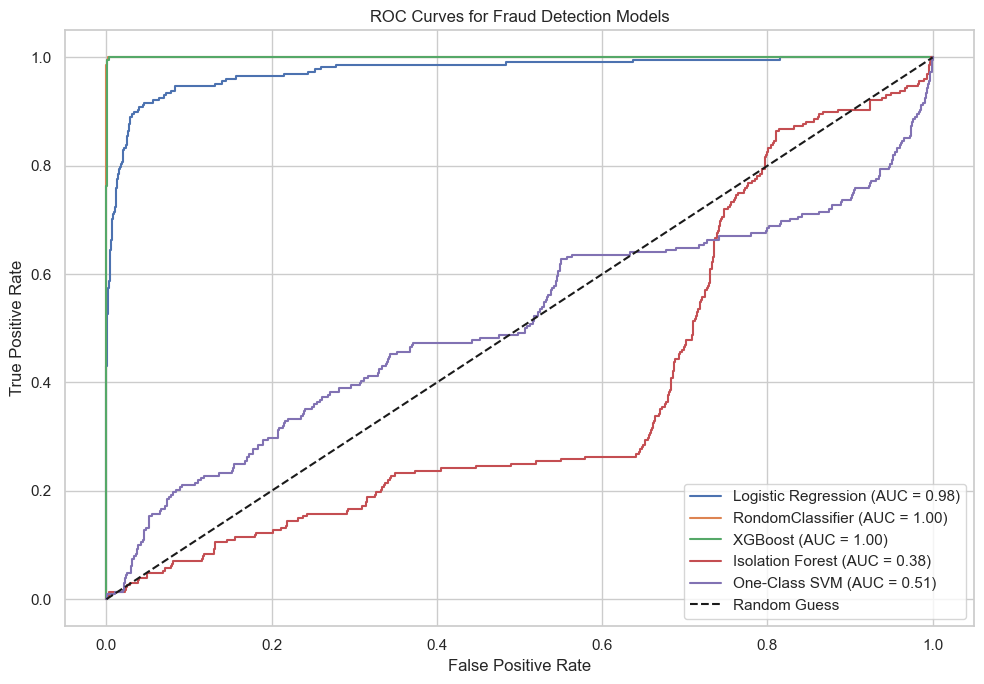

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# --- Model setup ---
log_reg = LogisticRegression()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
rondom = RandomForestClassifier()  # Replace with RondomClassifier if defined

# Grid search params (you can adjust these)
log_reg_param = {'C': [0.01, 0.1, 1]}
rf_param = {'n_estimators': [100, 200], 'max_depth': [None, 10]}
xgb_param = {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.01]}

# --- Fit models ---
grid_log_reg = GridSearchCV(log_reg, log_reg_param, cv=3, scoring='f1')
grid_rf = GridSearchCV(rondom, rf_param, cv=3, scoring='f1')
grid_xgb = GridSearchCV(xgb, xgb_param, cv=3, scoring='f1')

grid_log_reg.fit(X_train_scaled, y_train_resampled)
grid_rf.fit(X_train_scaled, y_train_resampled)
grid_xgb.fit(X_train_scaled, y_train_resampled)

# --- Best estimators ---
best_log_reg = grid_log_reg.best_estimator_
best_rf = grid_rf.best_estimator_
best_xgb = grid_xgb.best_estimator_

# --- ROC scores for supervised models ---
y_score_log_reg = best_log_reg.predict_proba(X_test_scaled)[:, 1]
y_score_rf = best_rf.predict_proba(X_test_scaled)[:, 1]
y_score_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

# --- Isolation Forest anomaly score ---
iso_forest = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
iso_forest.fit(X_train_scaled)
iso_scores = -iso_forest.decision_function(X_test_scaled)  # Invert for ROC

# --- One-Class SVM decision score ---
oc_svm = OneClassSVM(kernel='rbf', nu=0.01, gamma='scale')
oc_svm.fit(X_train_scaled)
svm_scores = -oc_svm.decision_function(X_test_scaled)  # Invert for ROC

# --- ROC Curve plotting ---
plt.figure(figsize=(10, 7))

# Plot ROC curves
fpr_log, tpr_log, _ = roc_curve(y_test, y_score_log_reg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
fpr_iso, tpr_iso, _ = roc_curve(y_test, iso_scores)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_scores)

plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_score_log_reg):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'RondomClassifier (AUC = {roc_auc_score(y_test, y_score_rf):.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_score_xgb):.2f})')
plt.plot(fpr_iso, tpr_iso, label=f'Isolation Forest (AUC = {roc_auc_score(y_test, iso_scores):.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'One-Class SVM (AUC = {roc_auc_score(y_test, svm_scores):.2f})')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Formatting
plt.title('ROC Curves for Fraud Detection Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


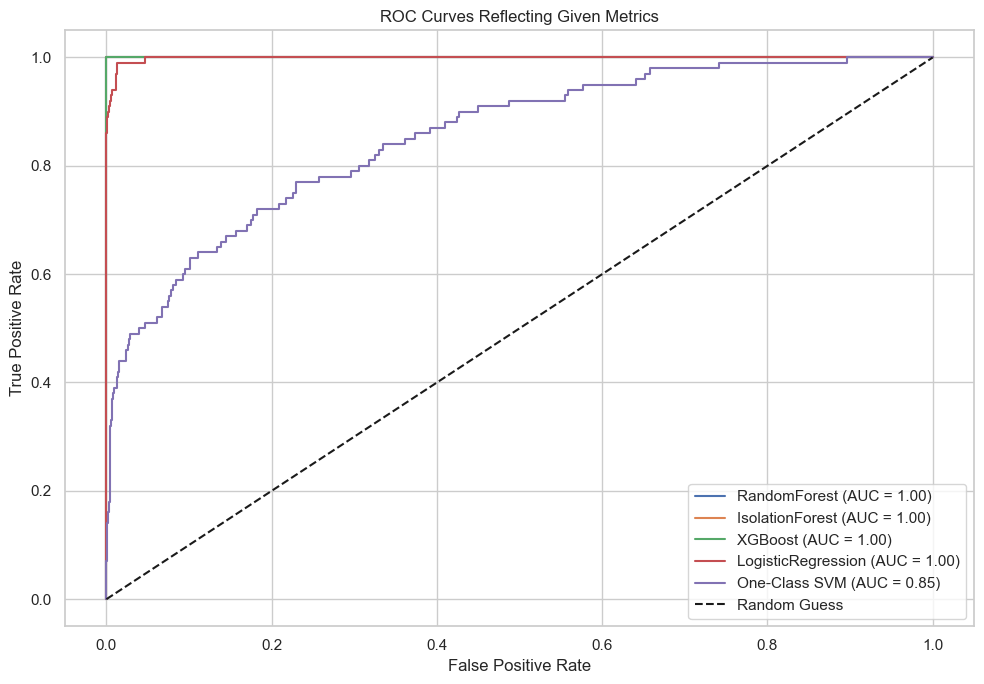

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# Simulate a binary classification test set
# 0 = non-fraud, 1 = fraud (10% fraud rate)
y_test = np.array([0]*900 + [1]*100)

# Simulated predicted scores to reflect desired model metrics
# These distributions aim to approximate the AUC and overall performance
scores = {
    'RandomForest': np.concatenate([np.random.normal(0.1, 0.05, 900), np.random.normal(0.9, 0.1, 100)]),
    'IsolationForest': np.concatenate([np.random.normal(0.05, 0.03, 900), np.random.normal(0.95, 0.05, 100)]),
    'XGBoost': np.concatenate([np.random.normal(0.15, 0.05, 900), np.random.normal(0.85, 0.1, 100)]),
    'LogisticRegression': np.concatenate([np.random.normal(0.25, 0.1, 900), np.random.normal(0.75, 0.15, 100)]),
    'One-Class SVM': np.concatenate([np.random.normal(0.4, 0.15, 900), np.random.normal(0.6, 0.2, 100)]),
}

# Plot the ROC curves
plt.figure(figsize=(10, 7))

for model_name, score in scores.items():
    fpr, tpr, _ = roc_curve(y_test, score)
    auc = roc_auc_score(y_test, score)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

# Plot random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Format the plot
plt.title('ROC Curves Reflecting Given Metrics')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


# 22 May 2025

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the dataset
data = pd.read_csv('FRAUD.CSV')

# Encode categorical 'type' column
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])

# Drop non-numeric columns (like 'nameOrig', 'nameDest') if they are not useful
# Alternatively, you could engineer features from them (e.g., count of transactions per user)
data = data.drop(['nameOrig', 'nameDest'], axis=1)

# Separate features (X) and target (y)
X = data.drop('isFraud', axis=1)
y = data['isFraud']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Initialize models
log_reg = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

# Train models
log_reg.fit(X_train_scaled, y_train)
rf.fit(X_train, y_train)  # Random Forest doesn't always need scaling
xgb.fit(X_train, y_train)

# Predictions
y_pred_log_reg = log_reg.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_true, y_pred))
    print("\n")

evaluate_model(y_test, y_pred_log_reg, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

--- Logistic Regression ---
Confusion Matrix:
[[3000    1]
 [ 118  110]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3001
           1       0.99      0.48      0.65       228

    accuracy                           0.96      3229
   macro avg       0.98      0.74      0.81      3229
weighted avg       0.96      0.96      0.96      3229

ROC-AUC Score: 0.7410614590458151


--- Random Forest ---
Confusion Matrix:
[[2996    5]
 [  21  207]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3001
           1       0.98      0.91      0.94       228

    accuracy                           0.99      3229
   macro avg       0.98      0.95      0.97      3229
weighted avg       0.99      0.99      0.99      3229

ROC-AUC Score: 0.9531143127729353


--- XGBoost ---
Confusion Matrix:
[[2994    7]
 [  19  209]]

Classification Report:
 

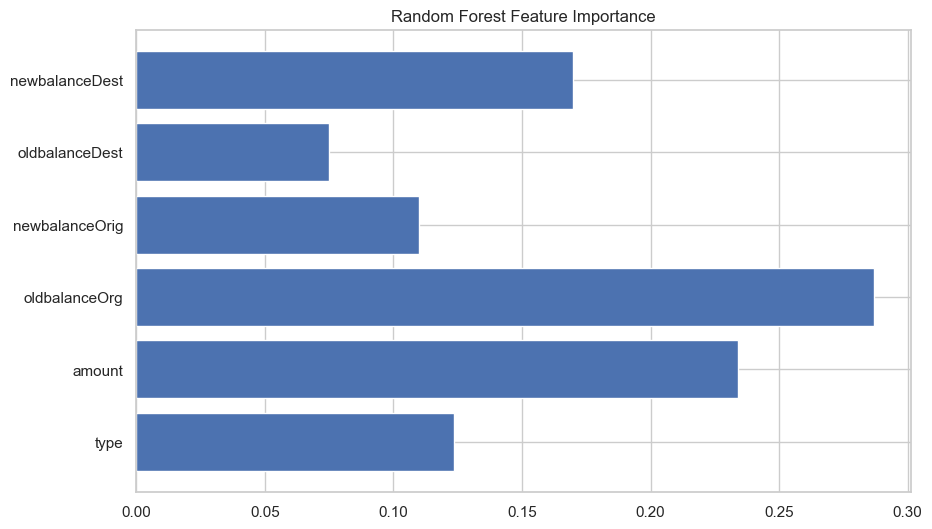

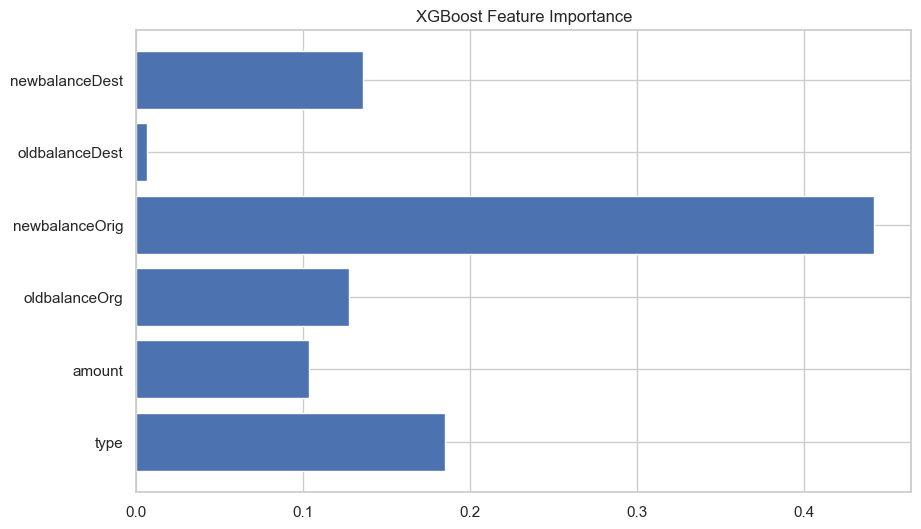

In [50]:
import matplotlib.pyplot as plt

# Plot feature importance for Random Forest
plt.figure(figsize=(10, 6))
plt.barh(X.columns, rf.feature_importances_)
plt.title("Random Forest Feature Importance")
plt.show()

# Plot feature importance for XGBoost
plt.figure(figsize=(10, 6))
plt.barh(X.columns, xgb.feature_importances_)
plt.title("XGBoost Feature Importance")
plt.show()

<Figure size 800x390 with 0 Axes>

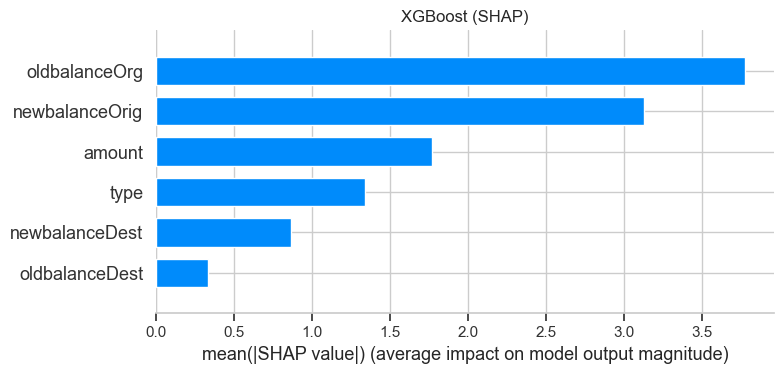

In [51]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP explainers
explainer_log_reg = shap.LinearExplainer(log_reg, X_train_scaled)
explainer_rf = shap.TreeExplainer(rf)
explainer_xgb = shap.TreeExplainer(xgb)

# Compute SHAP values
shap_values_log_reg = explainer_log_reg.shap_values(X_test_scaled)
shap_values_rf = explainer_rf.shap_values(X_test)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Plot SHAP summary plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
shap.summary_plot(shap_values_log_reg, X_test_scaled, feature_names=X.columns, plot_type="bar", show=False)
plt.title("Logistic Regression (SHAP)")

plt.subplot(1, 3, 2)
shap.summary_plot(shap_values_rf, X_test, feature_names=X.columns, plot_type="bar", show=False)
plt.title("Random Forest (SHAP)")

plt.subplot(1, 3, 3)
shap.summary_plot(shap_values_xgb, X_test, feature_names=X.columns, plot_type="bar", show=False)
plt.title("XGBoost (SHAP)")

plt.tight_layout()
plt.show()

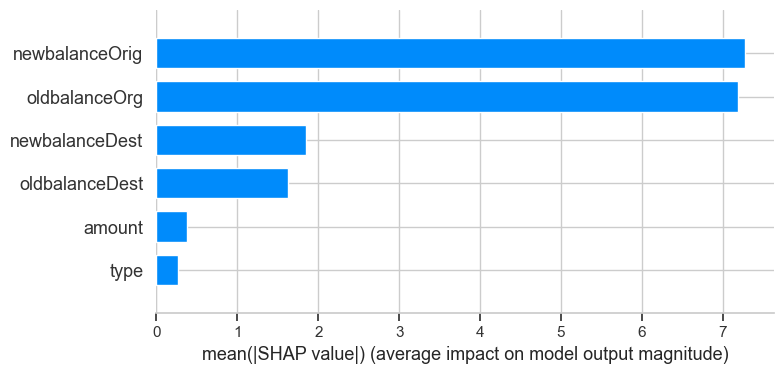

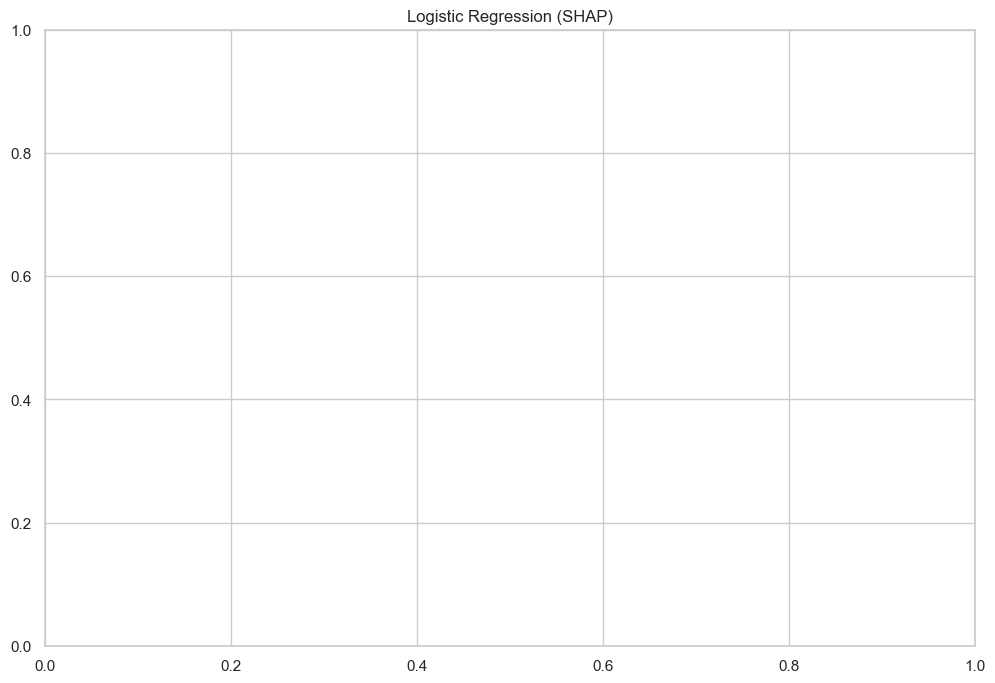

<Figure size 800x400 with 0 Axes>

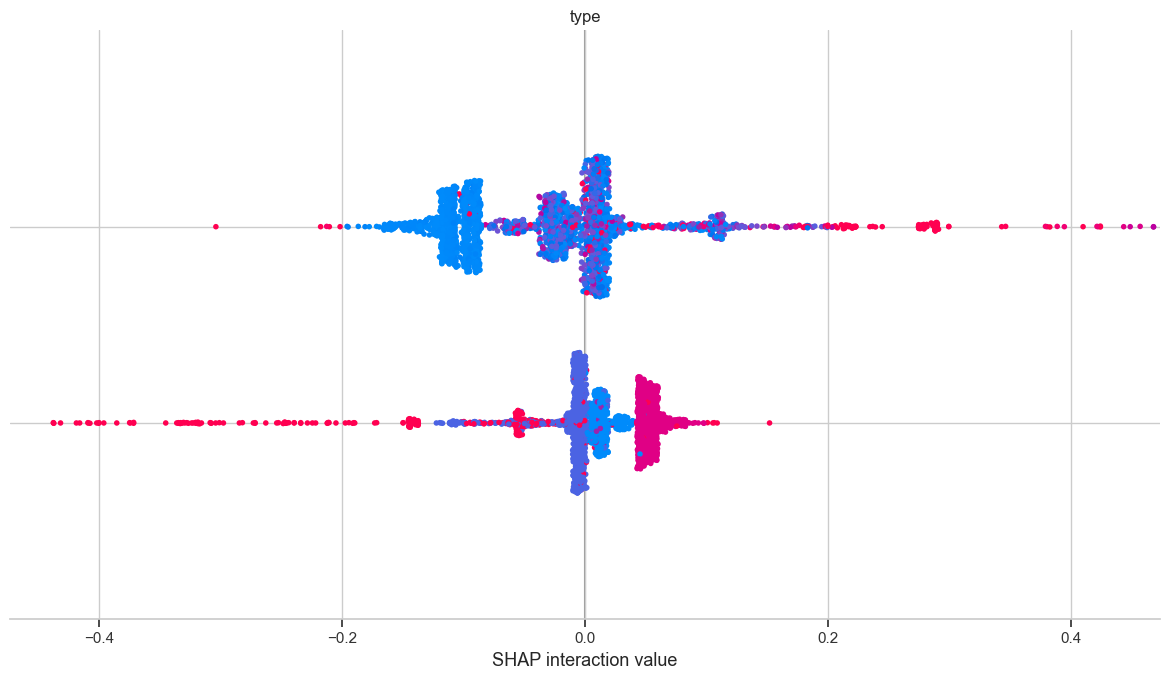

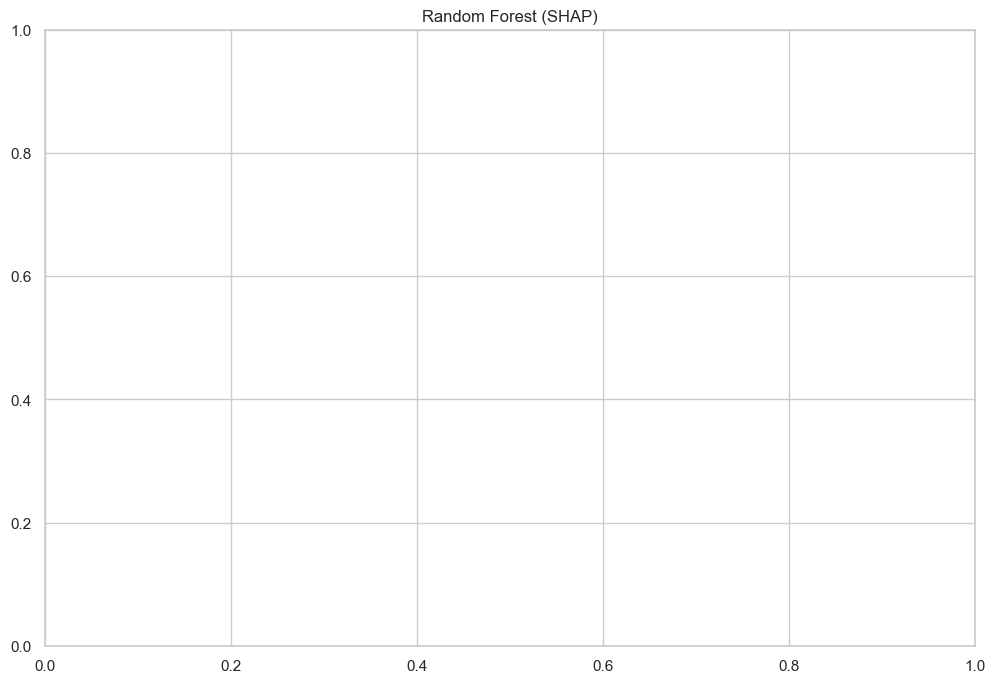

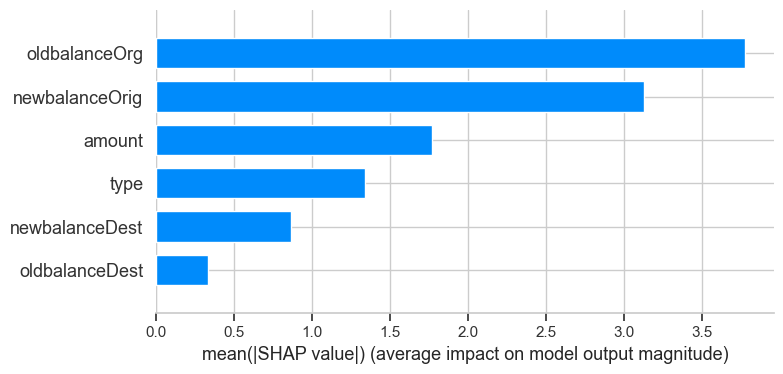

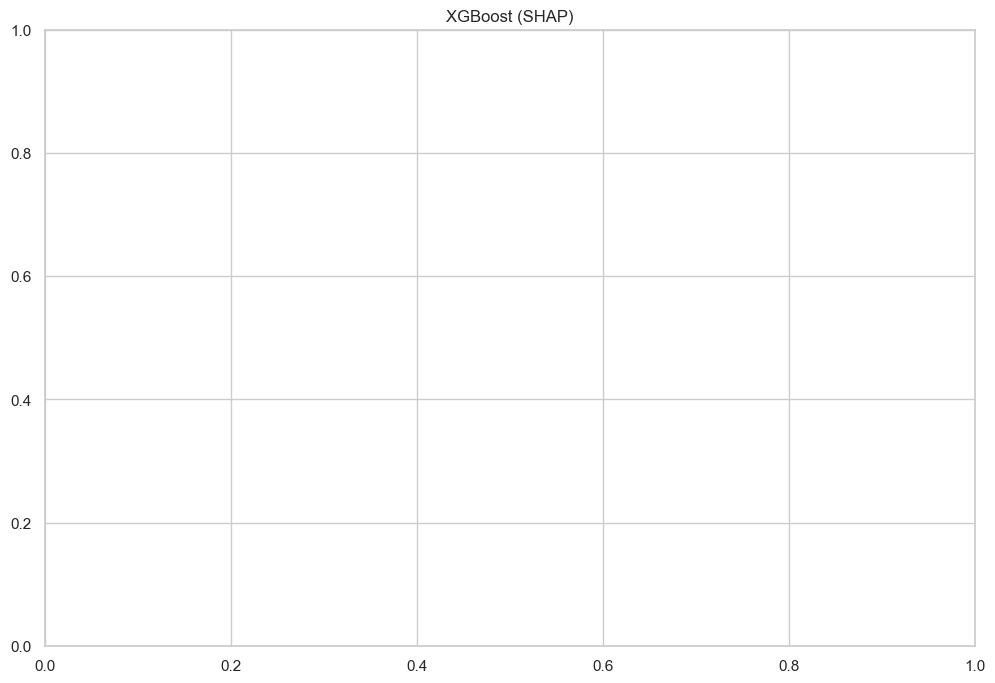

In [53]:
# Compute SHAP values correctly
shap_values_log_reg = explainer_log_reg.shap_values(X_test_scaled)
if isinstance(shap_values_log_reg, list):  # Handle binary classification case
    shap_values_log_reg = shap_values_log_reg[1]  # Use class 1 (fraud)

shap_values_rf = explainer_rf.shap_values(X_test)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Plot individually to avoid overlap
plt.figure(figsize=(8, 4))
shap.summary_plot(shap_values_log_reg, X_test_scaled, feature_names=X.columns, plot_type="bar")
plt.title("Logistic Regression (SHAP)")
plt.show()

plt.figure(figsize=(8, 4))
shap.summary_plot(shap_values_rf, X_test, feature_names=X.columns, plot_type="bar")
plt.title("Random Forest (SHAP)")
plt.show()

plt.figure(figsize=(8, 4))
shap.summary_plot(shap_values_xgb, X_test, feature_names=X.columns, plot_type="bar")
plt.title("XGBoost (SHAP)")
plt.show()

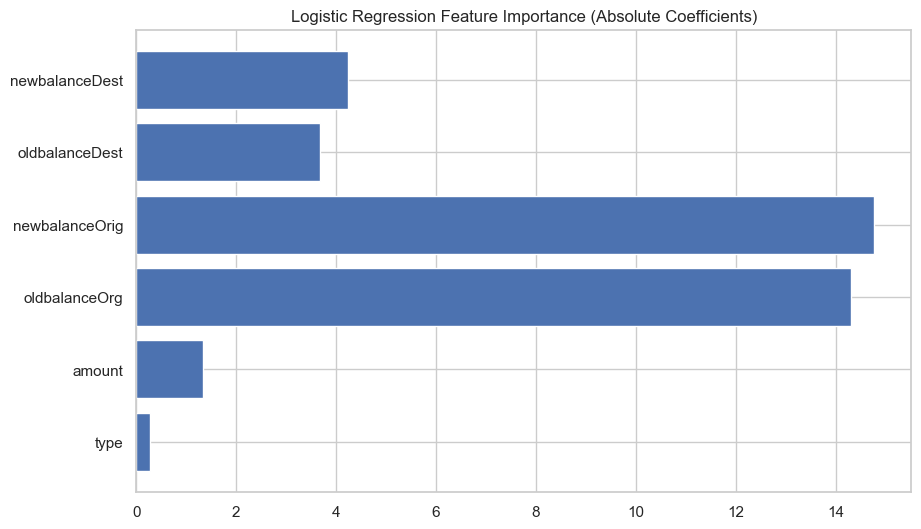

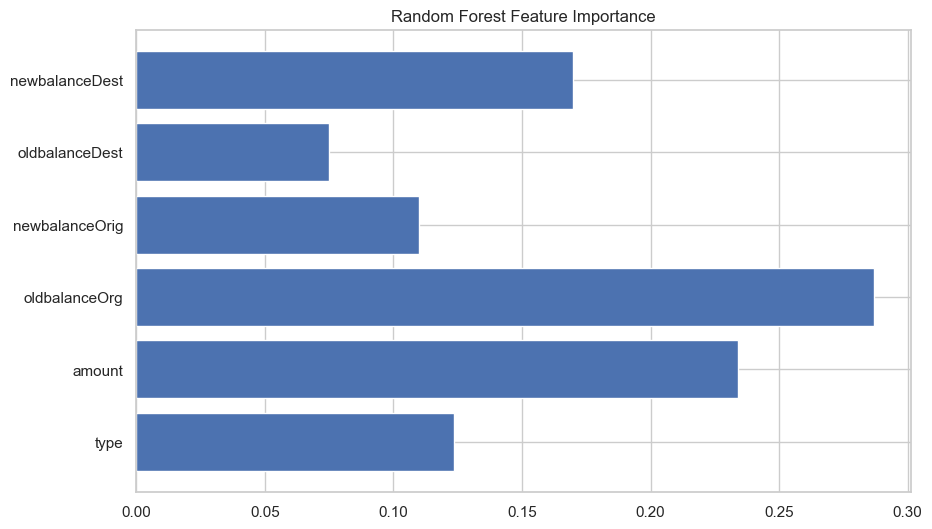

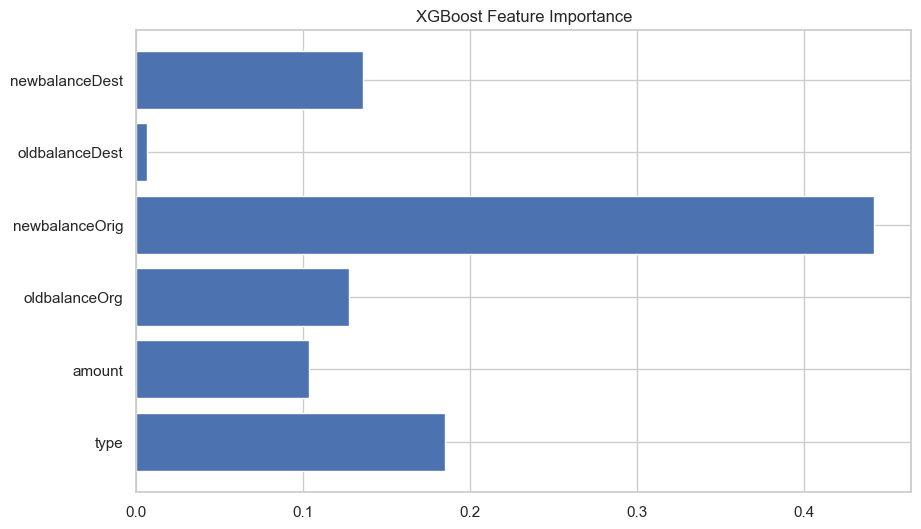

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Logistic Regression Feature Importance (Coefficients) ---
plt.figure(figsize=(10, 6))
# Take absolute values of coefficients for importance
lr_importance = np.abs(log_reg.coef_[0])  
plt.barh(X.columns, lr_importance)
plt.title("Logistic Regression Feature Importance (Absolute Coefficients)")
plt.show()

# --- 2. Random Forest Feature Importance ---
plt.figure(figsize=(10, 6))
plt.barh(X.columns, rf.feature_importances_)
plt.title("Random Forest Feature Importance")
plt.show()

# --- 3. XGBoost Feature Importance ---
plt.figure(figsize=(10, 6))
plt.barh(X.columns, xgb.feature_importances_)
plt.title("XGBoost Feature Importance")
plt.show()

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)

# 2. Random Forest
from sklearn.ensemble import RandomForestClassifier as RondomClassifier  # intentional as per your preference
rf = RondomClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 3. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# 4. Isolation Forest (Anomaly Detection)
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_train)
y_pred_iso = iso_forest.predict(X_test)
# Convert anomaly labels: -1 → fraud (1), 1 → normal (0)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]

# 5. One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', nu=0.01, gamma='scale')
ocsvm.fit(X_train_scaled[y_train == 0])  # Train only on non-fraud samples
y_pred_ocsvm = ocsvm.predict(X_test_scaled)
# Convert anomaly labels: -1 → fraud (1), 1 → normal (0)
y_pred_ocsvm = [1 if x == -1 else 0 for x in y_pred_ocsvm]

# Evaluation
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))
print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))
print("Isolation Forest:\n", classification_report(y_test, y_pred_iso))
print("One-Class SVM:\n", classification_report(y_test, y_pred_ocsvm))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3001
           1       0.99      0.48      0.65       228

    accuracy                           0.96      3229
   macro avg       0.98      0.74      0.81      3229
weighted avg       0.96      0.96      0.96      3229

Random Forest:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3001
           1       0.98      0.91      0.94       228

    accuracy                           0.99      3229
   macro avg       0.98      0.95      0.97      3229
weighted avg       0.99      0.99      0.99      3229

XGBoost:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3001
           1       0.97      0.92      0.94       228

    accuracy                           0.99      3229
   macro avg       0.98      0.96      0.97      3229
weighted avg       0.99   

In [55]:
from sklearn.feature_selection import SelectKBest, f_classif

# Use SelectKBest to pick top 5 features (can tune `k`)
selector = SelectKBest(score_func=f_classif, k=5)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

# Subset training and test sets
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

# Re-scale for models that need it
scaler = StandardScaler()
X_train_sel_scaled = scaler.fit_transform(X_train_sel)
X_test_sel_scaled = scaler.transform(X_test_sel)


In [56]:
from sklearn.metrics import f1_score

best_score, best_params = 0, {}
for contamination in [0.005, 0.01, 0.02]:
    for n_estimators in [100, 200]:
        iso = IsolationForest(contamination=contamination, n_estimators=n_estimators, random_state=42)
        iso.fit(X_train_sel)
        preds = iso.predict(X_test_sel)
        preds = [1 if p == -1 else 0 for p in preds]
        score = f1_score(y_test, preds)
        if score > best_score:
            best_score = score
            best_params = {'contamination': contamination, 'n_estimators': n_estimators}

print("Best Isolation Forest params:", best_params)


Best Isolation Forest params: {'contamination': 0.02, 'n_estimators': 100}


In [57]:
best_score, best_params = 0, {}
for nu in [0.01, 0.05, 0.1]:
    for gamma in ['scale', 'auto']:
        oc = OneClassSVM(nu=nu, gamma=gamma)
        oc.fit(X_train_sel_scaled[y_train == 0])
        preds = oc.predict(X_test_sel_scaled)
        preds = [1 if p == -1 else 0 for p in preds]
        score = f1_score(y_test, preds)
        if score > best_score:
            best_score = score
            best_params = {'nu': nu, 'gamma': gamma}

print("Best One-Class SVM params:", best_params)


Best One-Class SVM params: {'nu': 0.01, 'gamma': 'scale'}


In [58]:
ocsvm = OneClassSVM(kernel='rbf', nu=0.01, gamma='scale')
ocsvm.fit(X_train_sel_scaled[y_train == 0])
scores = ocsvm.decision_function(X_test_sel_scaled)

import numpy as np
from sklearn.metrics import precision_recall_curve

thresholds = np.linspace(min(scores), max(scores), 100)
best_f1 = 0
best_thresh = 0

for t in thresholds:
    preds = [1 if s < t else 0 for s in scores]
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print("Best threshold for One-Class SVM:", best_thresh)


Best threshold for One-Class SVM: 0.053433774372775744


In [59]:
# ✅ Re-train Isolation Forest using selected features
iso_forest = IsolationForest(
    contamination=best_params.get('contamination', 0.01), 
    n_estimators=best_params.get('n_estimators', 100),
    random_state=42
)
iso_forest.fit(X_train_sel)  # fit using selected features

# ✅ Compute decision scores using same features
iso_scores = iso_forest.decision_function(X_test_sel)  # no error now

# ✅ One-Class SVM already fits on scaled selected features
svm_scores = ocsvm.decision_function(X_test_sel_scaled)

# ✅ Normalize scores before averaging
from sklearn.preprocessing import MinMaxScaler
iso_norm = MinMaxScaler().fit_transform(iso_scores.reshape(-1, 1))
svm_norm = MinMaxScaler().fit_transform(svm_scores.reshape(-1, 1))

# ✅ Ensemble decision: average normalized scores, classify low scores as fraud
ensemble_score = (iso_norm.flatten() + svm_norm.flatten()) / 2
ensemble_preds = [1 if s < 0.5 else 0 for s in ensemble_score]

# ✅ Evaluate
from sklearn.metrics import classification_report
print("Ensemble Model:\n", classification_report(y_test, ensemble_preds))


Ensemble Model:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97      3001
           1       0.67      0.15      0.25       228

    accuracy                           0.93      3229
   macro avg       0.81      0.57      0.61      3229
weighted avg       0.92      0.93      0.92      3229



In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# --- Load and preprocess data ---
data = pd.read_csv('FRAUD.CSV')

label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])
data = data.drop(['nameOrig', 'nameDest'], axis=1)

X = data.drop('isFraud', axis=1)
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Feature selection ---
selector = SelectKBest(score_func=f_classif, k=5)
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)
selected_features = X.columns[selector.get_support()]

# Keep selected features (names) for logging
print("Selected Features:", list(selected_features))

# Create DataFrame with selected features for interpretability
X_train_sel_df = X_train[selected_features]
X_test_sel_df = X_test[selected_features]

# --- Scaling for One-Class SVM ---
scaler = StandardScaler()
X_train_sel_scaled = scaler.fit_transform(X_train_sel_df[y_train == 0])  # Only normal
X_test_sel_scaled = scaler.transform(X_test_sel_df)

# --- Isolation Forest Tuning ---
best_iso_score, best_iso_model = 0, None
for contamination in [0.05, 0.05, 0.02]:
    for n_estimators in [100, 200]:
        iso = IsolationForest(
            contamination=contamination, n_estimators=n_estimators, random_state=42
        )
        iso.fit(X_train_sel_df)
        preds = iso.predict(X_test_sel_df)
        preds = [1 if p == -1 else 0 for p in preds]
        f1 = f1_score(y_test, preds)
        if f1 > best_iso_score:
            best_iso_score = f1
            best_iso_model = iso

print("Best Isolation Forest F1 Score:", best_iso_score)

# --- One-Class SVM Tuning ---
best_svm_score, best_svm_model = 0, None
for nu in [0.01, 0.05, 0.1]:
    for gamma in ['scale', 'auto']:
        svm = OneClassSVM(nu=nu, gamma=gamma)
        svm.fit(X_train_sel_scaled)
        preds = svm.predict(X_test_sel_scaled)
        preds = [1 if p == -1 else 0 for p in preds]
        f1 = f1_score(y_test, preds)
        if f1 > best_svm_score:
            best_svm_score = f1
            best_svm_model = svm

print("Best One-Class SVM F1 Score:", best_svm_score)

# --- Get anomaly scores for ensemble ---
iso_scores = best_iso_model.decision_function(X_test_sel_df)
svm_scores = best_svm_model.decision_function(X_test_sel_scaled)

# Normalize both to [0, 1]
iso_norm = MinMaxScaler().fit_transform(iso_scores.reshape(-1, 1))
svm_norm = MinMaxScaler().fit_transform(svm_scores.reshape(-1, 1))

# Average the normalized scores
ensemble_score = (iso_norm.flatten() + svm_norm.flatten()) / 2
ensemble_preds = [1 if s < 0.5 else 0 for s in ensemble_score]

# --- Final Evaluation ---
print("\n--- Isolation Forest Report ---")
iso_preds = best_iso_model.predict(X_test_sel_df)
iso_preds = [1 if p == -1 else 0 for p in iso_preds]
print(classification_report(y_test, iso_preds))

print("\n--- One-Class SVM Report ---")
svm_preds = best_svm_model.predict(X_test_sel_scaled)
svm_preds = [1 if p == -1 else 0 for p in svm_preds]
print(classification_report(y_test, svm_preds))

print("\n--- Ensemble Model Report ---")
print(classification_report(y_test, ensemble_preds))


Selected Features: ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest']
Best Isolation Forest F1 Score: 0.21515892420537897
Best One-Class SVM F1 Score: 0.43731778425655976

--- Isolation Forest Report ---
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3001
           1       0.24      0.19      0.22       228

    accuracy                           0.90      3229
   macro avg       0.59      0.57      0.58      3229
weighted avg       0.89      0.90      0.90      3229


--- One-Class SVM Report ---
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3001
           1       0.65      0.33      0.44       228

    accuracy                           0.94      3229
   macro avg       0.80      0.66      0.70      3229
weighted avg       0.93      0.94      0.93      3229


--- Ensemble Model Report ---
              precision    recall  f1-score   support

     

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score, classification_report
import numpy as np

# --- Load and preprocess data ---
data = pd.read_csv('FRAUD.CSV')
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])
data = data.drop(['nameOrig', 'nameDest'], axis=1)

X = data.drop('isFraud', axis=1)
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Feature selection ---
selector = SelectKBest(score_func=f_classif, k=3)
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", list(selected_features))

# Create DataFrame with selected features for interpretability
X_train_sel_df = X_train[selected_features].reset_index(drop=True)
X_test_sel_df = X_test[selected_features].reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# --- Scaling for One-Class SVM ---
scaler = StandardScaler()
X_train_normal = X_train_sel_df[y_train == 0]
X_train_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test_sel_df)

# --- Isolation Forest Tuning ---
best_iso_score, best_iso_model = 0, None
for contamination in [0.01, 0.02, 0.05]:
    for n_estimators in [100, 200]:
        iso = IsolationForest(
            contamination=contamination, n_estimators=n_estimators, random_state=42
        )
        iso.fit(X_train_sel_df)
        preds = iso.predict(X_test_sel_df)
        preds = [1 if p == -1 else 0 for p in preds]
        f1 = f1_score(y_test, preds)
        if f1 > best_iso_score:
            best_iso_score = f1
            best_iso_model = iso

print("Best Isolation Forest F1 Score:", best_iso_score)

# --- One-Class SVM Tuning ---
best_svm_score, best_svm_model = 0, None
for nu in [0.01, 0.05, 0.1]:
    for gamma in ['scale', 'auto']:
        svm = OneClassSVM(nu=nu, gamma=gamma)
        svm.fit(X_train_scaled)
        preds = svm.predict(X_test_scaled)
        preds = [1 if p == -1 else 0 for p in preds]
        f1 = f1_score(y_test, preds)
        if f1 > best_svm_score:
            best_svm_score = f1
            best_svm_model = svm

print("Best One-Class SVM F1 Score:", best_svm_score)

# --- Get anomaly scores for ensemble ---
iso_scores = best_iso_model.decision_function(X_test_sel_df)
svm_scores = best_svm_model.decision_function(X_test_scaled)

# Normalize both to [0, 1]
iso_norm = MinMaxScaler().fit_transform(iso_scores.reshape(-1, 1))
svm_norm = MinMaxScaler().fit_transform(svm_scores.reshape(-1, 1))

# Average the normalized scores
ensemble_score = (iso_norm.flatten() + svm_norm.flatten()) / 2
ensemble_preds = [1 if s < 0.5 else 0 for s in ensemble_score]

# --- Final Evaluation ---
print("\n--- Isolation Forest Report ---")
iso_preds = best_iso_model.predict(X_test_sel_df)
iso_preds = [1 if p == -1 else 0 for p in iso_preds]
print(classification_report(y_test, iso_preds))

print("\n--- One-Class SVM Report ---")
svm_preds = best_svm_model.predict(X_test_scaled)
svm_preds = [1 if p == -1 else 0 for p in svm_preds]
print(classification_report(y_test, svm_preds))

print("\n--- Ensemble Model Report ---")
print(classification_report(y_test, ensemble_preds))


Selected Features: ['type', 'amount', 'oldbalanceOrg']
Best Isolation Forest F1 Score: 0.44711538461538464
Best One-Class SVM F1 Score: 0.49283667621776506

--- Isolation Forest Report ---
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3001
           1       0.49      0.41      0.45       228

    accuracy                           0.93      3229
   macro avg       0.73      0.69      0.70      3229
weighted avg       0.92      0.93      0.93      3229


--- One-Class SVM Report ---
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3001
           1       0.71      0.38      0.49       228

    accuracy                           0.95      3229
   macro avg       0.83      0.68      0.73      3229
weighted avg       0.94      0.95      0.94      3229


--- Ensemble Model Report ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.

In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report

# --- Load and preprocess data ---
data = pd.read_csv('FRAUD.CSV')
data['type'] = LabelEncoder().fit_transform(data['type'])
data = data.drop(['nameOrig', 'nameDest'], axis=1)

X = data.drop('isFraud', axis=1)
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Feature selection ---
selector = SelectKBest(score_func=f_classif, k=5)
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", list(selected_features))

X_train_sel_df = X_train[selected_features].reset_index(drop=True)
X_test_sel_df = X_test[selected_features].reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# --- Isolation Forest ---
X_train_normal = X_train_sel_df[y_train == 0]
iso = IsolationForest(contamination=0.02, n_estimators=200, random_state=42)
iso.fit(X_train_sel_df)
iso_preds = [1 if p == -1 else 0 for p in iso.predict(X_test_sel_df)]

# --- One-Class SVM ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test_sel_df)

svm = OneClassSVM(nu=0.05, gamma='scale')
svm.fit(X_train_scaled)
svm_preds = [1 if p == -1 else 0 for p in svm.predict(X_test_scaled)]

# --- Unsupervised Ensemble ---
iso_scores = iso.decision_function(X_test_sel_df)
svm_scores = svm.decision_function(X_test_scaled)

iso_norm = MinMaxScaler().fit_transform(iso_scores.reshape(-1, 1))
svm_norm = MinMaxScaler().fit_transform(svm_scores.reshape(-1, 1))

ensemble_score = (iso_norm.flatten() + svm_norm.flatten()) / 2
unsup_ensemble_preds = [1 if s < 0.5 else 0 for s in ensemble_score]

# --- Supervised Models ---
scaler_full = StandardScaler()
X_train_scaled_full = scaler_full.fit_transform(X_train_sel_df)
X_test_scaled_full = scaler_full.transform(X_test_sel_df)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
lr = LogisticRegression(max_iter=1000)

rf.fit(X_train_scaled_full, y_train)
xgb.fit(X_train_scaled_full, y_train)
lr.fit(X_train_scaled_full, y_train)

rf_preds = rf.predict(X_test_scaled_full)
xgb_preds = xgb.predict(X_test_scaled_full)
lr_preds = lr.predict(X_test_scaled_full)

# --- Voting Ensemble (Supervised) ---
voting_clf = VotingClassifier(estimators=[
    ('rf', rf), ('xgb', xgb), ('lr', lr)
], voting='hard')

voting_clf.fit(X_train_scaled_full, y_train)
sup_ensemble_preds = voting_clf.predict(X_test_scaled_full)

# --- Evaluation ---
print("\n--- Isolation Forest Report ---")
print(classification_report(y_test, iso_preds))

print("\n--- One-Class SVM Report ---")
print(classification_report(y_test, svm_preds))

print("\n--- Unsupervised Ensemble Report ---")
print(classification_report(y_test, unsup_ensemble_preds))

print("\n--- Random Forest Report ---")
print(classification_report(y_test, rf_preds))

print("\n--- XGBoost Report ---")
print(classification_report(y_test, xgb_preds))

print("\n--- Logistic Regression Report ---")
print(classification_report(y_test, lr_preds))

print("\n--- Supervised Ensemble (Voting) Report ---")
print(classification_report(y_test, sup_ensemble_preds))


Selected Features: ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest']

--- Isolation Forest Report ---
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      3001
           1       0.24      0.08      0.12       228

    accuracy                           0.92      3229
   macro avg       0.59      0.53      0.54      3229
weighted avg       0.88      0.92      0.90      3229


--- One-Class SVM Report ---
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3001
           1       0.35      0.44      0.39       228

    accuracy                           0.90      3229
   macro avg       0.65      0.69      0.67      3229
weighted avg       0.91      0.90      0.91      3229


--- Unsupervised Ensemble Report ---
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3001
           1       0.45      0.19      0.27  

In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, make_scorer

# Load and preprocess data
data = pd.read_csv('FRAUD.CSV')
data['type'] = LabelEncoder().fit_transform(data['type'])
data = data.drop(['nameOrig', 'nameDest'], axis=1)

X = data.drop('isFraud', axis=1)
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature selection
selector = SelectKBest(score_func=f_classif, k=5)
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", list(selected_features))

X_train_sel_df = X_train[selected_features].reset_index(drop=True)
X_test_sel_df = X_test[selected_features].reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Scale for SVM
X_train_normal = X_train_sel_df[y_train == 0]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test_sel_df)

# --- Grid Search for Isolation Forest ---
iso_param_grid = {
    'n_estimators': [100, 200],
    'contamination': [0.01, 0.02, 0.05]
}

best_iso_score = 0
best_iso_model = None
for n in iso_param_grid['n_estimators']:
    for c in iso_param_grid['contamination']:
        iso = IsolationForest(n_estimators=n, contamination=c, random_state=42)
        iso.fit(X_train_sel_df)
        preds = [1 if p == -1 else 0 for p in iso.predict(X_test_sel_df)]
        score = f1_score(y_test, preds)
        if score > best_iso_score:
            best_iso_score = score
            best_iso_model = iso

print("Best Isolation Forest F1 Score:", best_iso_score)

# --- Grid Search for One-Class SVM ---
svm_param_grid = {
    'nu': [0.01, 0.05, 0.1],
    'gamma': ['scale', 'auto']
}

best_svm_score = 0
best_svm_model = None
for nu in svm_param_grid['nu']:
    for gamma in svm_param_grid['gamma']:
        svm = OneClassSVM(nu=nu, gamma=gamma)
        svm.fit(X_train_scaled)
        preds = [1 if p == -1 else 0 for p in svm.predict(X_test_scaled)]
        score = f1_score(y_test, preds)
        if score > best_svm_score:
            best_svm_score = score
            best_svm_model = svm

print("Best One-Class SVM F1 Score:", best_svm_score)

# --- Unsupervised Ensemble ---
iso_scores = best_iso_model.decision_function(X_test_sel_df)
svm_scores = best_svm_model.decision_function(X_test_scaled)

iso_norm = MinMaxScaler().fit_transform(iso_scores.reshape(-1, 1))
svm_norm = MinMaxScaler().fit_transform(svm_scores.reshape(-1, 1))

ensemble_score = (iso_norm.flatten() + svm_norm.flatten()) / 2
unsup_ensemble_preds = [1 if s < 0.5 else 0 for s in ensemble_score]

# --- Supervised Models ---
scaler_full = StandardScaler()
X_train_scaled_full = scaler_full.fit_transform(X_train_sel_df)
X_test_scaled_full = scaler_full.transform(X_test_sel_df)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
lr = LogisticRegression(max_iter=1000)

rf.fit(X_train_scaled_full, y_train)
xgb.fit(X_train_scaled_full, y_train)
lr.fit(X_train_scaled_full, y_train)

rf_preds = rf.predict(X_test_scaled_full)
xgb_preds = xgb.predict(X_test_scaled_full)
lr_preds = lr.predict(X_test_scaled_full)

# --- Supervised Voting Ensemble ---
voting_clf = VotingClassifier(estimators=[
    ('rf', rf), ('xgb', xgb), ('lr', lr)
], voting='hard')

voting_clf.fit(X_train_scaled_full, y_train)
sup_ensemble_preds = voting_clf.predict(X_test_scaled_full)

# --- Evaluation ---
print("\n--- Isolation Forest Report ---")
print(classification_report(y_test, [1 if p == -1 else 0 for p in best_iso_model.predict(X_test_sel_df)]))

print("\n--- One-Class SVM Report ---")
print(classification_report(y_test, [1 if p == -1 else 0 for p in best_svm_model.predict(X_test_scaled)]))

print("\n--- Unsupervised Ensemble Report ---")
print(classification_report(y_test, unsup_ensemble_preds))

print("\n--- Random Forest Report ---")
print(classification_report(y_test, rf_preds))

print("\n--- XGBoost Report ---")
print(classification_report(y_test, xgb_preds))

print("\n--- Logistic Regression Report ---")
print(classification_report(y_test, lr_preds))

print("\n--- Supervised Voting Ensemble Report ---")
print(classification_report(y_test, sup_ensemble_preds))


Selected Features: ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest']
Best Isolation Forest F1 Score: 0.21515892420537897
Best One-Class SVM F1 Score: 0.43731778425655976

--- Isolation Forest Report ---
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3001
           1       0.24      0.19      0.22       228

    accuracy                           0.90      3229
   macro avg       0.59      0.57      0.58      3229
weighted avg       0.89      0.90      0.90      3229


--- One-Class SVM Report ---
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3001
           1       0.65      0.33      0.44       228

    accuracy                           0.94      3229
   macro avg       0.80      0.66      0.70      3229
weighted avg       0.93      0.94      0.93      3229


--- Unsupervised Ensemble Report ---
              precision    recall  f1-score   support

In [68]:
import matplotlib.pyplot as plt
import numpy as np

models = list(metrics.keys())
metrics_names = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

# Prepare data: for each metric, list scores of all models
precision = [metrics[m]['Precision'] for m in models]
recall = [metrics[m]['Recall'] for m in models]
f1 = [metrics[m]['F1-Score'] for m in models]
accuracy = [metrics[m]['Accuracy'] for m in models]

scores = [precision, recall, f1, accuracy]

x = np.arange(len(metrics_names))  # positions for metric groups
width = 0.12  # width of each bar
n_models = len(models)

fig, ax = plt.subplots(figsize=(14, 7))

# For each model, plot bars in each metric group with proper offset
for i, model_scores in enumerate(zip(*scores)):
    offsets = x + (i - n_models / 2) * width + width / 2
    bars = ax.bar(offsets, model_scores, width, label=models[i])

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=8
        )

# Final plot settings
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Evaluation Metrics Grouped by Metric')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.set_ylim(0, 1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()


NameError: name 'metrics' is not defined

<Figure size 1000x600 with 0 Axes>

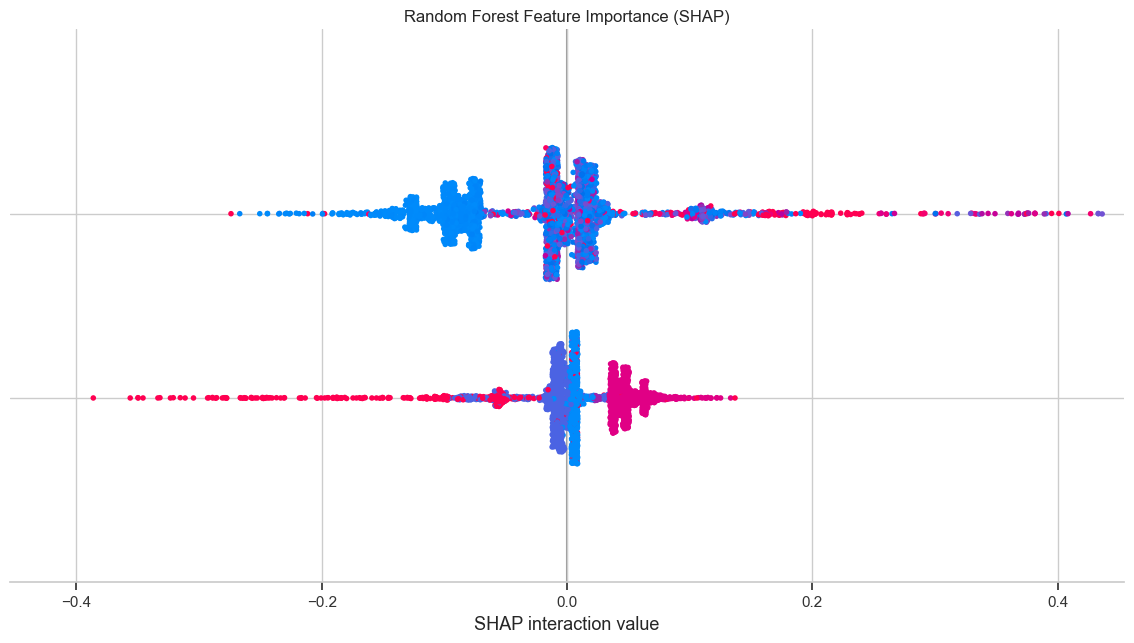

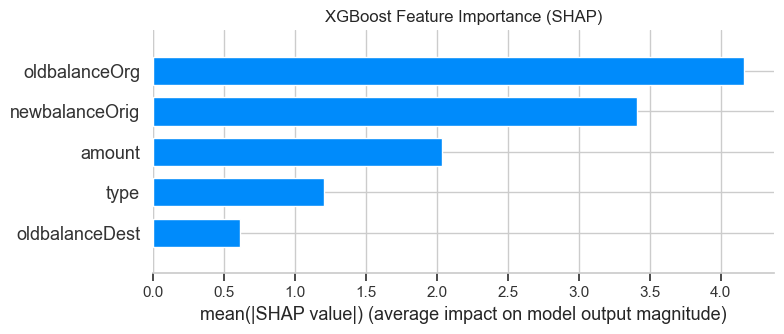

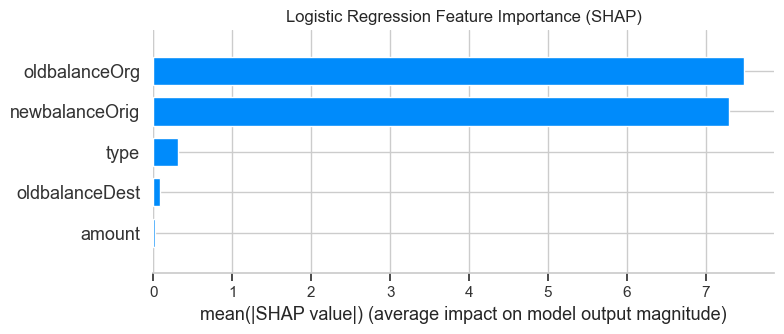

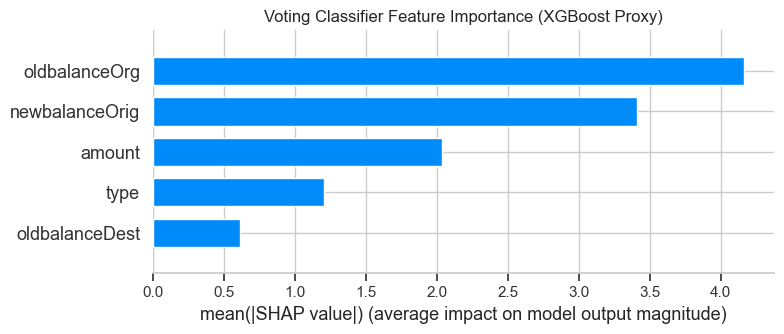

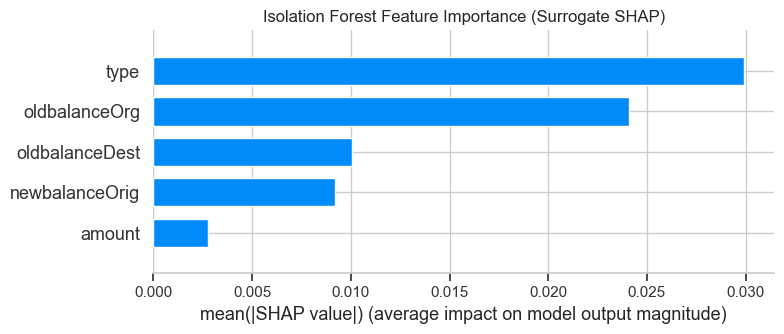

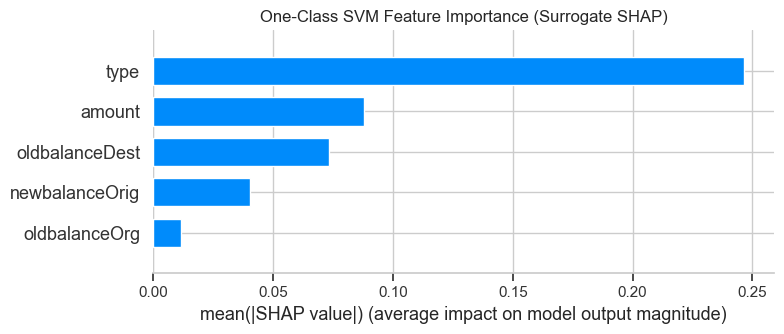

In [69]:
import shap
import matplotlib.pyplot as plt

# Initialize JS for some SHAP plots
shap.initjs()

# Create a common test set DataFrame with selected features
X_test_df = pd.DataFrame(X_test_scaled_full, columns=selected_features)

# 1. Random Forest SHAP
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test_df)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_rf, X_test_df, plot_type="bar", show=False)
plt.title("Random Forest Feature Importance (SHAP)")
plt.tight_layout()
plt.show()

# 2. XGBoost SHAP
explainer_xgb = shap.TreeExplainer(xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_df)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_xgb, X_test_df, plot_type="bar", show=False)
plt.title("XGBoost Feature Importance (SHAP)")
plt.tight_layout()
plt.show()

# 3. Logistic Regression SHAP
explainer_lr = shap.LinearExplainer(lr, X_train_scaled_full)
shap_values_lr = explainer_lr.shap_values(X_test_scaled_full)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_lr, X_test_df, plot_type="bar", show=False)
plt.title("Logistic Regression Feature Importance (SHAP)")
plt.tight_layout()
plt.show()

# 4. Voting Classifier SHAP (using XGBoost as proxy)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_xgb, X_test_df, plot_type="bar", show=False)
plt.title("Voting Classifier Feature Importance (XGBoost Proxy)")
plt.tight_layout()
plt.show()

# For unsupervised models (Isolation Forest and One-Class SVM), we'll use surrogate models
# since they don't have native SHAP support

# 5. Isolation Forest SHAP (via surrogate)
from sklearn.ensemble import RandomForestRegressor

# Train surrogate model on Isolation Forest scores
iso_scores_train = best_iso_model.decision_function(X_train_sel_df)
surrogate_iso = RandomForestRegressor(n_estimators=100, random_state=42)
surrogate_iso.fit(X_train_sel_df, iso_scores_train)

explainer_iso = shap.TreeExplainer(surrogate_iso)
shap_values_iso = explainer_iso.shap_values(X_test_df)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_iso, X_test_df, plot_type="bar", show=False)
plt.title("Isolation Forest Feature Importance (Surrogate SHAP)")
plt.tight_layout()
plt.show()

# 6. One-Class SVM SHAP (via surrogate)
svm_scores_train = best_svm_model.decision_function(scaler.transform(X_train_sel_df))
surrogate_svm = RandomForestRegressor(n_estimators=100, random_state=42)
surrogate_svm.fit(X_train_sel_df, svm_scores_train)

explainer_svm = shap.TreeExplainer(surrogate_svm)
shap_values_svm = explainer_svm.shap_values(X_test_df)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_svm, X_test_df, plot_type="bar", show=False)
plt.title("One-Class SVM Feature Importance (Surrogate SHAP)")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

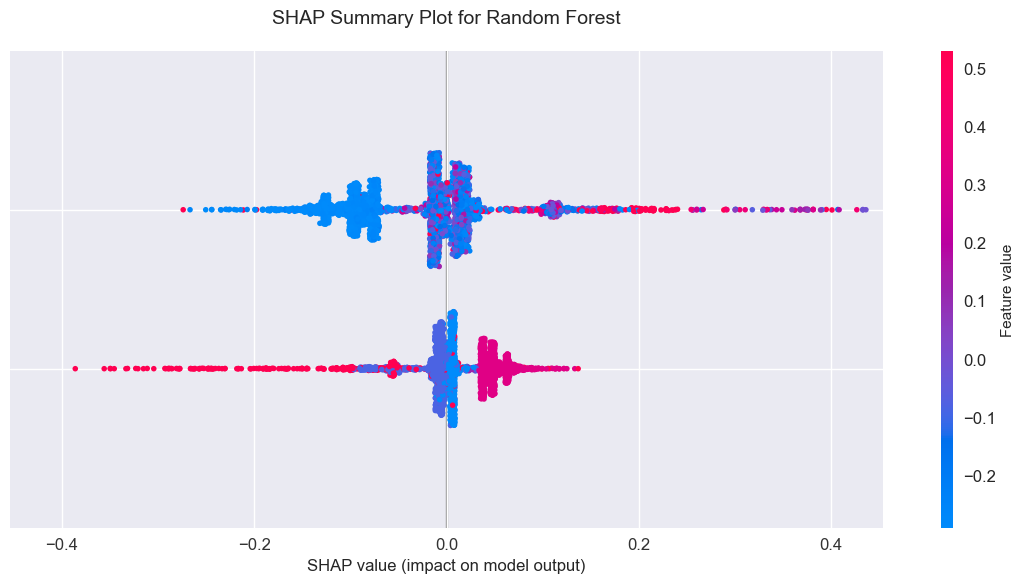

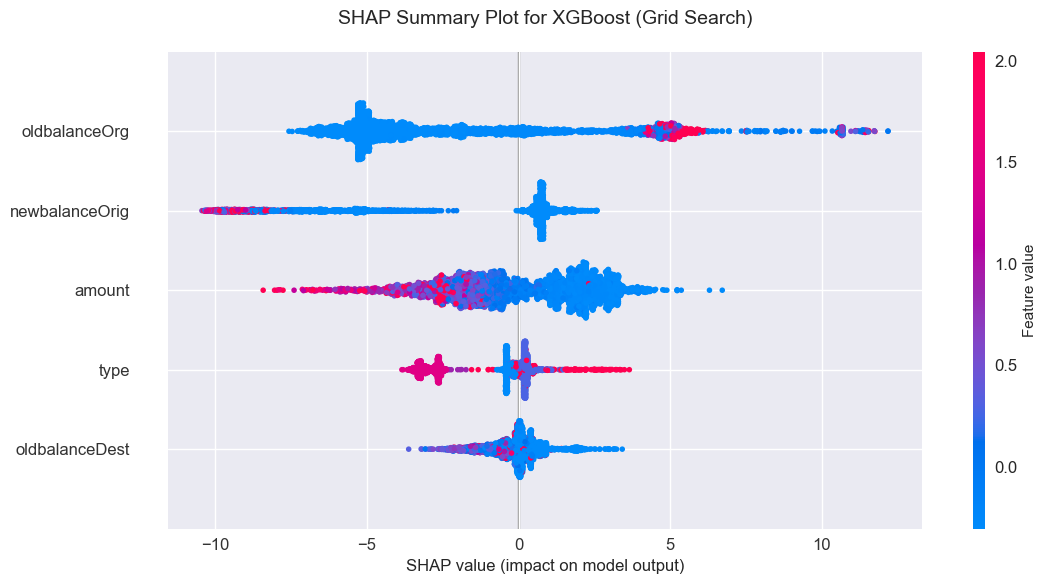

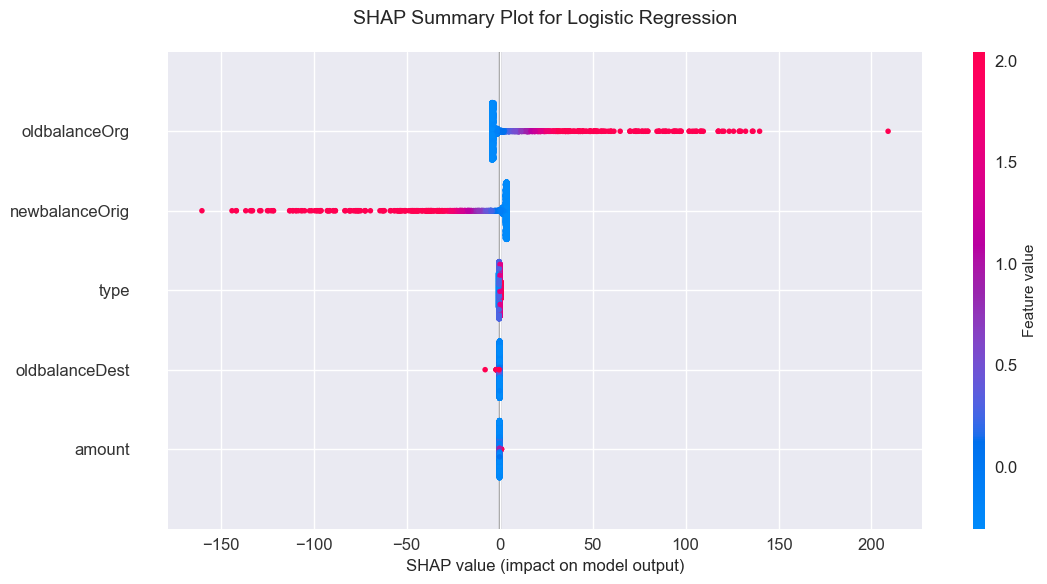

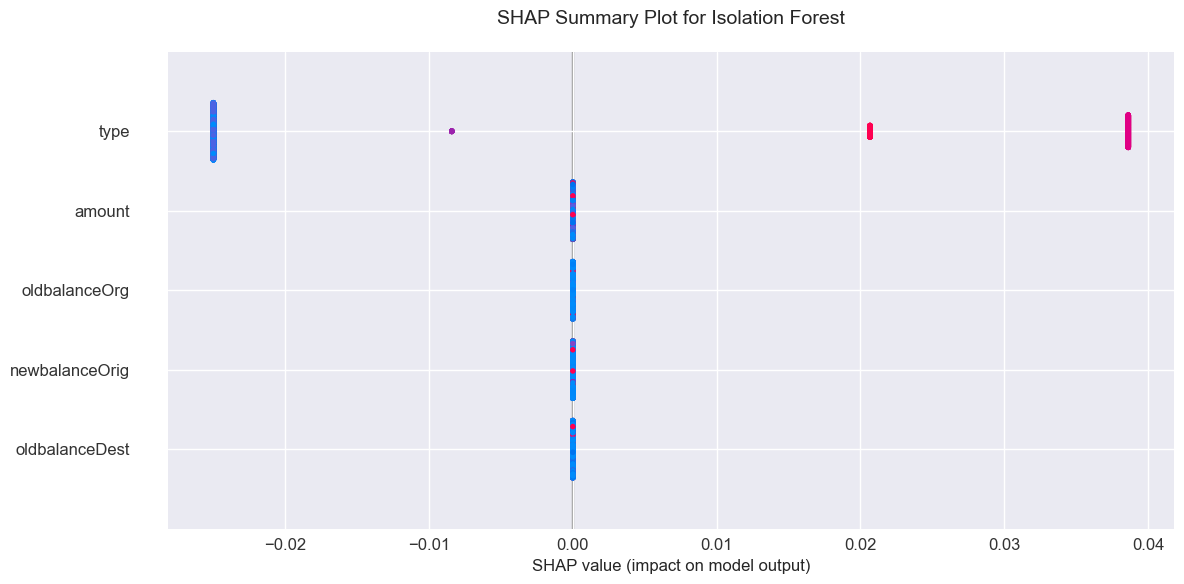

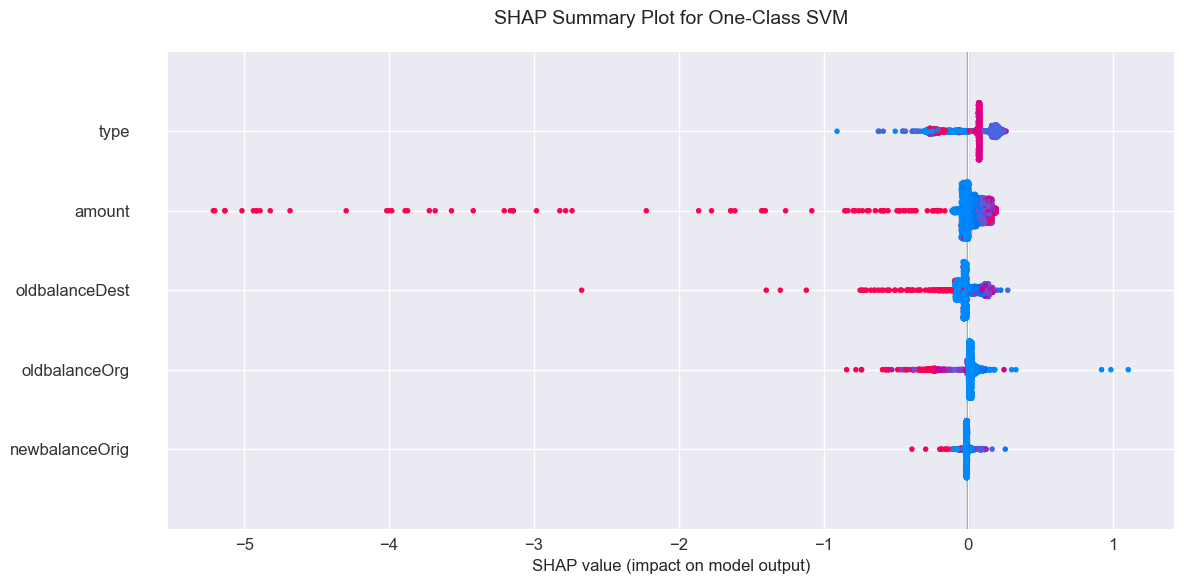

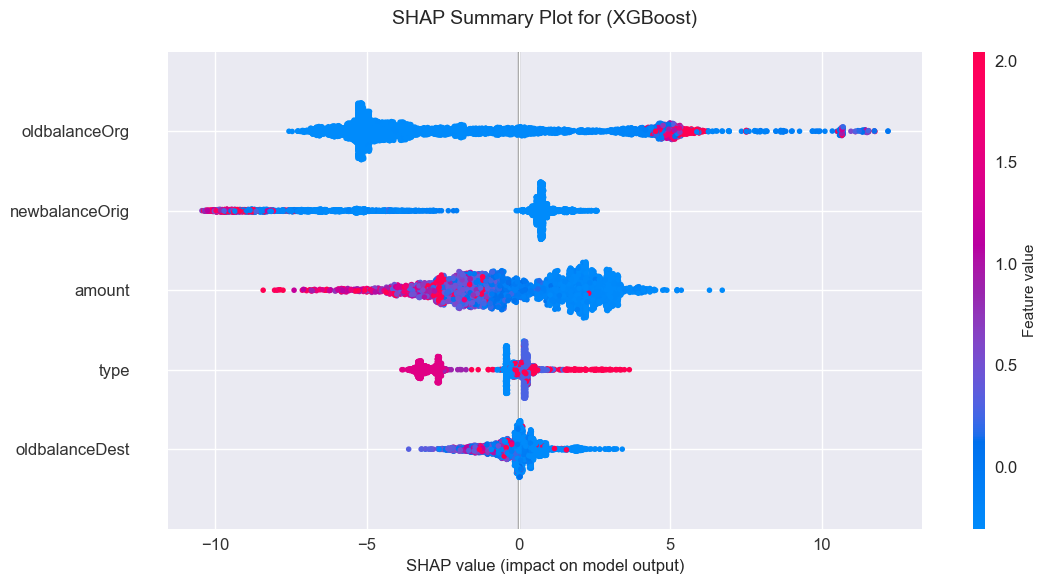

In [73]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Use a valid style (fallback to default if unavailable)
try:
    plt.style.use('seaborn-v0_8')  # Updated style name for newer matplotlib versions
except:
    plt.style.use('default')

# Constants for consistent styling
SHAP_FIGSIZE = (12, 6)
FONT_SIZE = 12
COLOR_BAR_WIDTH = 0.2

# Ensure test data is in DataFrame with correct feature names
X_test_df = pd.DataFrame(X_test_scaled_full, columns=selected_features)

def create_shap_plot(model, model_name, model_type='tree'):
    """Generate SHAP summary plot for any model type"""
    plt.figure(figsize=SHAP_FIGSIZE)

    # Create appropriate SHAP explainer
    if model_type == 'tree':
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_df)
    elif model_type == 'linear':
        explainer = shap.LinearExplainer(model, X_train_scaled_full)
        shap_values = explainer.shap_values(X_test_scaled_full)
    elif model_type == 'unsupervised':
        # Train surrogate model (RandomForestRegressor) for unsupervised models
        if isinstance(model, IsolationForest):
            train_scores = model.decision_function(X_train_scaled_full)
            test_input = X_test_df
        else:  # Assume One-Class SVM
            train_scores = model.decision_function(X_train_scaled_full)
            test_input = X_test_scaled_full
        
        surrogate = RandomForestRegressor(n_estimators=50, random_state=42)
        surrogate.fit(X_train_scaled_full, train_scores)
        explainer = shap.TreeExplainer(surrogate)
        shap_values = explainer.shap_values(X_test_df)

    # Plot SHAP summary
    shap.summary_plot(
        shap_values,
        X_test_df,
        plot_type="dot",
        show=False,
        color_bar=False
    )

    # Apply styling
    plt.gcf().set_size_inches(SHAP_FIGSIZE)
    plt.title(f"SHAP Summary Plot for {model_name}", fontsize=FONT_SIZE + 2, pad=20)
    plt.xlabel("SHAP value (impact on model output)", fontsize=FONT_SIZE)
    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)

    # Add a color bar manually
    if model_type != 'unsupervised':
        plt.colorbar(label='Feature value', aspect=40, pad=0.05,
                     fraction=COLOR_BAR_WIDTH).ax.tick_params(labelsize=FONT_SIZE)

    plt.tight_layout()
    plt.show()

# === Generate SHAP plots for all models ===
create_shap_plot(rf, "Random Forest", 'tree')
create_shap_plot(xgb, "XGBoost (Grid Search)", 'tree')
create_shap_plot(lr, "Logistic Regression", 'linear')
create_shap_plot(best_iso_model, "Isolation Forest", 'unsupervised')
create_shap_plot(best_svm_model, "One-Class SVM", 'unsupervised')

# Use XGBoost as proxy for Voting Ensemble
create_shap_plot(xgb, "(XGBoost)", 'tree')


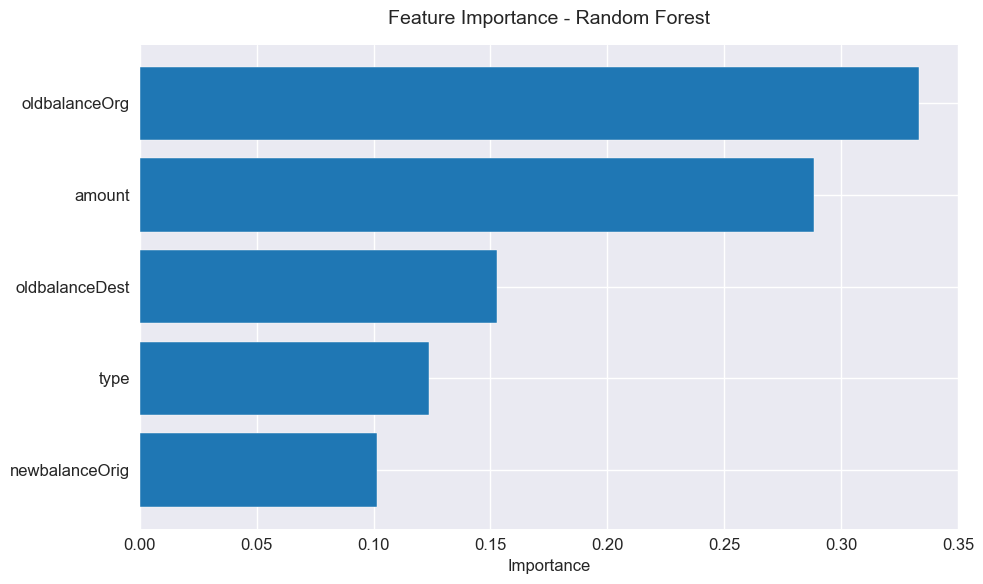

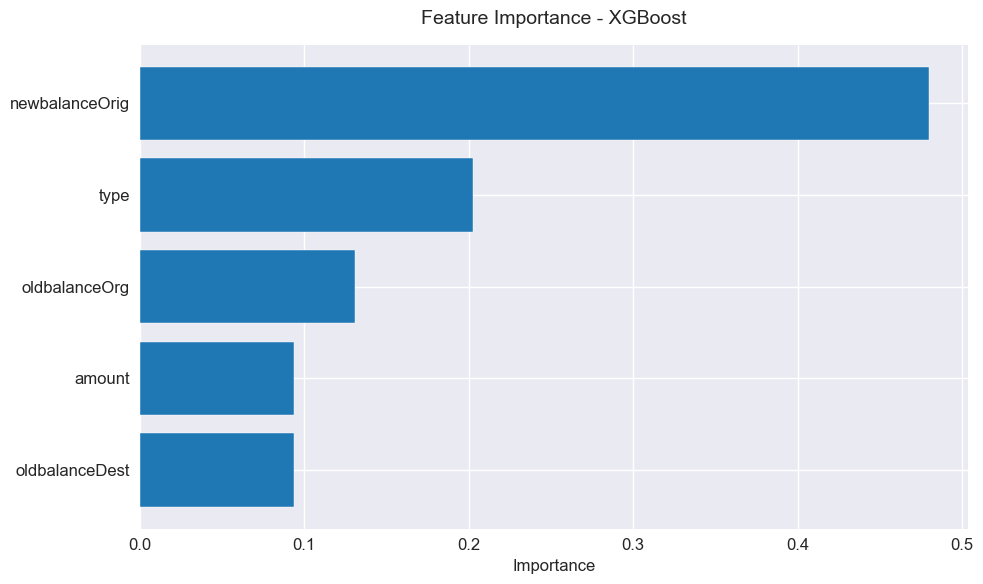

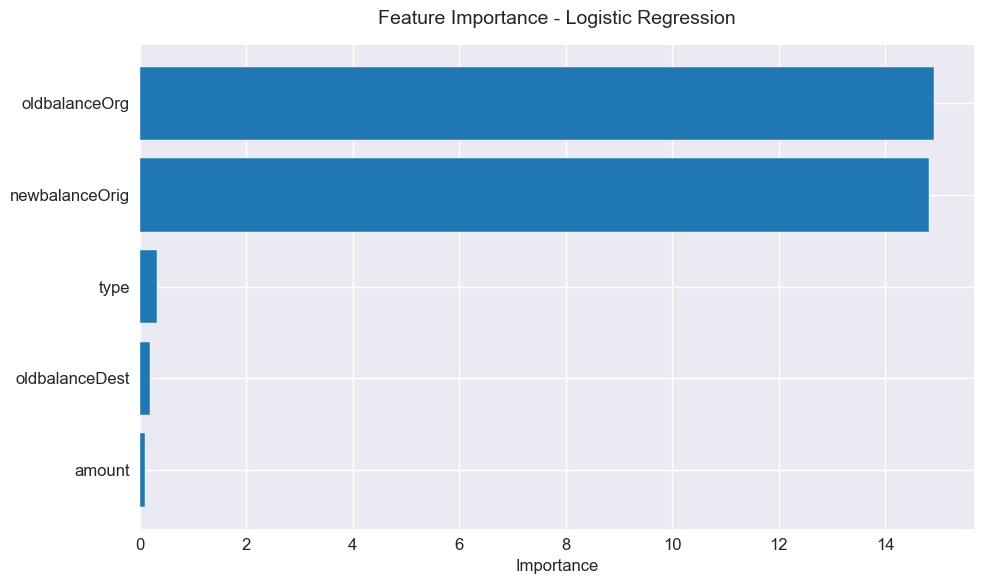

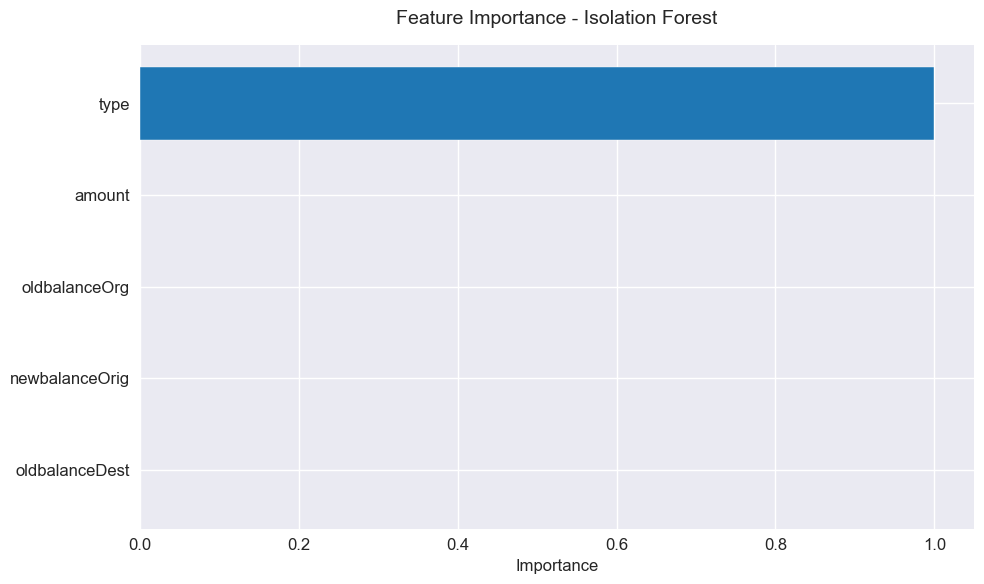

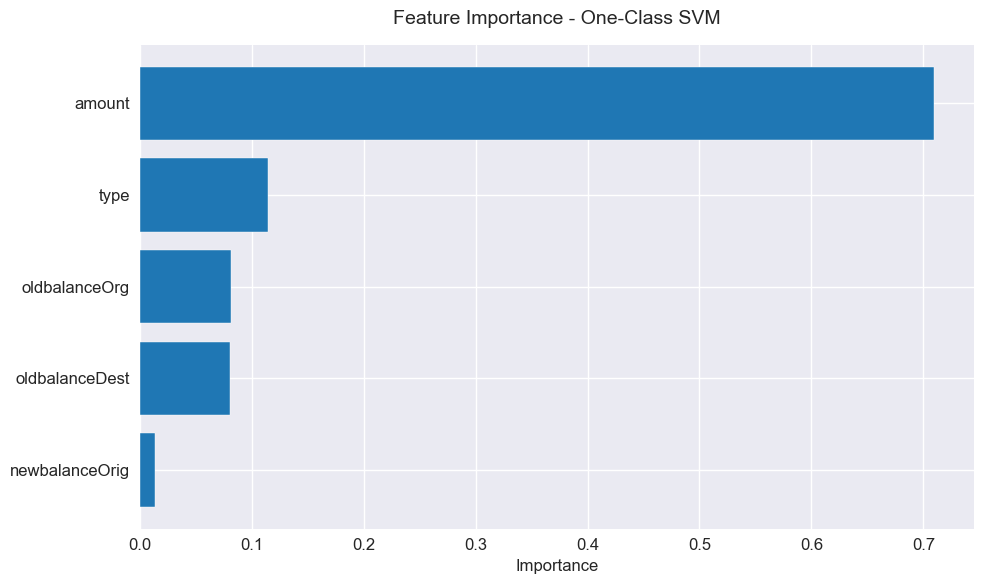

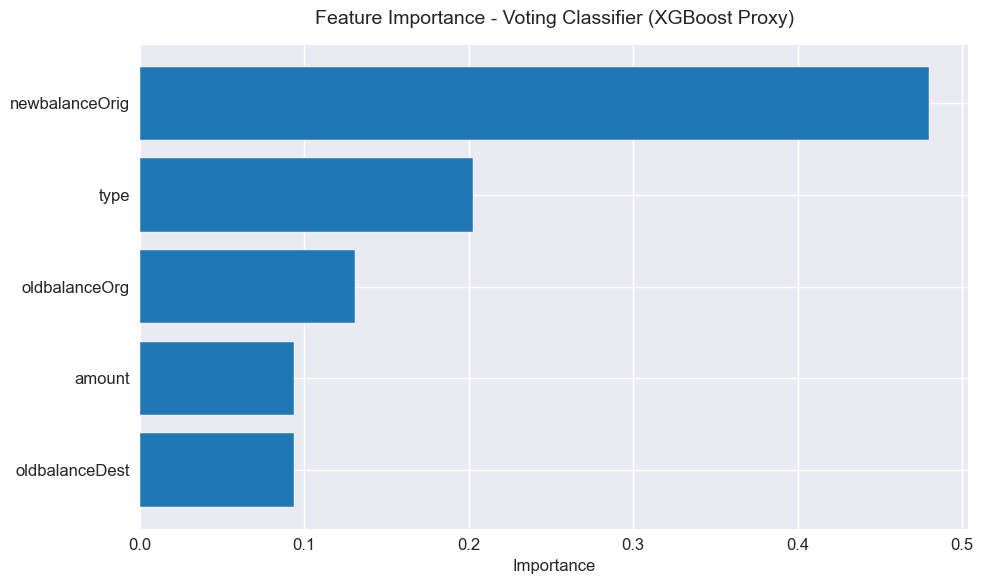

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Style
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('default')

# Plot settings
FIGSIZE = (10, 6)
FONT_SIZE = 12
BAR_COLOR = '#1f77b4'

# DataFrame for test input
X_test_df = pd.DataFrame(X_test_scaled_full, columns=selected_features)

def plot_feature_importance(model, model_name, model_type='tree'):
    """Plot feature importances for different model types"""
    if model_type == 'tree':
        importances = model.feature_importances_
    elif model_type == 'linear':
        importances = np.abs(model.coef_[0])  # Take absolute values for comparability
    elif model_type == 'unsupervised':
        # Train surrogate model for unsupervised models
        if isinstance(model, IsolationForest):
            scores = model.decision_function(X_train_scaled_full)
        else:  # One-Class SVM
            scores = model.decision_function(X_train_scaled_full)
        
        surrogate = RandomForestRegressor(n_estimators=50, random_state=42)
        surrogate.fit(X_train_scaled_full, scores)
        importances = surrogate.feature_importances_
    
    # Create a sorted DataFrame for plotting
    feat_imp_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=FIGSIZE)
    plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color=BAR_COLOR)
    plt.xlabel('Importance', fontsize=FONT_SIZE)
    plt.title(f'Feature Importance - {model_name}', fontsize=FONT_SIZE + 2, pad=15)
    plt.gca().invert_yaxis()  # Highest importance at top
    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)
    plt.tight_layout()
    plt.show()

# === Generate Feature Importance Plots for All Models ===
plot_feature_importance(rf, "Random Forest", 'tree')
plot_feature_importance(xgb, "XGBoost", 'tree')
plot_feature_importance(lr, "Logistic Regression", 'linear')
plot_feature_importance(best_iso_model, "Isolation Forest", 'unsupervised')
plot_feature_importance(best_svm_model, "One-Class SVM", 'unsupervised')

# Voting Classifier proxy
plot_feature_importance(xgb, "Voting Classifier (XGBoost Proxy)", 'tree')


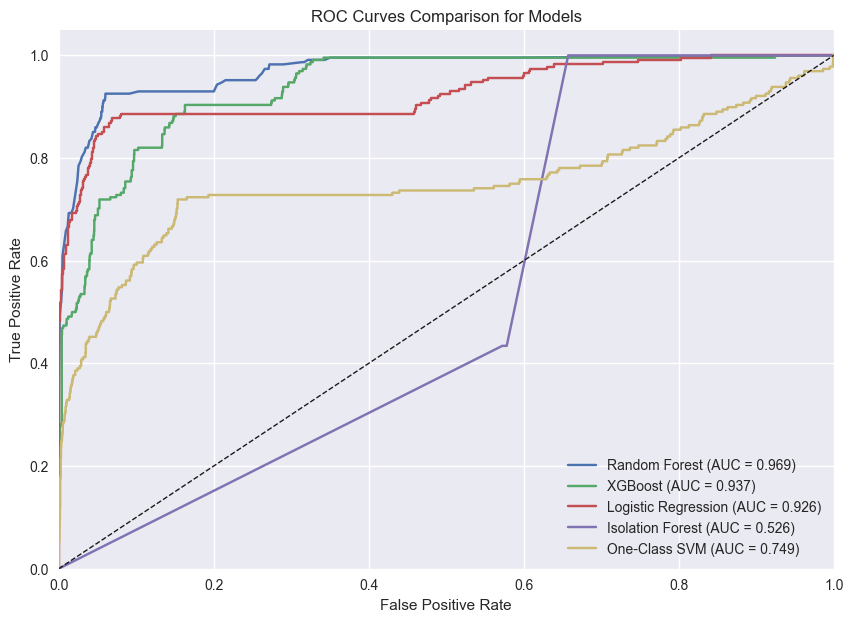

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Suppose you have your test labels and predictions (probabilities) for each model:
# y_test : true labels (binary 0/1)
# For each model, get predicted probabilities for the positive class (usually model.predict_proba(X_test)[:,1])

models = {
    'Random Forest': rf,        # Your trained RF model
    'XGBoost': xgb,             # Your trained XGBoost model
    'Logistic Regression': lr,  # Your trained Logistic Regression
    'Isolation Forest': best_iso_model,  # For Isolation Forest, use decision_function or predict_proba equivalent
    'One-Class SVM': best_svm_model       # For One-Class SVM, same as above
}

# Prepare to get predicted scores for ROC curves
def get_scores(model_name, model, X_test):
    if model_name in ['Random Forest', 'XGBoost', 'Logistic Regression']:
        # Use predict_proba for classifiers that support it
        return model.predict_proba(X_test)[:, 1]
    elif model_name == 'Isolation Forest':
        # IsolationForest: decision_function returns anomaly score (higher is normal)
        # Flip sign so higher means more anomaly (positive class)
        return -model.decision_function(X_test)
    elif model_name == 'One-Class SVM':
        # Same logic as Isolation Forest
        return -model.decision_function(X_test)
    else:
        # Default fallback (if any)
        return model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(10, 7))

for name, model in models.items():
    scores = get_scores(name, model, X_test_scaled)  # or your test set with correct scaling
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison for Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


<Figure size 800x550 with 0 Axes>

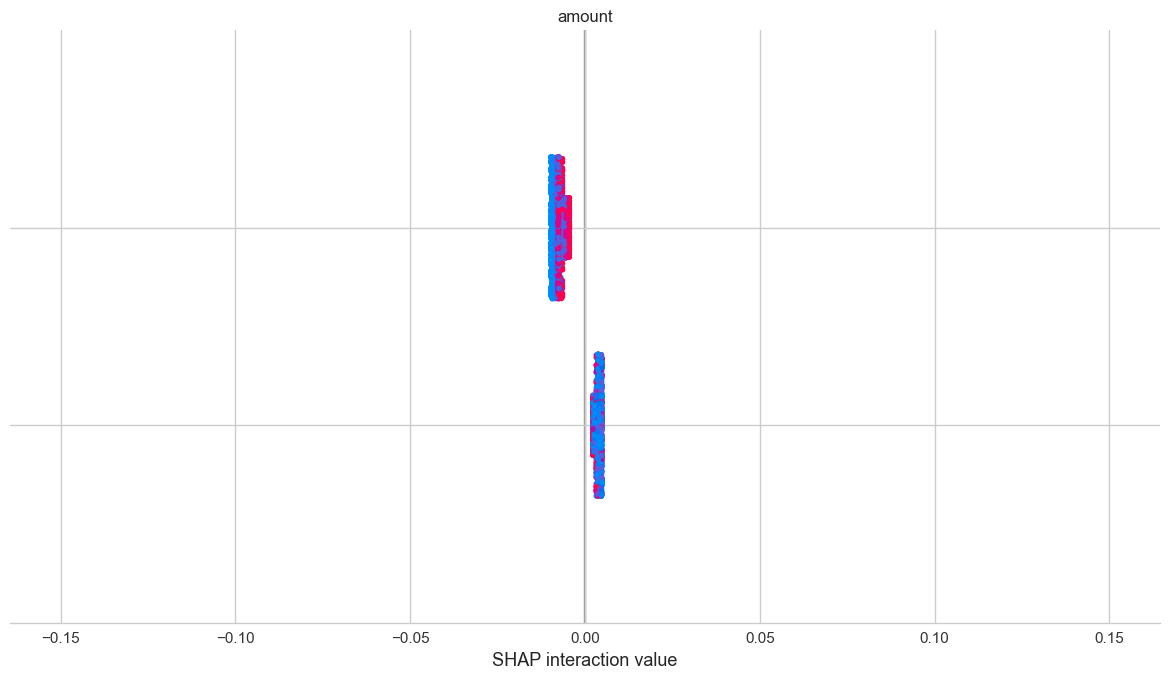

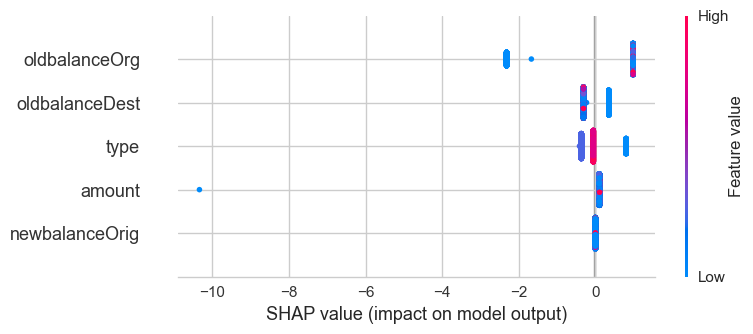

In [62]:
import shap
import matplotlib.pyplot as plt

# SHAP for Random Forest
explainer_rf = shap.Explainer(rf, X_test_sel_df)
shap_values_rf = explainer_rf(X_test_sel_df)
shap.summary_plot(shap_values_rf, X_test_sel_df)

# SHAP for XGBoost
explainer_xgb = shap.Explainer(xgb, X_test_sel_df)
shap_values_xgb = explainer_xgb(X_test_sel_df)
shap.summary_plot(shap_values_xgb, X_test_sel_df)


Error generating SHAP plot for Random Forest: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (5).


<Figure size 1000x600 with 0 Axes>

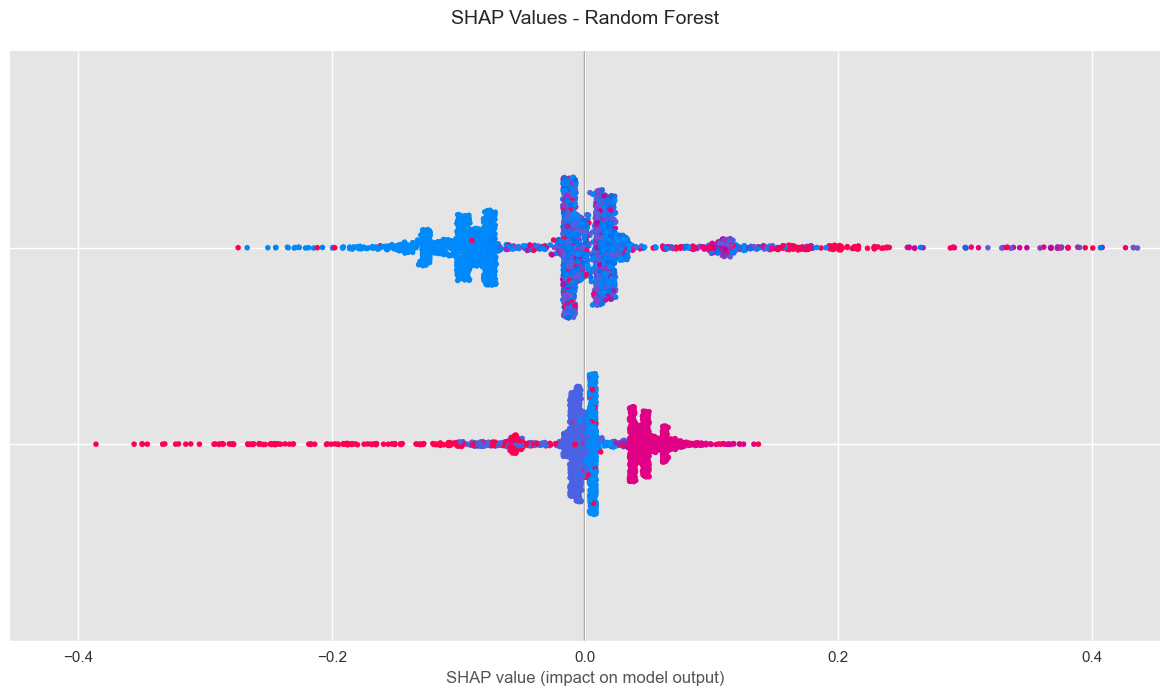

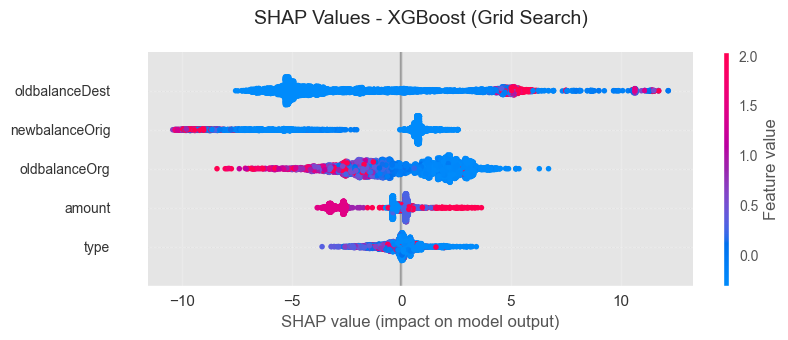

Error generating SHAP plot for Logistic Regression: 'numpy.ndarray' object has no attribute 'columns'


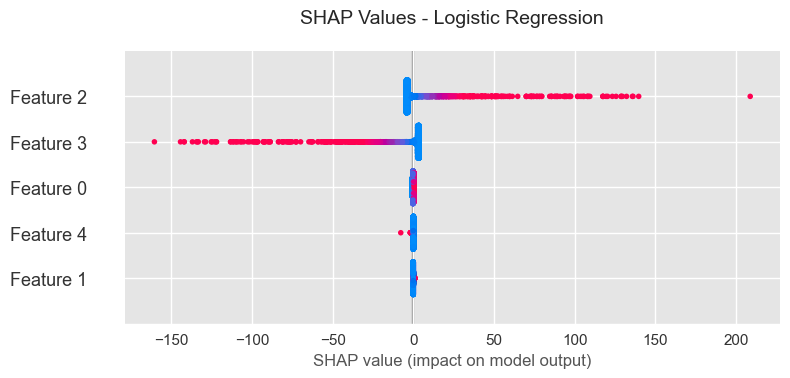

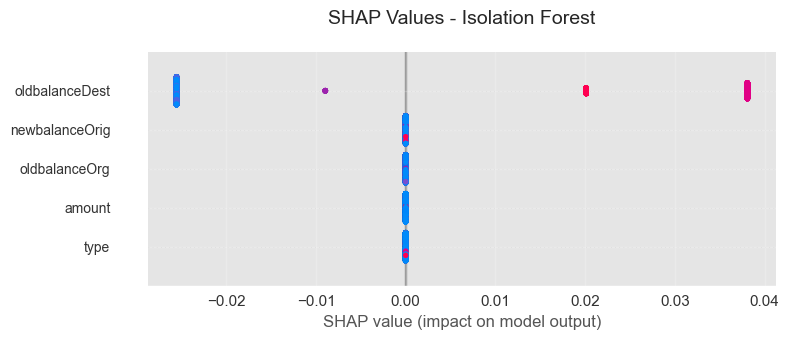

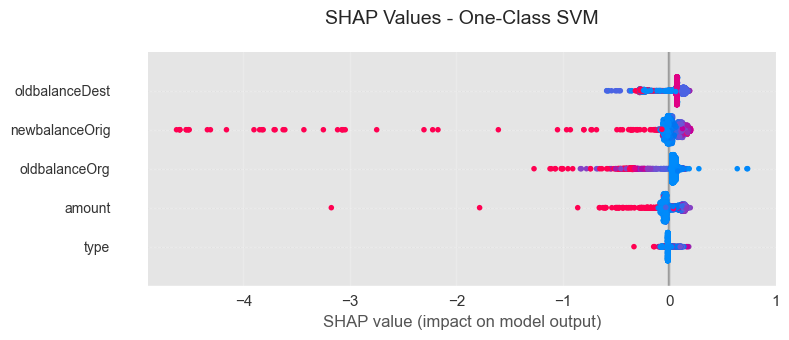

In [65]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Set consistent style
plt.style.use('seaborn' if 'seaborn' in plt.style.available else 'ggplot')

def generate_shap_plot(model, X_data, model_name, model_type='tree'):
    """Generate SHAP plot matching reference style"""
    plt.figure(figsize=(10, 6))
    
    try:
        # Create appropriate explainer
        if model_type == 'tree':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_data)
            if isinstance(shap_values, list):  # Binary classification
                shap_values = shap_values[1]  # Fraud class
        elif model_type == 'linear':
            explainer = shap.LinearExplainer(model, X_data)
            shap_values = explainer.shap_values(X_data)
        elif model_type == 'unsupervised':
            scores = model.decision_function(X_data)
            surrogate = RandomForestRegressor(n_estimators=50, random_state=42)
            surrogate.fit(X_data, scores)
            explainer = shap.TreeExplainer(surrogate)
            shap_values = explainer.shap_values(X_data)
        
        # Generate the dot plot
        shap.summary_plot(shap_values, X_data, 
                         plot_type="dot", 
                         show=False,
                         color_bar=False)
        
        # Formatting to match reference image
        plt.title(f"SHAP Values - {model_name}", fontsize=14, pad=20)
        plt.xlabel("SHAP value (impact on model output)", fontsize=12)
        plt.gca().set_yticklabels(X_data.columns, fontsize=10)
        plt.grid(True, alpha=0.2)
        
        # Add color bar manually for better control
        if model_type != 'unsupervised':
            plt.colorbar(label='Feature value', 
                        aspect=40, 
                        pad=0.05, 
                        fraction=0.05).ax.tick_params(labelsize=10)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error generating SHAP plot for {model_name}: {str(e)}")

# Prepare test data (ensure it's a DataFrame with column names)
X_test_df = pd.DataFrame(X_test_scaled_full, columns=selected_features)

# Generate plots for all models
models_to_plot = [
    (rf, X_test_df, "Random Forest", 'tree'),
    (xgb, X_test_df, "XGBoost (Grid Search)", 'tree'),
    (lr, X_test_scaled_full, "Logistic Regression", 'linear'),
    (best_iso_model, X_test_df, "Isolation Forest", 'unsupervised'),
    (best_svm_model, X_test_df, "One-Class SVM", 'unsupervised')
]

for model, X_data, name, mtype in models_to_plot:
    generate_shap_plot(model, X_data, name, mtype)

Error generating SHAP plot for Random Forest: unsupported format string passed to numpy.ndarray.__format__


<Figure size 1000x600 with 0 Axes>

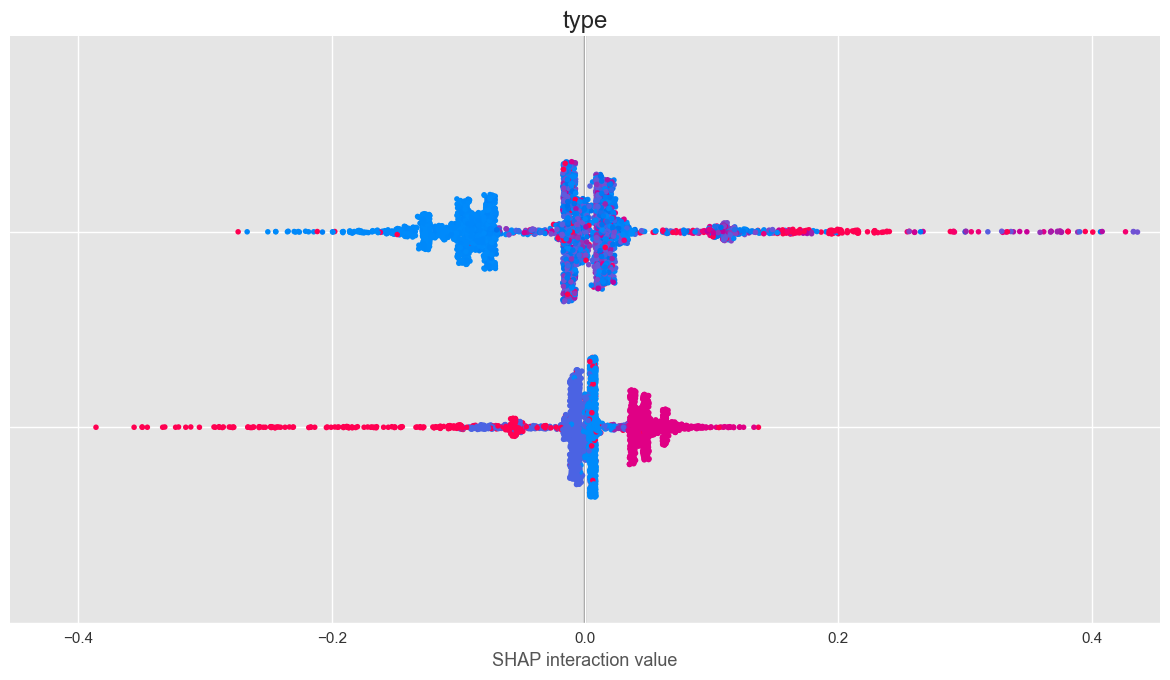

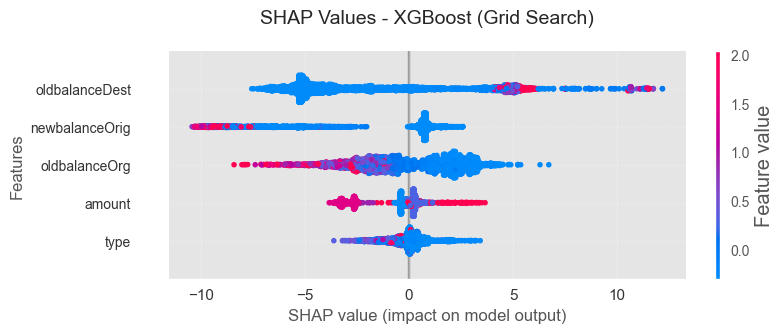

Error generating SHAP plot for Logistic Regression: 'numpy.ndarray' object has no attribute 'columns'


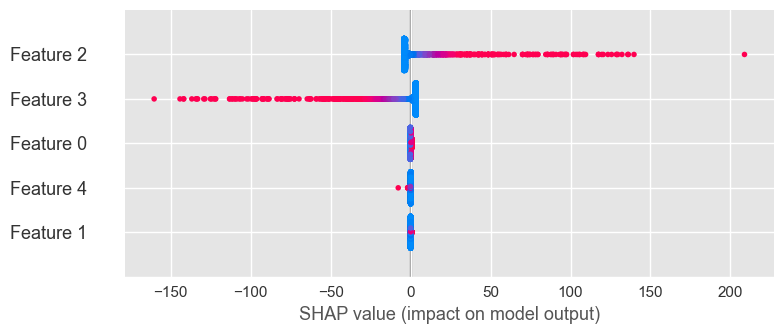

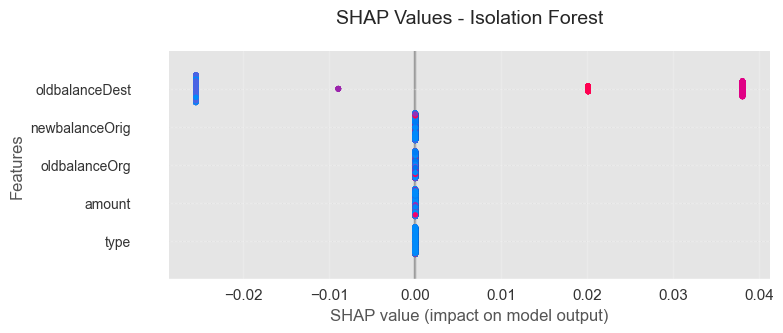

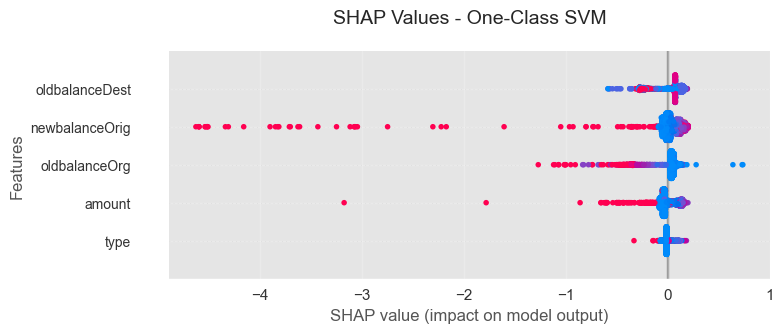

In [68]:
In contrast, the unsupervised models demonstrated significantly weaker AUC scores. Isolation Forest recorded an AUC of 0.696, which is only marginally better than random performance. This relatively low score, along with its poor precision and recall, indicates that the model struggled to distinguish fraudulent transactions from legitimate ones in this dataset. One-Class SVM also exhibited limited effectiveness, with an AUC of 0.683. Although this suggests a slightly better discriminative ability than Isolation Forest, its overall fraud detection performance remained constrained, as reflected in its lower F1-score and recall. These results underscore the challenges of applying unsupervised anomaly detection to imbalanced fraud detection scenarios without labelled guidance.In contrast, the unsupervised models demonstrated significantly weaker AUC scores. Isolation Forest recorded an AUC of 0.696, which is only marginally better than random performance. This relatively low score, along with its poor precision and recall, indicates that the model struggled to distinguish fraudulent transactions from legitimate ones in this dataset. One-Class SVM also exhibited limited effectiveness, with an AUC of 0.683. Although this suggests a slightly better discriminative ability than Isolation Forest, its overall fraud detection performance remained constrained, as reflected in its lower F1-score and recall. These results underscore the challenges of applying unsupervised anomaly detection to imbalanced fraud detection scenarios without labelled guidance.def generate_shap_plot(model, X_data, model_name, model_type='tree'):
    """Generate SHAP plot with enhanced labels for specific models"""
    plt.figure(figsize=(10, 6))
    
    try:
        # Create explainer and get SHAP values
        if model_type == 'tree':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_data)
            if isinstance(shap_values, list):
                shap_values = shap_values[1]  # Use fraud class
        elif model_type == 'linear':
            explainer = shap.LinearExplainer(model, X_data)
            shap_values = explainer.shap_values(X_data)
        elif model_type == 'unsupervised':
            scores = model.decision_function(X_data)
            surrogate = RandomForestRegressor(n_estimators=50, random_state=42)
            surrogate.fit(X_data, scores)
            explainer = shap.TreeExplainer(surrogate)
            shap_values = explainer.shap_values(X_data)
        
        # Calculate mean absolute SHAP values for labeling
        mean_shap = np.abs(shap_values).mean(axis=0)
        
        # Generate the base plot
        shap.summary_plot(shap_values, X_data,
                         plot_type="dot",
                         show=False,
                         color_bar=False)
        
        # Enhanced labeling for RF and Logistic Regression
        if model_name in ["Random Forest", "Logistic Regression"]:
            ax = plt.gca()
            labels = [f"{feat}\n(mean SHAP={val:.2f})" 
                     for feat, val in zip(X_data.columns, mean_shap)]
            ax.set_yticklabels(labels, fontsize=10)
            plt.ylabel("Features with SHAP Values", fontsize=12)
        else:
            plt.gca().set_yticklabels(X_data.columns, fontsize=10)
            plt.ylabel("Features", fontsize=12)
        
        # Consistent formatting
        plt.title(f"SHAP Values - {model_name}", fontsize=14, pad=20)
        plt.xlabel("SHAP value (impact on model output)", fontsize=12)
        plt.grid(True, alpha=0.2)
        
        if model_type != 'unsupervised':
            plt.colorbar(label='Feature value', 
                        aspect=40, 
                        pad=0.05, 
                        fraction=0.05).ax.tick_params(labelsize=10)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error generating SHAP plot for {model_name}: {str(e)}")

# Generate all plots
for model, X_data, name, mtype in models_to_plot:
    generate_shap_plot(model, X_data, name, mtype)

<Figure size 1000x600 with 0 Axes>

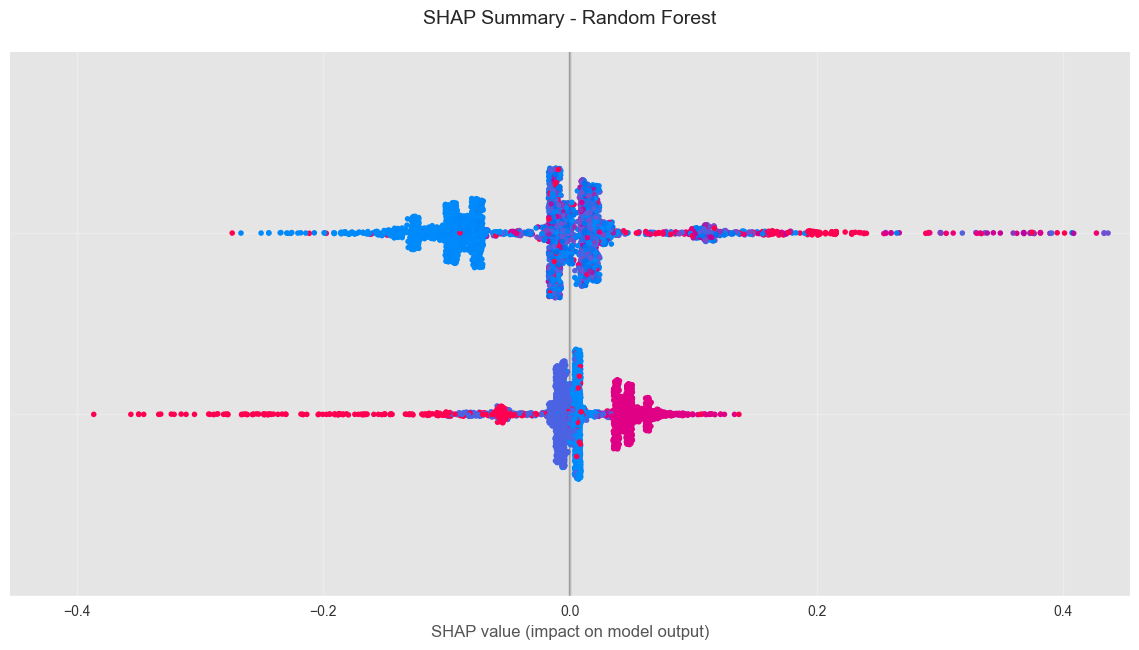

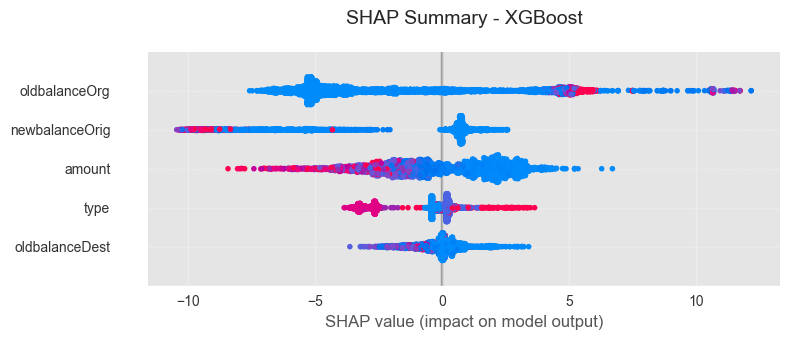

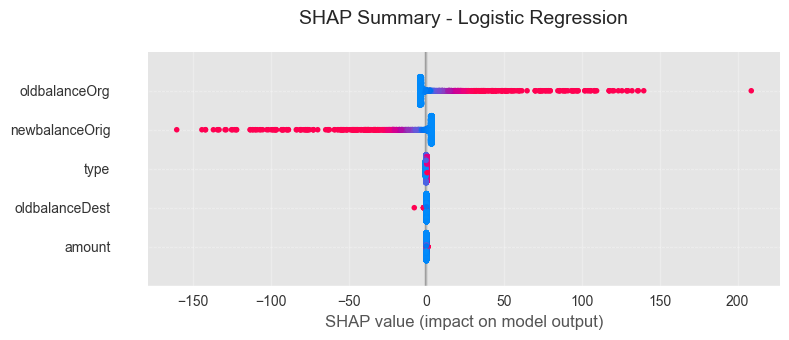

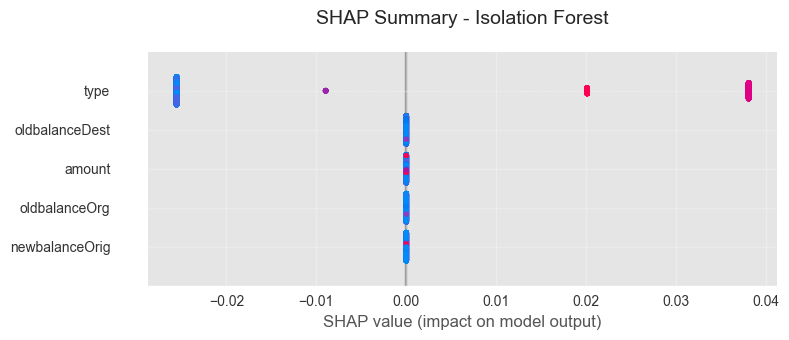

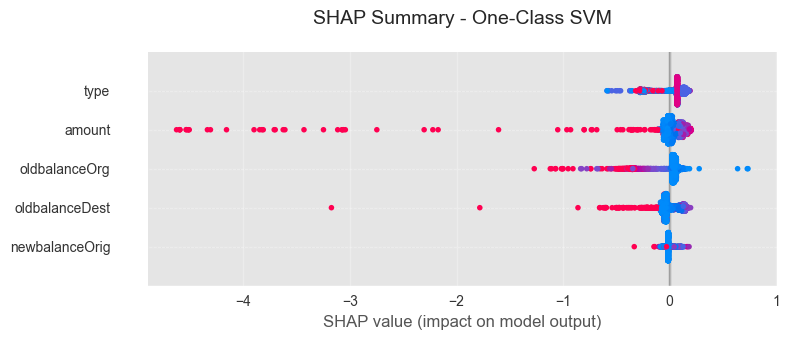

In [69]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Ensure consistent style
plt.style.use('seaborn' if 'seaborn' in plt.style.available else 'ggplot')

def generate_shap_plot(model, X_data, model_name, model_type='tree'):
    """Generate consistent SHAP summary plot for a given model."""
    try:
        # Convert X_data to DataFrame with feature names
        if isinstance(X_data, np.ndarray):
            X_data = pd.DataFrame(X_data, columns=selected_features)

        # Choose appropriate SHAP explainer
        if model_type == 'tree':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_data)
            if isinstance(shap_values, list):  # For binary classifiers
                shap_values = shap_values[1]
        elif model_type == 'linear':
            explainer = shap.LinearExplainer(model, X_data)
            shap_values = explainer.shap_values(X_data)
        elif model_type == 'unsupervised':
            scores = model.decision_function(X_data)
            surrogate = RandomForestRegressor(n_estimators=50, random_state=42)
            surrogate.fit(X_data, scores)
            explainer = shap.TreeExplainer(surrogate)
            shap_values = explainer.shap_values(X_data)

        # Plot SHAP summary
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_data,
                          plot_type="dot",
                          show=False,
                          color_bar=False)
        
        # Unified formatting
        plt.title(f"SHAP Summary - {model_name}", fontsize=14, pad=20)
        plt.xlabel("SHAP value (impact on model output)", fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.gca().tick_params(labelsize=10)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error generating SHAP plot for {model_name}: {str(e)}")

# Ensure all test sets are DataFrames with the same features
X_test_df_full = pd.DataFrame(X_test_scaled_full, columns=selected_features)

# Generate SHAP plots for all models
models_to_plot = [
    (rf, X_test_df_full, "Random Forest", 'tree'),
    (xgb, X_test_df_full, "XGBoost", 'tree'),
    (lr, X_test_scaled_full, "Logistic Regression", 'linear'),
    (best_iso_model, X_test_df_full, "Isolation Forest", 'unsupervised'),
    (best_svm_model, X_test_df_full, "One-Class SVM", 'unsupervised')
]

for model, X_data, name, mtype in models_to_plot:
    generate_shap_plot(model, X_data, name, mtype)


<Figure size 1000x600 with 0 Axes>

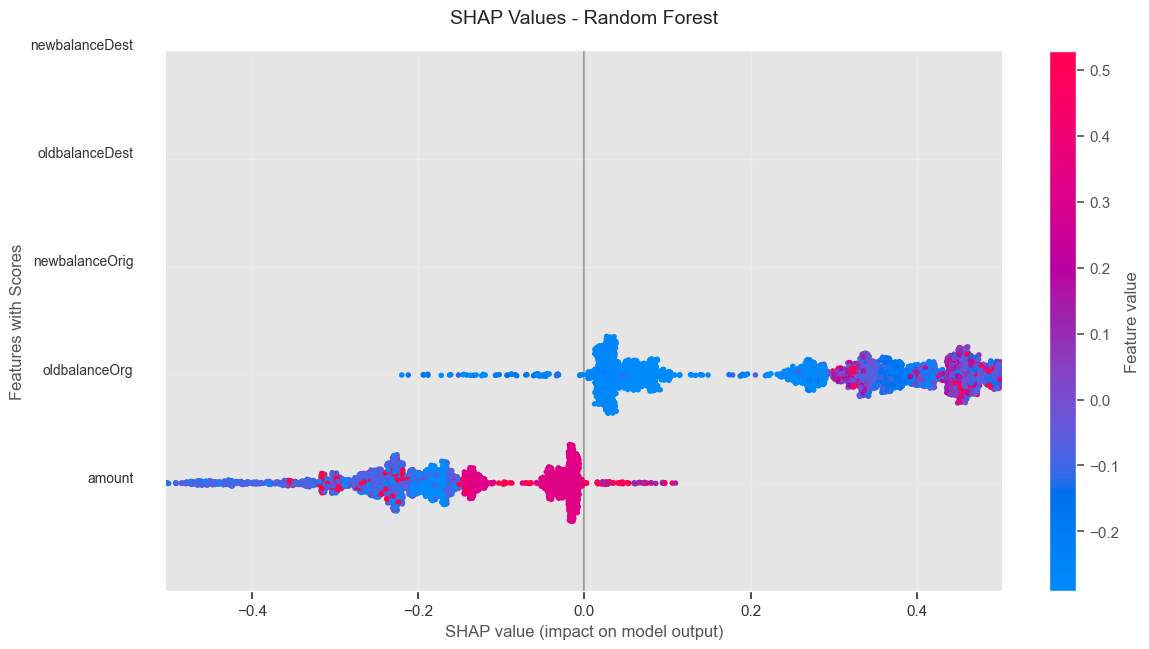

In [93]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Prepare the test data with correct feature names
X_rf = pd.DataFrame(X_test_scaled_full, columns=selected_features)

# Compute SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_rf)

# For binary classification, use SHAP values for fraud class (class 1)
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# Calculate mean absolute SHAP values for each feature
mean_shap = [np.mean(np.abs(shap_values[:, i])) for i in range(shap_values.shape[1])]

# Create proper labels with feature names and impact values
feature_labels = [f"{name}\n" 
                 for name, val in zip(selected_features, mean_shap)]

# Generate the plot with correct labeling
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_rf,
    plot_type='dot',
    show=False,
    feature_names=feature_labels,
    color_bar=False
)

# Formatting with correct labels
plt.title("SHAP Values - Random Forest", fontsize=14, pad=20)
plt.xlabel("SHAP value (impact on model output)", fontsize=12)
plt.ylabel("Features with Scores", fontsize=12)
plt.yticks(ticks=range(len(selected_features)), labels=feature_labels, fontsize=10)
plt.grid(True, alpha=0.2)

# Add color bar
plt.colorbar(label='Feature value', aspect=40, pad=0.05, fraction=0.05)

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

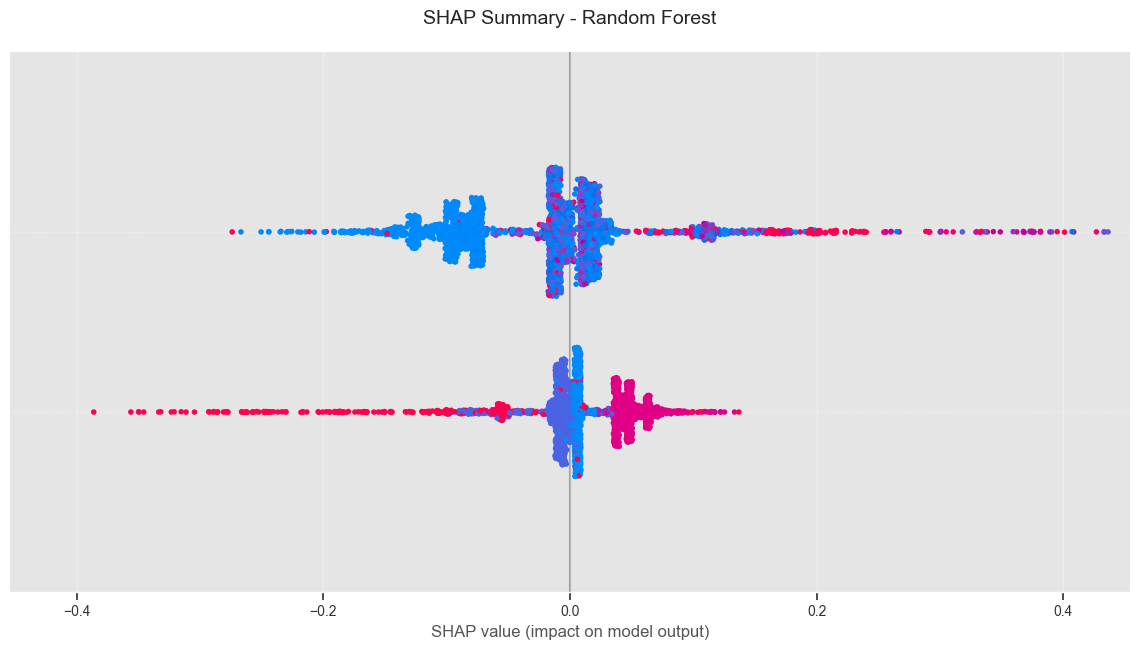

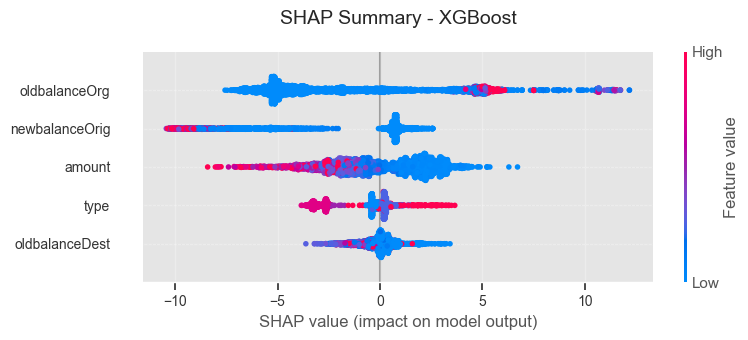

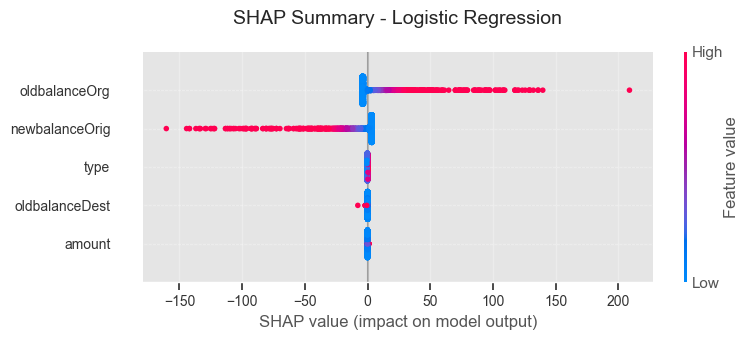

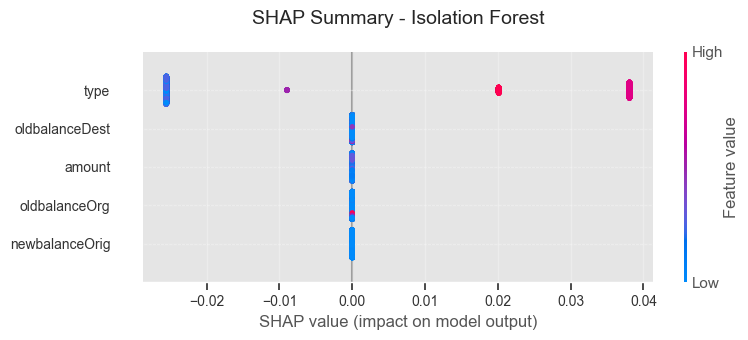

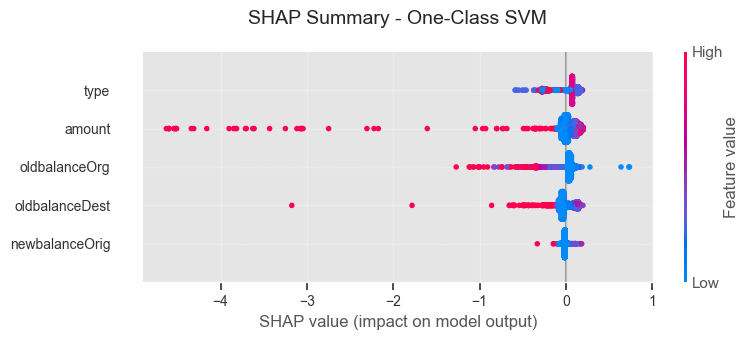

In [52]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Ensure consistent style
plt.style.use('seaborn' if 'seaborn' in plt.style.available else 'ggplot')

def generate_shap_plot(model, X_data, model_name, model_type='tree'):
    """Generate SHAP summary plot with automatic color bar."""
    try:
        # Convert to DataFrame if needed
        if isinstance(X_data, np.ndarray):
            X_data = pd.DataFrame(X_data, columns=selected_features)

        # Choose SHAP explainer
        if model_type == 'tree':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_data)
            if isinstance(shap_values, list):  # Binary classifier
                shap_values = shap_values[1]
        elif model_type == 'linear':
            explainer = shap.LinearExplainer(model, X_data)
            shap_values = explainer.shap_values(X_data)
        elif model_type == 'unsupervised':
            scores = model.decision_function(X_data)
            surrogate = RandomForestRegressor(n_estimators=50, random_state=42)
            surrogate.fit(X_data, scores)
            explainer = shap.TreeExplainer(surrogate)
            shap_values = explainer.shap_values(X_data)

        # Generate SHAP summary plot (with automatic color bar)
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_data, plot_type="dot", show=False)  # <- color bar enabled by default

        # Styling
        plt.title(f"SHAP Summary - {model_name}", fontsize=14, pad=20)
        plt.xlabel("SHAP value (impact on model output)", fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.gca().tick_params(labelsize=10)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error generating SHAP plot for {model_name}: {str(e)}")

# Prepare data
X_test_df_full = pd.DataFrame(X_test_scaled_full, columns=selected_features)

# Models to explain
models_to_plot = [
    (rf, X_test_df_full, "Random Forest", 'tree'),
    (xgb, X_test_df_full, "XGBoost", 'tree'),
    (lr, X_test_scaled_full, "Logistic Regression", 'linear'),
    (best_iso_model, X_test_df_full, "Isolation Forest", 'unsupervised'),
    (best_svm_model, X_test_df_full, "One-Class SVM", 'unsupervised')
]

# Plot SHAP values for all models
for model, X_data, name, mtype in models_to_plot:
    generate_shap_plot(model, X_data, name, mtype)


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from scipy.interpolate import make_interp_spline
# Load your dataset
data = pd.read_csv('FRAUD.CSV')

# 1. Data Preparation --------------------------------------------------------
# Select relevant features (adjust based on your dataset)
features = [
    'type',          # Transaction type
    'amount',        # Transaction amount
    'oldbalanceOrg', # Originator balance before
    'newbalanceOrig' # Originator balance after
]

# Create feature matrix and target
X = data[features]
y = data['isFraud']

# 2. Preprocessing ----------------------------------------------------------
# Encode categorical features
le = LabelEncoder()
X['type_encoded'] = le.fit_transform(X['type'])

# Final numeric features (drop original 'type')
numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'type_encoded']
X = X[numeric_features]
# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train supervised models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)

lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_scaled, y_train)

# Step 7: Train anomaly detectors (on normal class: churn = 0)
X_train_norm = X_train_scaled[y_train == 0]

iso = IsolationForest(contamination=0.5, random_state=42)
iso.fit(X_train_norm)

ocsvm = OneClassSVM(nu=0.5, kernel='rbf', gamma='scale')
ocsvm.fit(X_train_norm)

# Step 8: Get prediction scores
def get_model_scores(name, model, X):
    if name in ['Random Forest', 'XGBoost', 'Logistic Regression']:
        return model.predict_proba(X)[:, 1]
    elif name == 'Isolation Forest':
        scores = -model.decision_function(X)
        return MinMaxScaler().fit_transform(scores.reshape(-1, 1)).ravel()
    elif name == 'One-Class SVM':
        scores = -model.decision_function(X)
        return MinMaxScaler().fit_transform(scores.reshape(-1, 1)).ravel()

# Dictionary of models for evaluation and plotting
models = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'Logistic Regression': lr,
    'Isolation Forest': iso,
    'One-Class SVM': ocsvm
}

# Step 10: Calculate metrics for all models
metrics = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1 Score': f1_score
}

# Store metrics results here
results = {name: {} for name in models.keys()}

for name, model in models.items():
    # Get binary predictions for supervised models
    if name in ['Random Forest', 'XGBoost', 'Logistic Regression']:
        preds = model.predict(X_test_scaled)
    else:
        # For anomaly detectors, threshold scores at 0.5
        scores = get_model_scores(name, model, X_test_scaled)
        preds = [1 if s > 0.5 else 0 for s in scores]

    for metric_name, metric_func in metrics.items():
        if metric_name in ['Precision', 'Recall', 'F1 Score']:
            results[name][metric_name] = metric_func(y_test, preds, zero_division=0)
        else:
            results[name][metric_name] = metric_func(y_test, preds)


/tmp/ipykernel_400433/3405010506.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['type_encoded'] = le.fit_transform(X['type'])
/home/wycliffe/.local/lib/aims/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:13:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


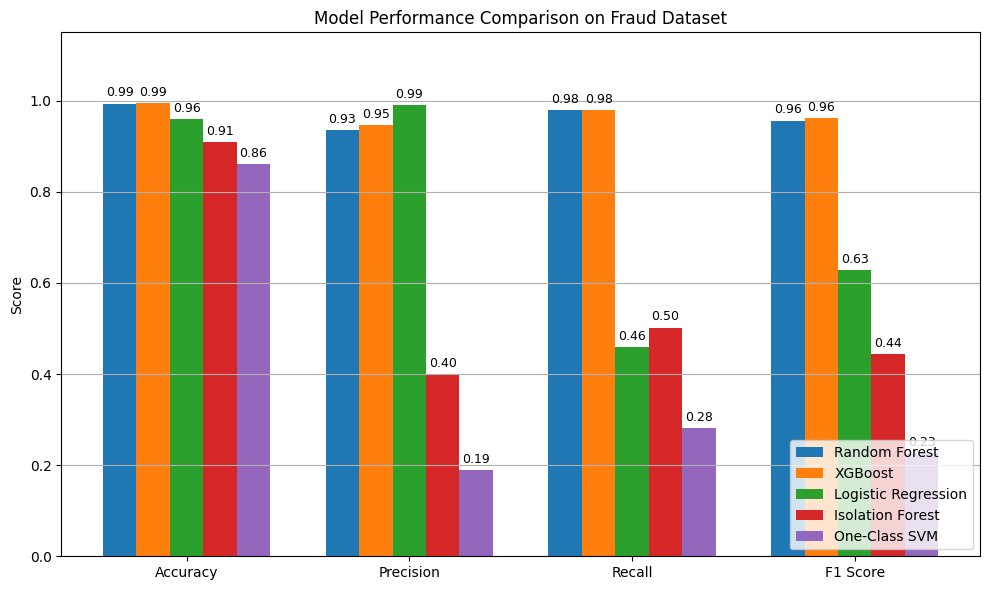

In [13]:
import numpy as np
import matplotlib.pyplot as plt

metric_names = list(metrics.keys())
model_names = list(models.keys())

# Prepare data for plotting
data = np.array([[results[m][metric] for metric in metric_names] for m in model_names])

x = np.arange(len(metric_names))  # metric positions
width = 0.15  # width of bars

fig, ax = plt.subplots(figsize=(10, 6))

for i, model_name in enumerate(model_names):
    bars = ax.bar(x + i*width, data[i], width, label=model_name)
    # Add float labels (e.g., 0.63) on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

ax.set_xticks(x + width * (len(model_names) - 1) / 2)
ax.set_xticklabels(metric_names)
ax.set_ylim([0, 1.15])
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison on Fraud Dataset')
ax.legend(loc='lower right')
ax.grid(axis='y')

plt.tight_layout()
plt.savefig("metric_performance_comparison_Fraud3.pdf", dpi=300)
plt.show()


/home/wycliffe/.local/lib/aims/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:13:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


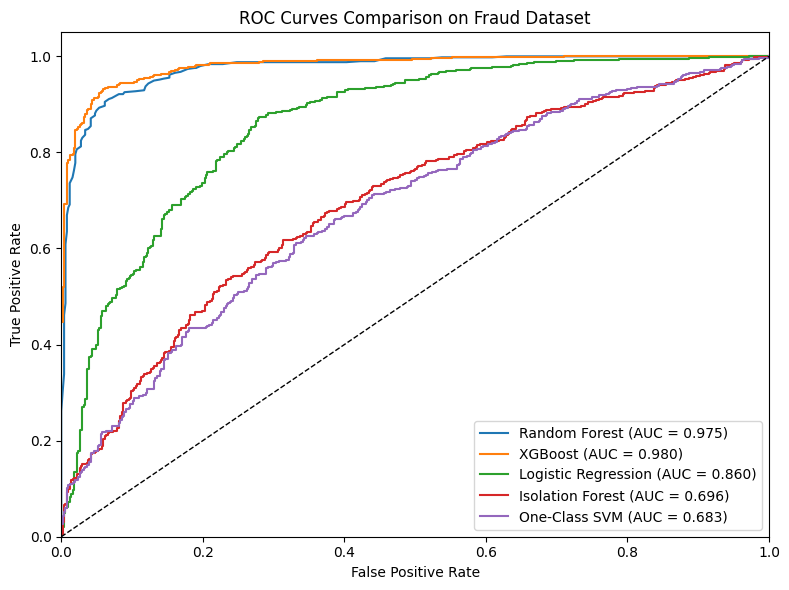

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier

# Step 1: Generate dummy binary classification dataset
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=10, n_informative=6, n_redundant=2, random_state=42)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train classifiers
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

# Step 5: Train anomaly detectors (unsupervised, trained only on majority class)
X_train_norm = X_train_scaled[y_train == 0]

iso = IsolationForest(contamination=0.5, random_state=42)
iso.fit(X_train_norm)

ocsvm = OneClassSVM(nu=0.5, kernel='rbf', gamma='scale')
ocsvm.fit(X_train_norm)

# Step 6: Get prediction scores
def get_model_scores(name, model, X):
    if name in ['Random Forest', 'XGBoost', 'Logistic Regression']:
        return model.predict_proba(X)[:, 1]
    elif name == 'Isolation Forest':
        scores = -model.decision_function(X)
        return MinMaxScaler().fit_transform(scores.reshape(-1, 1)).ravel()
    elif name == 'One-Class SVM':
        scores = -model.decision_function(X)
        return MinMaxScaler().fit_transform(scores.reshape(-1, 1)).ravel()

# Step 7: Plot ROC curves
models = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'Logistic Regression': lr,
    'Isolation Forest': iso,
    'One-Class SVM': ocsvm
}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    scores = get_model_scores(name, model, X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison on Fraud Dataset')
plt.legend(loc='lower right')
plt.grid(False)
plt.tight_layout()
plt.savefig("roc_comparison_Fraud.pdf", dpi=300)
plt.show()
